## IML_Projet_6
Classez des images à l'aide d'algorithmes de Deep Learning

Ce note book contient : 
- La creation et le test de mon propre reseau de neurone CCN 

Try to find hyper parameters to have a good baseline : 
- number of filters for Conv2D Layers
- number of units/nodes for FC Dense output layer
- initializers for layers
- learning rate


## Installation libraries

## Data mount drive folder

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd /content/drive/My Drive/OpenClassRooms/IML_Projet_6/code/DeepLearningPictureDogs

/content/drive/My Drive/OpenClassRooms/IML_Projet_6/code/DeepLearningPictureDogs


In [0]:
!ls

01_OC_IML_Project_6_explorations.ipynb	     my_utils_dogs.py  README.md
02_OC_IML_Project_6_my_neural_network.ipynb  __pycache__


## Import

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)

import os

import re

import pickle

import time

from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import label_binarize

import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 25)

import scipy.io as sio

from PIL import Image
from PIL import ImageOps
from PIL import ImageFilter
import cv2 as cv

import tensorflow
print(tensorflow.__version__)

# keras from scratch
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense
from keras.models import load_model
# keras already trained
from keras.applications.vgg16 import VGG16
# keras image preparation
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
# decode prediction
from keras.applications.vgg16 import decode_predictions
# for training keras model : optimizers
from keras import optimizers
# Keras model base
from keras.models import Model

import json

# ne marche pas (une modif d'une fonction d'un module ne se répercute pas)
# import user module
#from my_utils_dogs import find_breed


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


1.15.0


Using TensorFlow backend.


## Definitions

In [0]:
path_data = '/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/'
path_file_list = 'lists/file_list.mat'
path_test_list = 'lists/test_list.mat'
path_train_list = 'lists/train_list.mat'
path_test_data = 'test_data.mat'
path_train_data = 'train_data.mat'

paths_images_all_breeds = ['Images/n02107683-Bernese_mountain_dog/',
                     'Images/n02088094-Afghan_hound/',
                     'Images/n02096051-Airedale/',
                     'Images/n02090721-Irish_wolfhound/',
                     'Images/n02091831-Saluki/',
                     'Images/n02092002-Scottish_deerhound/',
                     'Images/n02096294-Australian_terrier/',
                     'Images/n02095889-Sealyham_terrier/',
                     'Images/n02095570-Lakeland_terrier/',
                     'Images/n02110185-Siberian_husky/']

nb_breeds = 3
paths_images_breeds = paths_images_all_breeds[:nb_breeds]

path_img_test = path_data + 'Images/n02085620-Chihuahua/' + "n02085620_242.jpg"

path_df_dogs = path_data + 'df_dogs.pkl'
path_X_images = path_data + 'X_images.pkl'
path_Y_images = path_data + 'Y_images.pkl'

name_new_model_2 = 'VGG16_TL_class_01'
path_model_2 = path_data +  name_new_model_2 + '.pkl'

path_df_results = path_data + 'df_results.pkl'

path_imagenet = path_data + 'Images/imagenet_class_index.json'

train_percent = 0.7

## Useful functions

In [0]:
def import_data(paths_images_breeds, train_percent=0.7, force_import=False,
                path_df_dogs=path_df_dogs, path_X_images=path_X_images,
                path_train_list=None):
  '''
  Import data from images on disk

  3 possibilites if force_import = False:
  (1) no data on disk, no data in memory :
    - create df_dogs & X from image files 
    - separate train / test set for df_dogs
  (2) data pickled on disk, no data in memory : 
    - load data from pickled files for df_dogs & X
    - separate train / test set for df_dogs
  (3) data in memory
    - use df_dogs & X from memory 
    - separate train / test set for df_dogs
    - save df_dogs & X on disk
  
  if force_import = True, only  read from image files (1) is possible.

  example: import from memory or already pickled files on disk, with 70% train: 
    df_dogs, X, dict_breed = import_data(paths_images_breeds)
  
  '''
  # import from already processed pickle files on disk
  try:
    if force_import == False:
      df_dogs, X, dict_breed = load_data_breeds() # to load if not exist
      #df_dogs = separate_train_by_class(df_dogs, train_percent=train_percent)
      return df_dogs, X, dict_breed 
  except:
    # if not in memory and not on disk
    pass # continue with importation from images files on disk
  

  # import from image files on disk
  df_dogs = pd.DataFrame(columns=["filename", "path", "breed", "class", 
                                  'Train'])
  # read images in source folders
  X=None
  for id, path_curr in enumerate(paths_images_breeds):
    breed_curr = re.findall('\w+(?=/$)', path_curr)
    print(breed_curr)
    for filename in os.listdir(path_data + path_curr):
      df_add = pd.DataFrame(columns=["filename", "path", "breed", "class", 
                                     "Train"], 
                          index =[0])
      df_add["filename"] = filename
      df_add["path"] = path_data + path_curr + filename
      df_add["breed"] = breed_curr
      df_add["class"] = id
      df_dogs = df_dogs.append(df_add, ignore_index=True)
      # create X image matrix
      img = load_img(df_add["path"].values[0], 
               target_size=(224, 224))  # Charger l'image
      img = img_to_array(img)  # Convertir en tableau numpy
      if X is None:
        X = img[np.newaxis, :]
      X = np.concatenate((X, img[np.newaxis, :]), axis=0)

  # seperate train/test 
  # check test/train mode
  if path_train_list is not None:
    print('Train/Test separation by mat')
    mat_train = sio.loadmat(path_data + path_train_list)
    df_train = pd.DataFrame(data=mat_train["file_list"], 
                           columns=["filename_brut"])
    df_train["filename"] = df_train["filename_brut"].apply(apply_find_filename)
    df_dogs["Train"] = df_dogs["filename"].apply(check_file_train, 
                                                 args=(df_train,))
  else:
    print('Train/Test separation by percent')
    df_dogs = separate_train_by_class(df_dogs, train_percent=train_percent)   
  # preprocess image data for VGG-16
  X = preprocess_input(X)

  # find breed name
  dict_breed = dict()
  for id_class in df_dogs["class"].unique(): 
    dict_breed[id_class] = df_dogs[df_dogs["class"] == \
                                 id_class]["breed"].values[0]
  
  # save on disk
  save_data(df_dogs, path_df_dogs, X, path_X_images)

  return df_dogs, X, dict_breed

def check_file_train(filename, df_train):
  '''
  Apply function for dataFrame column to check Train file from data
  '''
  if filename in df_train["filename"].values:
    return True
  else:
    return False

def apply_find_filename(value):
  '''
  apply function for dataFrame column to extract filename from text

  example : 
    [n02085620-Chihuahua/n02085620_5927.jpg]	-> n02085620_5927.jpg
  '''
  return re.findall('(?<=/).+', value[0])[0]

def load_data_breeds(force_reload=False, path_df_dogs=path_df_dogs,
                     path_X_images=path_X_images):
  '''
  Load data from disk if variable df_dogs & X is not available in memory

  Optional parameter force_reload can be use to force reload in any case.

  example : df_dogs, X, dict_breed = load_data_breeds() # to load if not exist
  '''
  # df_dogs
  if force_reload == False:
    try:
      if df_dogs is not None:
        df_out = df_dogs
      else:
        print("Loading from disk df_dogs...")
        df_out = joblib.load(path_df_dogs)
    except:
      print("Loading from disk df_dogs...")
      df_out = joblib.load(path_df_dogs)
  else:
    print("Loading from disk df_dogs...")
    df_out = joblib.load(path_df_dogs)
  # X images
  if force_reload == False:
    try:
      X_out = X
    except:
      print("Loading from disk X images...")
      X_out = joblib.load(path_X_images)
  else:
    print("Loading from disk X images...")
    X_out = joblib.load(path_X_images)

  # find breed name
  dict_breed = dict()
  for id_class in df_out["class"].unique(): 
    dict_breed[id_class] = df_out[df_out["class"] == \
                                 id_class]["breed"].values[0]
  
  return df_out, X_out, dict_breed

def separate_train_by_class(df_dogs, train_percent=0.7):

  '''
  Separate TRAIN / TEST set per breed

  by default train_percent = 0.7

  add "Train" column to df_dogs

  example : df_dogs = separate_train_by_class(df_dogs, train_percent=0.7)
  '''

  df_dogs['Train'] = False
  for id_class in df_dogs["class"].unique():
    np.random.seed(0)
    indices_permut = np.random.permutation(\
      df_dogs[df_dogs["class"] == id_class].shape[0])
    indices_permut_train = \
      indices_permut[0:np.int(len(indices_permut)*train_percent)]
    index_train  = df_dogs[df_dogs["class"] == \
                         id_class].iloc[indices_permut_train].index
    df_dogs.loc[index_train, "Train"] = True

  v= df_dogs["Train"].value_counts()
  print("% of Train : {:.2f} %".format(100*v.loc[True]/sum(v)))
  print(df_dogs["Train"].value_counts())

  return df_dogs

def create_separate_features(df_dogs, X, list_X_classes=None,
                             list_Y_classes=None):
  '''
  Seperate train/test matrix of images to be use by CNN Models
  
  example : 
    X_train, X_test, Y_train, Y_test, lb = create_separate_features(df_dogs, X)
  '''
  # select from df_dogs & X only list of breed : list_X_classes
  def fun_class_ok(classNum):
    if classNum in list_X_classes:
      return True
    else:
      return False
  
  if list_X_classes is not None:
    df_in = df_dogs
    df_in["class_OK"] = False
    df_in["class_OK"] = df_dogs["class"].apply(fun_class_ok)

    df_in = df_in[df_in["class_OK"] == True]
  else:
    df_in = df_dogs
  
  # seperate train/test matrix of images 
  index_train = df_in[df_in["Train"] == True].index
  index_test = df_in[df_in["Train"] == False].index
  X_train = X[index_train,:,:,:]
  X_test = X[index_test,:,:,:]

  # prepare for Y the classes
  if list_Y_classes is None:
    lb = LabelBinarizer()
    lb.fit(df_in["class"].tolist())
    Y_train = lb.transform(df_in[df_in["Train"] == True]["class"].tolist())
    Y_test =  lb.transform(df_in[df_in["Train"] == False]["class"].tolist())
  else:
    # use list_Y_classes
    # lb function
    def lb(x):
      return label_binarize(x, classes=list_Y_classes)
    # transform train set
    Y_train = lb(
        df_in[df_in["Train"] == True]["breed"].tolist())
    # transform test set
    Y_test = lb(
        df_in[df_in["Train"] == False]["breed"].tolist())

  return X_train, X_test, Y_train, Y_test, lb

def load_prepare_img(path_img):
  '''
  Load image from path and prepare for VGG-16
  return : 
    img : np array
    img_raw : Image from PIL

  example : img, img_raw = load_prepare_img(path_img)
  '''

  img_raw = load_img(path_img, target_size=(224, 224))  # Charger l'image
  img = img_to_array(img_raw)  # Convertir en tableau numpy
  img = img[np.newaxis, :]
  img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16
  img_raw
  return img, img_raw

def get_imagenet_classes():
  # get labels
  with open(path_imagenet) as json_data:
    class_idx = json.load(json_data)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    # PATCH : to correct double classes
    idx2label[idx2label.index("crane")] = "crane_0"
    idx2label[idx2label.index("maillot")] = "maillot_0"
  return idx2label

In [0]:
def save_data(df_dogs, path_df_dogs, X, path_X_images):
  '''
  Save data on disk : df_dogs & X images

  example : save_data(df_dogs, path_df_dogs, X, path_X_images)

  '''
  joblib.dump(df_dogs, path_df_dogs, compress=True)
  print("df_dogs Saved here:\n{}".format(path_df_dogs))
  joblib.dump(X, path_X_images, compress=True)
  print("X Saved here:\n{}".format(path_X_images))

In [0]:
def predict_breed_from_one_path(path_img, mdl):
  '''
  Predict Breed Name from one image path

  example : breedName = predict_breed_from_one_path(path_img, model)
  '''
  print(path_img)
  img, img_raw = load_prepare_img(path_img)
  y = mdl.predict(img) 
  if y.shape[1] >= 1000:
    breedName = decode_predictions(y, top=3)[0]
    print('VGG-16 : Top 3 :', breedName)
  else:
    print("Probabilities : ", y)
    breedName = find_breed(y, dict_breed)
  print(breedName)
  return breedName, img_raw

  def find_breed(y, dict_breed):
    '''
    Find Breed Name from y output of CNN model
    breed_name = find_breed(y, dict_breed)
    '''
    return dict_breed[np.argmax(y)]

In [0]:
def evaluate_mdl_scorings(Y_train, Y_train_pred,
                          Y_test, Y_test_pred, 
                          timing_fit=0, timing_pred=0):

    '''
    Take scores from predictions
    V1.1 : 24/11/2019 : add acc test per breed
    '''
    dict_scores = dict()
    
    #calculate over same splits f1_micro mean & std
    #cv_lda

    '''
    f1_splits = []
    # on splits test
    for train_index, test_index in cv_lda.split(enc_lda_y_train):
        f1_splits.append(f1_score(enc_lda_y_train[test_index], 
                                  enc_lda_ypred_train[test_index], 
                                  average='micro'))  
    dict_scores["f1_splits_test"] = np.mean(f1_splits)
    dict_scores["f1_splits_test_std"] = np.std(f1_splits)
    '''
    
    # transform as class number 
    Y_train_pred_num = np.argmax(Y_train_pred, axis=1)
    Y_train_num = np.argmax(Y_train, axis=1)
    Y_test_pred_num = np.argmax(Y_test_pred, axis=1)
    Y_test_num = np.argmax(Y_test, axis=1)

    dict_scores["acc_train"] = accuracy_score(Y_train_num, Y_train_pred_num)

    dict_scores["acc_test"] = accuracy_score(Y_test_num, Y_test_pred_num)

    dict_scores["t_fit"] = timing_fit
    dict_scores["t_pred"] = timing_pred

    # find sort of breed name in Y classes (imagent) vs. X classes 
    # (selection of dogs)
    list_id=[]
    for id_y in np.unique(Y_test_num):
      for num_breed, breed_name in dict_breed.items():
        if breed_name == list_Y_classes[id_y]:
          list_id.append(num_breed)
    # add accuracy per breed
    K_id=0
    for id_class in np.unique(Y_test_num):
      str_dict_entry = "acc_test_{}B_{}".format(len(np.unique(Y_test_num)), list_id[K_id])
      dict_scores[str_dict_entry] = accuracy_score(
          Y_test_num[Y_test_num == id_class], 
          Y_test_pred_num[Y_test_num == id_class])
      K_id += 1
    
    return pd.Series(data = dict_scores)

def add_score(df_results, series_scores, model_name):
    
    df_results_add = pd.DataFrame(data=series_scores, columns=[model_name]).T
    
    if df_results is None: # create table
        print('create df_results')
        df_results = df_results_add.copy()
    else: # update or add line
        try:
            # ligne existe alors on efface l'ancienne ligne  ?
            df_results = df_results.drop(index=model_name)                                
            print('update line')
        except:
            # n'existe pas
            print('add line')
            
        # on ajoute la ligne
        df_results = df_results.append(df_results_add)
        
    return df_results

#### plot_history

In [0]:
def plot_history(history, my_title=None):
  # plot results at each iterations
  fig = plt.figure(figsize=(12, 8))
  if my_title is not None:
    fig.suptitle(my_title, fontsize=18)
  ax1 = fig.add_subplot(2,2,1)
  ax1.plot(range(0, len(history["acc"])), 
          history["acc"], 'o-')
  ax1.set_xlabel("epochs [-]")
  ax1.set_ylabel("accuracy [-]")
  ax2 = fig.add_subplot(2,2,2)
  ax2.set_xlabel("epochs [-]")
  ax2.set_ylabel("acc test [-]")
  ax2.plot(range(0, len(history['val_acc'])), 
          history["val_acc"], 'ro-')
  ax3 = fig.add_subplot(2,2,3)
  ax3.set_xlabel("epochs [-]")
  ax3.set_ylabel("loss [-]")
  ax3.plot(range(0, len(history['loss'])), 
          history["loss"], 'o-')

  ax4 = fig.add_subplot(2,2,4)
  ax4.set_xlabel("epochs [-]")
  ax4.set_ylabel("val_loss [-]")
  ax4.plot(range(0, len(history['val_loss'])), 
          history["val_loss"], 'ro-')

## Data importation

### Load images of dogs from different folders

In [0]:
force_import = False # only from disk or memory
df_dogs = None # from disk

In [0]:
# import data from disk images & save them into memory and DISK !
df_dogs, X, dict_breed = import_data(paths_images_all_breeds, 
                                     force_import=force_import, 
                                     path_train_list=path_train_list)
# check
print("Image matrix size : ", X.shape)
df_dogs.head()

Loading from disk df_dogs...
Loading from disk X images...
Image matrix size :  (2097, 224, 224, 3)


filename                                               path  \
0  n02107683_1175.jpg  /content/drive/My Drive/OpenClassRooms/IML_Pro...   
1  n02107683_1248.jpg  /content/drive/My Drive/OpenClassRooms/IML_Pro...   
2  n02107683_1244.jpg  /content/drive/My Drive/OpenClassRooms/IML_Pro...   
3  n02107683_1003.jpg  /content/drive/My Drive/OpenClassRooms/IML_Pro...   
4  n02107683_1076.jpg  /content/drive/My Drive/OpenClassRooms/IML_Pro...   

                  breed class  Train  
0  Bernese_mountain_dog     0  False  
1  Bernese_mountain_dog     0   True  
2  Bernese_mountain_dog     0   True  
3  Bernese_mountain_dog     0  False  
4  Bernese_mountain_dog     0  False

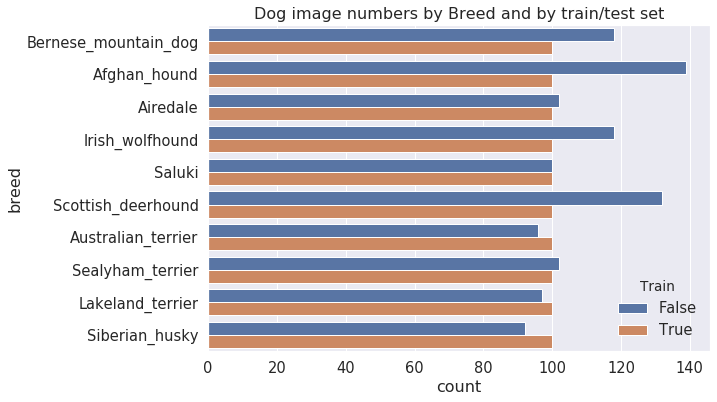

In [0]:
# Categorical bar plot with train/test
fig = plt.figure(figsize=(9, 6))
plt.title("Dog image numbers by Breed and by train/test set")
ax = sns.countplot(y="breed", hue="Train", data=df_dogs)

## Keras Neural Network from scratch

Just the first part : Neural Network Structure before fitting process

### Features

In [0]:
nb_breeds

3

In [0]:
X_train, X_test, Y_train, Y_test, lb = create_separate_features(df_dogs,
  X, list_X_classes=np.array(range(nb_breeds)))
print("X_train ",X_train.shape)
print("X_test ",X_test.shape)
print("Y_train ",Y_train.shape)
print("Y_test ",Y_test.shape)

X_train  (300, 224, 224, 3)
X_test  (359, 224, 224, 3)
Y_train  (300, 3)
Y_test  (359, 3)


### First neural networks

Model: "my_VGG16_01"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_115 (Conv2D)          (None, 224, 224, 16)      1216      
_________________________________________________________________
conv2d_116 (Conv2D)          (None, 224, 224, 16)      6416      
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
flatten_58 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_115 (Dense)            (None, 100)               313700    
_________________________________________________________________
dense_116 (Dense)            (None, 3)                 303       
Total params: 321,635
Trainable params: 321,635
Non-trainable params: 0
_________________________________________________

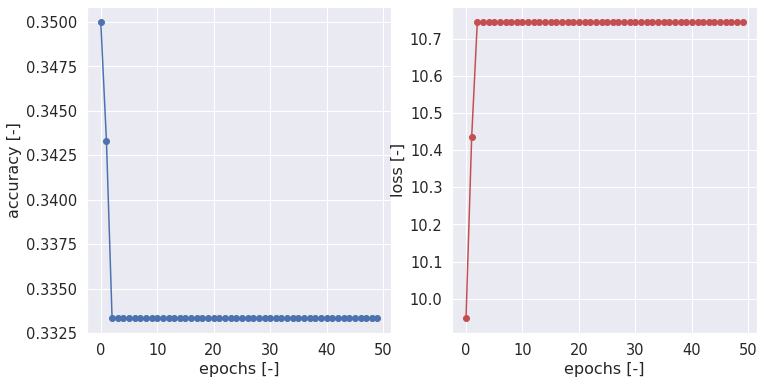

In [0]:
my_VGG16 = Sequential()  # Création d'un réseau de neurones vide 
my_VGG16.name = 'my_VGG16_01'
# Ajout de la première couche de convolution, suivie d'une couche ReLU
my_VGG16.add(Conv2D(16, (5, 5), input_shape=(224, 224, 3), padding='same', 
                    activation='relu'))

# Ajout de la deuxième couche de convolution, suivie  d'une couche ReLU
my_VGG16.add(Conv2D(16, (5, 5), padding='same', activation='relu'))

# Ajout de la première couche de pooling
#my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # original
my_VGG16.add(MaxPooling2D(pool_size=(16,16), strides=(16,16))) # test
my_VGG16.add(Flatten())  # Conversion des matrices 3D en vecteur 1D

# Ajout de la première couche fully-connected, suivie d'une couche ReLU
my_VGG16.add(Dense(100, activation='relu'))

# Ajout de la deuxième couche fully-connected, suivie d'une couche ReLU
#my_VGG16.add(Dense(4096, activation='relu'))

# Ajout de la dernière couche fully-connected qui permet de classifier
my_VGG16.add(Dense(nb_breeds, activation='softmax'))
print(my_VGG16.summary())

# optimizer
sgd_2 = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True) 
# compile model
my_VGG16.compile(loss="categorical_crossentropy", optimizer=sgd_2, 
                 metrics=["accuracy"])
# prepare training
epochs = 50
batch_size = None
t_fit_0 = time.time()
# fitting
model_info = my_VGG16.fit(X_train, Y_train, epochs=epochs, 
                             batch_size=batch_size, verbose=2)
t_fit_1 = time.time()
print("Timing: ", t_fit_1 - t_fit_0)

# plot results at each iterations
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(range(0, len(model_info.history["acc"])), model_info.history["acc"],
         'o-')
ax1.set_xlabel("epochs [-]")
ax1.set_ylabel("accuracy [-]")
ax2 = fig.add_subplot(1,2,2)
ax2.set_xlabel("epochs [-]")
ax2.set_ylabel("loss [-]")
ax2.plot(range(0, len(model_info.history['loss'])), model_info.history["loss"],
         'ro-')


Model: "my_VGG16_02"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_73 (Conv2D)           (None, 75, 75, 16)        1216      
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 25, 25, 16)        6416      
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 1, 1, 16)          0         
_________________________________________________________________
flatten_37 (Flatten)         (None, 16)                0         
_________________________________________________________________
dense_73 (Dense)             (None, 100)               1700      
_________________________________________________________________
dense_74 (Dense)             (None, 3)                 303       
Total params: 9,635
Trainable params: 9,635
Non-trainable params: 0
_____________________________________________________

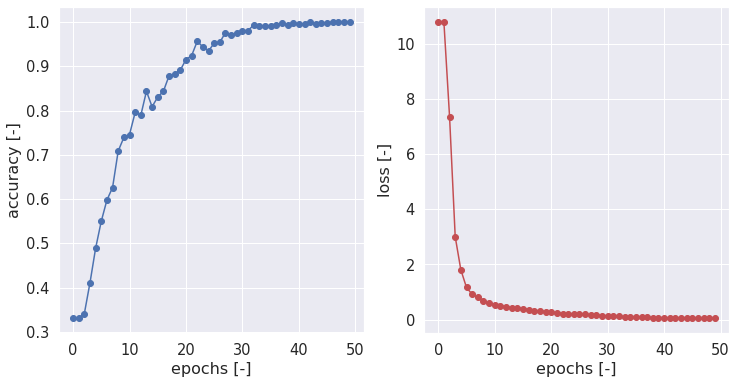

In [0]:
my_VGG16_02 = Sequential()  # Création d'un réseau de neurones vide 
my_VGG16_02.name = 'my_VGG16_02'
# Ajout de la première couche de convolution, suivie d'une couche ReLU
my_VGG16_02.add(Conv2D(16, kernel_size=5, strides=3, input_shape=(224, 224, 3),
                       padding='same', activation='relu'))

# Ajout de la deuxième couche de convolution, suivie  d'une couche ReLU
my_VGG16_02.add(Conv2D(16, kernel_size=5, strides=3, padding='same', 
                       activation='relu'))

# Ajout de la première couche de pooling
#my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # original
my_VGG16_02.add(MaxPooling2D(pool_size=(16,16), strides=(16,16))) # test
my_VGG16_02.add(Flatten())  # Conversion des matrices 3D en vecteur 1D

# Ajout de la première couche fully-connected, suivie d'une couche ReLU
my_VGG16_02.add(Dense(100, activation='relu'))

# Ajout de la deuxième couche fully-connected, suivie d'une couche ReLU
#my_VGG16.add(Dense(4096, activation='relu'))

# Ajout de la dernière couche fully-connected qui permet de classifier
my_VGG16_02.add(Dense(nb_breeds, activation='softmax'))
print(my_VGG16_02.summary())

# optimizer
sgd_2 = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True) 
# compile model
my_VGG16_02.compile(loss="categorical_crossentropy", optimizer=sgd_2, 
                 metrics=["accuracy"])
# prepare training
epochs = 50
batch_size = None
t_fit_0 = time.time()
# fitting
model_info_2 = my_VGG16_02.fit(X_train, Y_train, epochs=epochs, 
                             batch_size=batch_size, verbose=2)
t_fit_1 = time.time()
print("Timing: ", t_fit_1 - t_fit_0)

# plot results at each iterations
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(range(0, len(model_info_2.history["acc"])), 
         model_info_2.history["acc"], 'o-')
ax1.set_xlabel("epochs [-]")
ax1.set_ylabel("accuracy [-]")
ax2 = fig.add_subplot(1,2,2)
ax2.set_xlabel("epochs [-]")
ax2.set_ylabel("loss [-]")
ax2.plot(range(0, len(model_info_2.history['loss'])), 
         model_info_2.history["loss"], 'ro-')


In [0]:
# save
joblib.dump(my_VGG16_02, path_data + 'my_VGG16_02.pkl', compress=True)

['/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/my_VGG16_02.pkl']

In [0]:
# load 
my_VGG16_02 = joblib.load(path_data + 'my_VGG16_02.pkl')

In [0]:
print("Loading from disk df_results...")
df_results = joblib.load(path_df_results)

Loading from disk df_results...


In [0]:
# predict as binary labels
t_pred_0 = time.time()
Y_train_pred = my_VGG16_02.predict(X_train)
t_pred_1 = time.time()
# predict as binary labels
t_pred_2 = time.time()
Y_test_pred = my_VGG16_02.predict(X_test)
t_pred_3 = time.time()

In [0]:
series_scores = evaluate_mdl_scorings(Y_train, Y_train_pred, 
                                      Y_test, Y_test_pred, 
  timing_fit=t_fit_1 - t_fit_0, timing_pred=t_pred_3-t_pred_2+t_pred_1-t_pred_0)

In [0]:
df_results = add_score(df_results, series_scores, my_VGG16_02.name)
df_results

add line


acc_train  acc_test      t_fit    t_pred
VGG16_TL_class_01      0.990  0.974930  11.906220  1.757683
vgg16                  0.771  0.775547   0.000000  5.777447
my_VGG16_02            1.000  0.512563  12.295422  0.835936

In [0]:
# save results
joblib.dump(df_results, path_df_results, compress=True)
print("df_results Saved here:\n{}".format(path_df_results))

df_results Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_results.pkl


#### Predict from images

/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/Images/n02107683-Bernese_mountain_dog/n02107683_1248.jpg
Probabilities :  [[9.9522650e-01 4.1897157e-03 5.8383163e-04]]
Bernese_mountain_dog


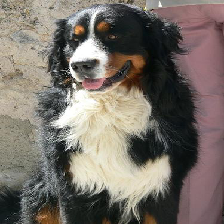

In [0]:
path_img = df_dogs[df_dogs["Train"] == False]["path"].values[0]
breedName, img_raw = predict_breed_from_one_path(path_img, my_VGG16_02)
img_raw

Try to predict a picture from internet :

/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data//image_internet_test/Bernese_mountain_dog_01.jpg
Probabilities :  [[1.0000000e+00 5.3052732e-11 2.0185066e-08]]
Bernese_mountain_dog


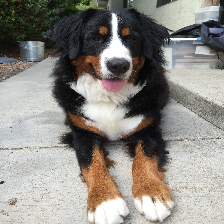

In [0]:
path_img = path_data + '/image_internet_test/Bernese_mountain_dog_01.jpg'
breedName, img_raw = predict_breed_from_one_path(path_img, my_VGG16_02)
img_raw

/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data//image_internet_test/Afghan_hound_01.png
Probabilities :  [[0.43600813 0.14792104 0.4160708 ]]
Bernese_mountain_dog


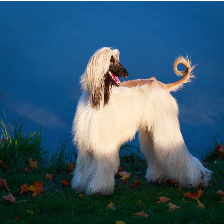

In [0]:
path_img = path_data + '/image_internet_test/Afghan_hound_01.png'
breedName, img_raw = predict_breed_from_one_path(path_img, my_VGG16_02)
img_raw

/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data//image_internet_test/Airedale_01.png
Probabilities :  [[0.01018371 0.25959554 0.73022074]]
Airedale


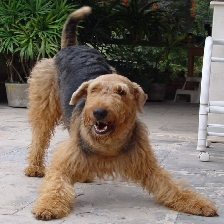

In [0]:
path_img = path_data + '/image_internet_test/Airedale_01.png'
breedName, img_raw = predict_breed_from_one_path(path_img, my_VGG16_02)
img_raw

### Autre test : my_VGG16_03

Model: "my_VGG16_03"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 224, 224, 23)      644       
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 112, 112, 23)      0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 112, 112, 22)      4576      
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 56, 56, 22)        0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 68992)             0         
_________________________________________________________________
dense_51 (Dense)             (None, 100)               6899300   
_________________________________________________________________
dense_52 (Dense)             (None, 3)                 

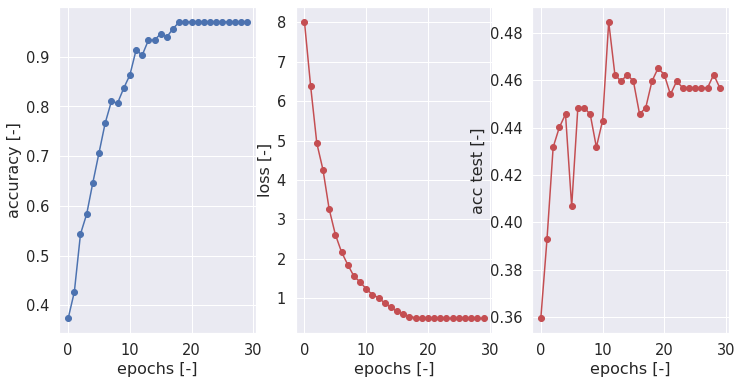

In [0]:
my_VGG16_03 = Sequential()  # Création d'un réseau de neurones vide 
my_VGG16_03.name = 'my_VGG16_03'
# Ajout de la première couche de convolution, suivie d'une couche ReLU
my_VGG16_03.add(Conv2D(23, kernel_size=3, strides=1, input_shape=(224, 224, 3),
                       padding='same', activation='relu'))
my_VGG16_03.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # test
# Ajout de la deuxième couche de convolution, suivie  d'une couche ReLU
my_VGG16_03.add(Conv2D(22, kernel_size=3, strides=1, padding='same', 
                       activation='relu'))

# Ajout de la première couche de pooling
#my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # original
my_VGG16_03.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # test
my_VGG16_03.add(Flatten())  # Conversion des matrices 3D en vecteur 1D

# Ajout de la première couche fully-connected, suivie d'une couche ReLU
my_VGG16_03.add(Dense(100, activation='relu'))

# Ajout de la deuxième couche fully-connected, suivie d'une couche ReLU
#my_VGG16.add(Dense(4096, activation='relu'))

# Ajout de la dernière couche fully-connected qui permet de classifier
my_VGG16_03.add(Dense(nb_breeds, activation='softmax'))
print(my_VGG16_03.summary())

# optimizer
sgd_2 = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True) 
# compile model
my_VGG16_03.compile(loss="categorical_crossentropy", optimizer=sgd_2, 
                 metrics=["accuracy"])
# prepare training
epochs = 30
batch_size = None
t_fit_0 = time.time()
# fitting
model_info_3 = my_VGG16_03.fit(X_train, Y_train, epochs=epochs, 
                             batch_size=batch_size, verbose=2,
                             validation_data=(X_test, Y_test))
t_fit_1 = time.time()
print("Timing: ", t_fit_1 - t_fit_0)

# plot results at each iterations
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1,3,1)
ax1.plot(range(0, len(model_info_3.history["acc"])), 
         model_info_3.history["acc"], 'o-')
ax1.set_xlabel("epochs [-]")
ax1.set_ylabel("accuracy [-]")
ax2 = fig.add_subplot(1,3,2)
ax2.set_xlabel("epochs [-]")
ax2.set_ylabel("loss [-]")
ax2.plot(range(0, len(model_info_3.history['loss'])), 
         model_info_3.history["loss"], 'ro-')
ax3 = fig.add_subplot(1,3,3)
ax3.set_xlabel("epochs [-]")
ax3.set_ylabel("acc test [-]")
ax3.plot(range(0, len(model_info_3.history['val_acc'])), 
         model_info_3.history["val_acc"], 'ro-')

Train on 300 samples, validate on 359 samples
Epoch 1/10
 - 4s - loss: 10.7454 - acc: 0.3333 - val_loss: 9.8774 - val_acc: 0.3872
Epoch 2/10
 - 2s - loss: 10.7454 - acc: 0.3333 - val_loss: 9.8774 - val_acc: 0.3872
Epoch 3/10
 - 2s - loss: 10.7454 - acc: 0.3333 - val_loss: 9.8774 - val_acc: 0.3872
Epoch 4/10
 - 2s - loss: 10.7454 - acc: 0.3333 - val_loss: 9.8774 - val_acc: 0.3872
Epoch 5/10
 - 2s - loss: 10.7454 - acc: 0.3333 - val_loss: 9.8774 - val_acc: 0.3872
Epoch 6/10
 - 2s - loss: 10.7454 - acc: 0.3333 - val_loss: 9.8774 - val_acc: 0.3872
Epoch 7/10
 - 2s - loss: 10.7454 - acc: 0.3333 - val_loss: 9.8774 - val_acc: 0.3872
Epoch 8/10
 - 2s - loss: 10.7454 - acc: 0.3333 - val_loss: 9.8774 - val_acc: 0.3872
Epoch 9/10
 - 2s - loss: 10.7454 - acc: 0.3333 - val_loss: 9.8774 - val_acc: 0.3872
Epoch 10/10
 - 2s - loss: 10.7454 - acc: 0.3333 - val_loss: 9.8774 - val_acc: 0.3872
Timing:  22.337701320648193


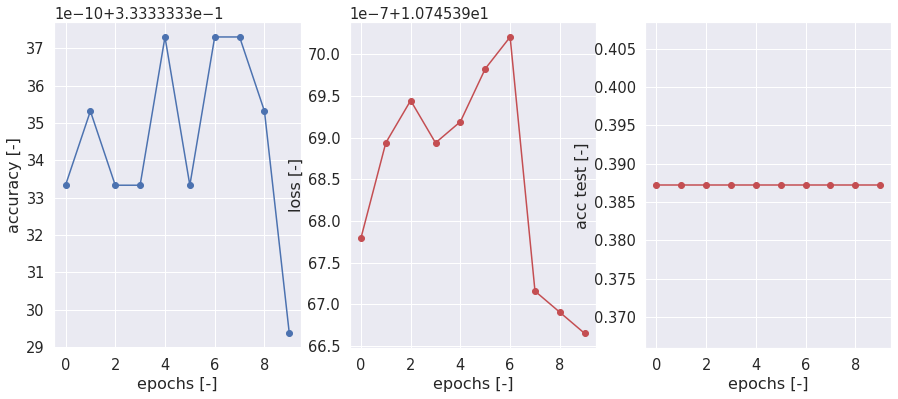

In [0]:
## REFIT

# optimizer
sgd_2 = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) 
# compile model
my_VGG16_03.compile(loss="categorical_crossentropy", optimizer=sgd_2, 
                 metrics=["accuracy"])
# prepare training
epochs = 10
batch_size = None
t_fit_0 = time.time()
# fitting
model_info_3 = my_VGG16_03.fit(X_train, Y_train, epochs=epochs, 
                             batch_size=batch_size, verbose=2,
                             validation_data=(X_test, Y_test))
t_fit_1 = time.time()
print("Timing: ", t_fit_1 - t_fit_0)

# plot results at each iterations
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(1,3,1)
ax1.plot(range(0, len(model_info_3.history["acc"])), 
         model_info_3.history["acc"], 'o-')
ax1.set_xlabel("epochs [-]")
ax1.set_ylabel("accuracy [-]")
ax2 = fig.add_subplot(1,3,2)
ax2.set_xlabel("epochs [-]")
ax2.set_ylabel("loss [-]")
ax2.plot(range(0, len(model_info_3.history['loss'])), 
         model_info_3.history["loss"], 'ro-')
ax3 = fig.add_subplot(1,3,3)
ax3.set_xlabel("epochs [-]")
ax3.set_ylabel("acc test [-]")
ax3.plot(range(0, len(model_info_3.history['val_acc'])), 
         model_info_3.history["val_acc"], 'ro-')


In [0]:
# save
#joblib.dump(my_VGG16_03, path_data + 'my_VGG16_03.pkl', compress=True)
my_VGG16_03.save(path_data + 'my_VGG16_03.h5')

In [0]:
# load 
#my_VGG16_03 = joblib.load(path_data + 'my_VGG16_03.pkl')
my_VGG16_03 = load_model(path_data + 'my_VGG16_03.h5')

In [0]:
print("Loading from disk df_results...")
df_results = joblib.load(path_df_results)

Loading from disk df_results...


In [0]:
# predict as binary labels
t_pred_0 = time.time()
Y_train_pred = my_VGG16_03.predict(X_train)
t_pred_1 = time.time()
# predict as binary labels
t_pred_2 = time.time()
Y_test_pred = my_VGG16_03.predict(X_test)
t_pred_3 = time.time()

In [0]:
series_scores = evaluate_mdl_scorings(Y_train, Y_train_pred, 
                                      Y_test, Y_test_pred, 
  timing_fit=t_fit_1 - t_fit_0, timing_pred=t_pred_3-t_pred_2+t_pred_1-t_pred_0)

In [0]:
df_results = add_score(df_results, series_scores, my_VGG16_03.name)
df_results

update line


acc_train  acc_test      t_fit    t_pred
VGG16_TL_class_01   0.990000  0.974930  11.906220  1.757683
vgg16               0.771000  0.775547   0.000000  5.777447
my_VGG16_02         1.000000  0.512563  12.295422  0.835936
my_VGG16_03         0.866667  0.440111  13.711606  0.724172

In [0]:
# save results
joblib.dump(df_results, path_df_results, compress=True)
print("df_results Saved here:\n{}".format(path_df_results))

df_results Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_results.pkl


### Loop over nb conv filters / 100 nodes FC /  glorot uniform random (1 run)

In [0]:
# loop on nb filter to check if accuracy is better and memory not saturated
for nb_filters in range(23, 64):
  my_VGG16_03 = Sequential()  # Création d'un réseau de neurones vide 
  my_VGG16_03.name = 'my_VGG16_03_{}filt'.format(nb_filters)  
  # Ajout de la première couche de convolution, suivie d'une couche ReLU
  my_VGG16_03.add(Conv2D(nb_filters, kernel_size=3, strides=1, 
                       input_shape=(224, 224, 3),
                       padding='same', activation='relu'))
  my_VGG16_03.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # test
  # Ajout de la deuxième couche de convolution, suivie  d'une couche ReLU
  my_VGG16_03.add(Conv2D(nb_filters, kernel_size=3, strides=1, padding='same', 
                       activation='relu'))

  # Ajout de la première couche de pooling
  #my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # original
  my_VGG16_03.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # test
  my_VGG16_03.add(Flatten())  # Conversion des matrices 3D en vecteur 1D

  # Ajout de la première couche fully-connected, suivie d'une couche ReLU
  my_VGG16_03.add(Dense(100, activation='relu'))

  # Ajout de la deuxième couche fully-connected, suivie d'une couche ReLU
  #my_VGG16.add(Dense(4096, activation='relu'))

  # Ajout de la dernière couche fully-connected qui permet de classifier
  my_VGG16_03.add(Dense(nb_breeds, activation='softmax'))
  print(my_VGG16_03.summary())

  # optimizer
  sgd_2 = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True) 
  # compile model
  my_VGG16_03.compile(loss="categorical_crossentropy", optimizer=sgd_2, 
                 metrics=["accuracy"])
  # prepare training
  epochs = 30
  batch_size = None
  t_fit_0 = time.time()
  # fitting
  model_info_3 = my_VGG16_03.fit(X_train, Y_train, epochs=epochs, 
                             batch_size=batch_size, verbose=2,
                             validation_data=(X_test, Y_test))
  t_fit_1 = time.time()
  print("Timing: ", t_fit_1 - t_fit_0)

  # plot results at each iterations
  fig = plt.figure(figsize=(12, 6))
  ax1 = fig.add_subplot(1,3,1)
  ax1.plot(range(0, len(model_info_3.history["acc"])), 
         model_info_3.history["acc"], 'o-')
  ax1.set_xlabel("epochs [-]")
  ax1.set_ylabel("accuracy [-]")
  ax2 = fig.add_subplot(1,3,2)
  ax2.set_xlabel("epochs [-]")
  ax2.set_ylabel("loss [-]")
  ax2.plot(range(0, len(model_info_3.history['loss'])), 
         model_info_3.history["loss"], 'ro-')
  ax3 = fig.add_subplot(1,3,3)
  ax3.set_xlabel("epochs [-]")
  ax3.set_ylabel("acc test [-]")
  ax3.plot(range(0, len(model_info_3.history['val_acc'])), 
         model_info_3.history["val_acc"], 'ro-')

  # save
  my_VGG16_03.save(path_data + 'my_VGG16_03_{}filt.h5'.format(nb_filters))

  # predict as binary labels
  t_pred_0 = time.time()
  Y_train_pred = my_VGG16_03.predict(X_train)
  t_pred_1 = time.time()
  # predict as binary labels
  t_pred_2 = time.time()
  Y_test_pred = my_VGG16_03.predict(X_test)
  t_pred_3 = time.time()

  series_scores = evaluate_mdl_scorings(Y_train, Y_train_pred, 
                                      Y_test, Y_test_pred, 
  timing_fit=t_fit_1 - t_fit_0, timing_pred=t_pred_3-t_pred_2+t_pred_1-t_pred_0)

  df_results = add_score(df_results, series_scores, my_VGG16_03.name)
  df_results

  # save results
  joblib.dump(df_results, path_df_results, compress=True)
  print("df_results Saved here:\n{}".format(path_df_results))


Output hidden; open in https://colab.research.google.com to view.

In [0]:
nb_filters

63

#### Compare

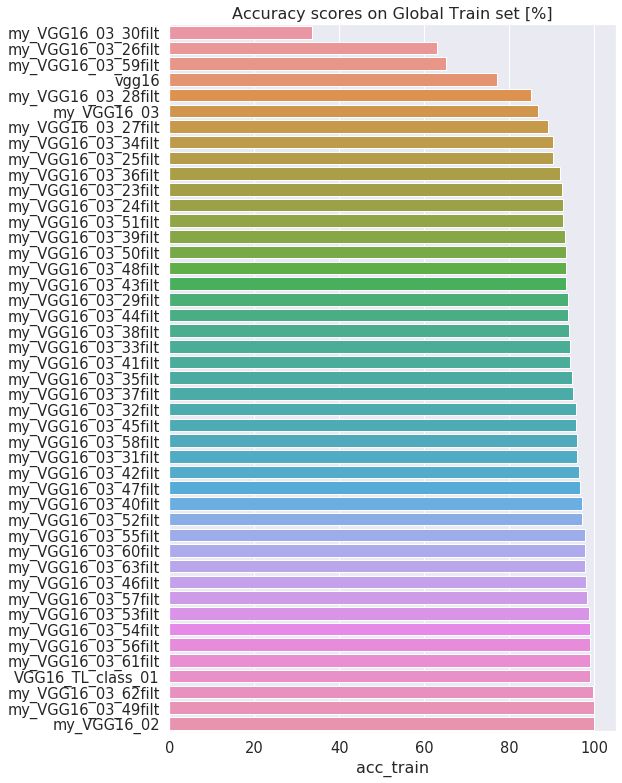

In [0]:
fig = plt.figure(figsize=(8, 13))
plt.title("Accuracy scores on Global Train set [%]")
ax = sns.barplot(
    y=df_results.sort_values(by="acc_train").index,
    x=100*df_results.sort_values(by="acc_train")["acc_train"], orient="h")

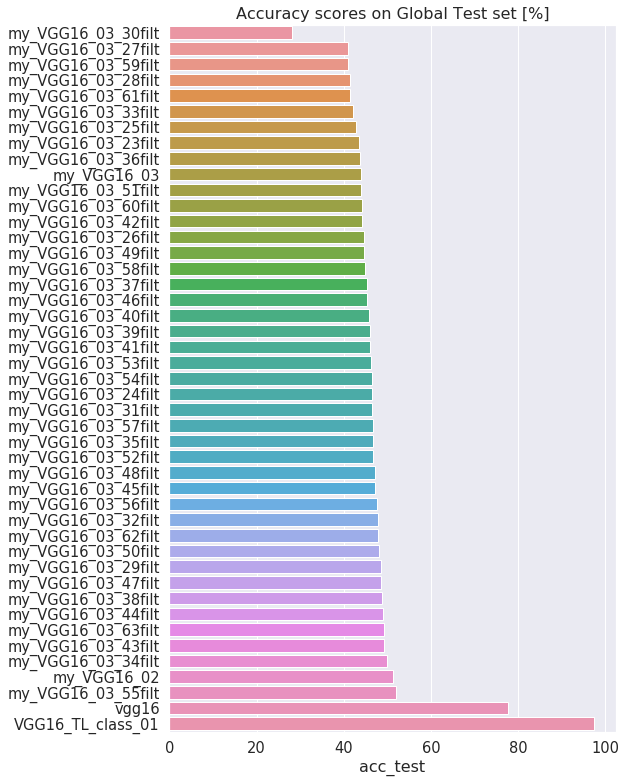

In [0]:
fig = plt.figure(figsize=(8, 13))
plt.title("Accuracy scores on Global Test set [%]")
ax = sns.barplot(
    y=df_results.sort_values(by="acc_test").index,
    x=100*df_results.sort_values(by="acc_test")["acc_test"], orient="h")

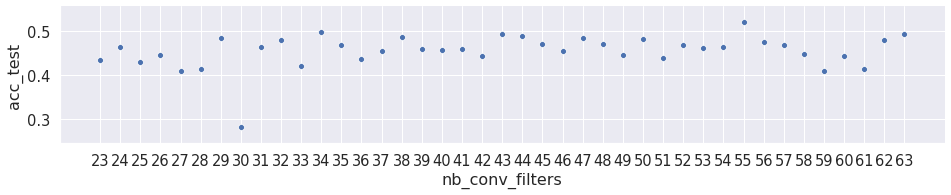

In [0]:
#df_results["nb_conv_filters"] = 

#df_test
#re.findall("\d+(?=filt$)",'my_VGG16_03_24filt')
def apply_find_nb_filters(str_name):
  try: 
    return re.findall("\d+(?=filt$)", str_name)[0]
  except:
    return np.nan
df_test = df_results.copy()
df_test["name"] = df_test.index
df_test["nb_conv_filters"] = df_test.name.apply(apply_find_nb_filters)
df_test

g = sns.relplot(x="nb_conv_filters", y="acc_test", data=df_test,
                height=3, aspect=4.5)

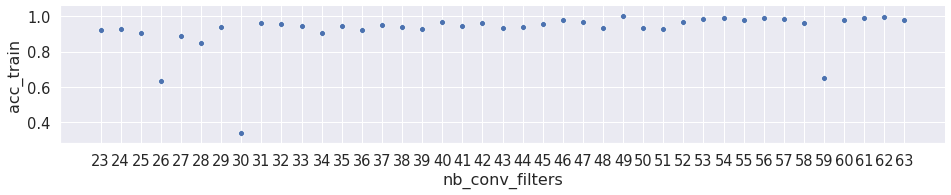

In [0]:
g = sns.relplot(x="nb_conv_filters", y="acc_train", data=df_test,
                height=3, aspect=4.5)

In [0]:

# save results
joblib.dump(df_test, path_data + 'df_my_VGG16_03_all_conv_filters.pkl', compress=True)
print("df_results Saved here:\n{}".format(path_data + 'df_my_VGG16_03_all_conv_filters.pkl'))

df_results Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_my_VGG16_03_all_conv_filters.pkl


#### Conclusion 

Random initialization  have more impact than number of filters for convolution layer

=> need to make several runs at each study



### Loop over nb conv filters / 100 nodes FC /glorot uniform random (10 runs)

In [0]:
print("Loading from disk df_results...")
df_results = joblib.load(path_df_results)

In [0]:
df_res_filters = None
list_nb_filters = []
list_nb_try = []
# loop on nb filter to check if accuracy is better and memory not saturated
for nb_filters in [10, 20, 30, 40, 50, 60]:
  print("nb_filters: ", nb_filters)
  for nb_try in range(0, 10):
    print("nb_try: ", nb_try)
    list_nb_filters.append(nb_filters)
    list_nb_try.append(nb_try)
    my_VGG16_03 = Sequential()  # Création d'un réseau de neurones vide 
    my_VGG16_03.name = 'my_VGG16_03_{}filt_{}'.format(nb_filters, nb_try)  
    # Ajout de la première couche de convolution, suivie d'une couche ReLU
    my_VGG16_03.add(Conv2D(nb_filters, kernel_size=3, strides=1, 
                       input_shape=(224, 224, 3),
                       padding='same', activation='relu'))
    my_VGG16_03.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # test
    # Ajout de la deuxième couche de convolution, suivie  d'une couche ReLU
    my_VGG16_03.add(Conv2D(nb_filters, kernel_size=3, strides=1, padding='same', 
                       activation='relu'))
    # Ajout de la première couche de pooling
    my_VGG16_03.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # test
    my_VGG16_03.add(Flatten())  # Conversion des matrices 3D en vecteur 1D
    # Ajout de la première couche fully-connected, suivie d'une couche ReLU
    my_VGG16_03.add(Dense(100, activation='relu'))
    # Ajout de la dernière couche fully-connected qui permet de classifier
    my_VGG16_03.add(Dense(nb_breeds, activation='softmax'))
    print(my_VGG16_03.summary())
    # optimizer
    sgd_2 = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True) 
    # compile model
    my_VGG16_03.compile(loss="categorical_crossentropy", optimizer=sgd_2, 
                 metrics=["accuracy"])
    # prepare training
    epochs = 100
    batch_size = None
    t_fit_0 = time.time()
    # fitting
    model_info_3 = my_VGG16_03.fit(X_train, Y_train, epochs=epochs, 
                             batch_size=batch_size, verbose=2,
                             validation_data=(X_test, Y_test))
    t_fit_1 = time.time()
    print("Timing: ", t_fit_1 - t_fit_0)

    # plot results at each iterations
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(1,3,1)
    ax1.plot(range(0, len(model_info_3.history["acc"])), 
         model_info_3.history["acc"], 'o-')
    ax1.set_xlabel("epochs [-]")
    ax1.set_ylabel("accuracy [-]")
    ax2 = fig.add_subplot(1,3,2)
    ax2.set_xlabel("epochs [-]")
    ax2.set_ylabel("loss [-]")
    ax2.plot(range(0, len(model_info_3.history['loss'])), 
         model_info_3.history["loss"], 'ro-')
    ax3 = fig.add_subplot(1,3,3)
    ax3.set_xlabel("epochs [-]")
    ax3.set_ylabel("acc test [-]")
    ax3.plot(range(0, len(model_info_3.history['val_acc'])), 
         model_info_3.history["val_acc"], 'ro-')

    # NO save
    #my_VGG16_03.save(path_data + 'my_VGG16_03_{}filt.h5'.format(nb_filters))

    # predict as binary labels
    t_pred_0 = time.time()
    Y_train_pred = my_VGG16_03.predict(X_train)
    t_pred_1 = time.time()
    # predict as binary labels
    t_pred_2 = time.time()
    Y_test_pred = my_VGG16_03.predict(X_test)
    t_pred_3 = time.time()

    series_scores = evaluate_mdl_scorings(Y_train, Y_train_pred, 
                                      Y_test, Y_test_pred, 
    timing_fit=t_fit_1 - t_fit_0, 
      timing_pred=t_pred_3-t_pred_2+t_pred_1-t_pred_0)

    df_res_filters = add_score(df_res_filters, series_scores, my_VGG16_03.name)

    # save results
    joblib.dump(df_res_filters, path_data + 'df_res_filters.pkl', compress=True)
    print("df_res_filters Saved here:\n{}".\
          format(path_data + 'df_res_filters.pkl'))
    
    df_res_filters["nb_filters"] = list_nb_filters
    df_res_filters["nb_try"] = list_nb_try

# save results
joblib.dump(df_res_filters, path_data + 'df_res_filters.pkl', compress=True)
print("df_res_filters Saved here:\n{}".\
          format(path_data + 'df_res_filters.pkl'))
    
df_res_filters

nb_filters:  10
nb_try:  0




Model: "my_VGG16_03_10filt_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 10)      280       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 10)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 10)      910       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 31360)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               3136100   
_________________________________________________________________
dense_2 (Dense)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 2s - loss: 10.0102 - acc: 0.3033 - val_loss: 8.2003 - val_acc: 0.3621
Epoch 2/100
 - 1s - loss: 8.7896 - acc: 0.3233 - val_loss: 7.6711 - val_acc: 0.3788
Epoch 3/100
 - 1s - loss: 8.0780 - acc: 0.3533 - val_loss: 7.1492 - val_acc: 0.4039
Epoch 4/100
 - 1s - loss: 6.8593 - acc: 0.4633 - val_loss: 7.0453 - val_acc: 0.4262
Epoch 5/100
 - 1s - loss: 5.8673 - acc: 0.5267 - val_loss: 6.6770 - val_acc: 0.4513
Epoch 6/100
 - 1s - loss: 5.3437 - acc: 0.5833 - val_loss: 6.4716 - val_acc: 0.4513
Epoch 7/100
 - 1s - loss: 5.0460 - acc: 0.5833 - val_loss: 6.6391 - val_acc: 0.4401
Epoch 8/100
 - 1s - loss: 4.5690 - acc: 0.6500 - val_loss: 6.4141 - val_acc: 0.4624
Epoch 9/100
 - 1s - loss: 4.1436 - acc: 0.6600 - val_loss: 6.5304 - val_acc: 0.4513
Epoch 10/100
 - 1s - loss: 3.7916 - acc: 0.6900 - val_loss: 6.5776 - val_acc: 0.4373
Epoch 11/100
 - 1s - loss: 3.6030 - acc: 0.7267 - val_loss: 6.5023 - val_acc: 0.4485
Epoch 12/100
 - 2s - loss: 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 2s - loss: 8.6991 - acc: 0.4000 - val_loss: 9.7438 - val_acc: 0.3398
Epoch 2/100
 - 1s - loss: 8.0349 - acc: 0.4233 - val_loss: 9.5437 - val_acc: 0.3482
Epoch 3/100
 - 1s - loss: 8.0028 - acc: 0.4367 - val_loss: 9.3898 - val_acc: 0.3482
Epoch 4/100
 - 1s - loss: 7.7089 - acc: 0.4833 - val_loss: 9.4709 - val_acc: 0.3538
Epoch 5/100
 - 1s - loss: 7.4445 - acc: 0.5100 - val_loss: 9.4821 - val_acc: 0.3510
Epoch 6/100
 - 1s - loss: 7.2837 - acc: 0.5167 - val_loss: 9.2644 - val_acc: 0.3538
Epoch 7/100
 - 1s - loss: 7.3000 - acc: 0.5100 - val_loss: 9.4369 - val_acc: 0.3565
Epoch 8/100
 - 1s - loss: 7.0991 - acc: 0.5300 - val_loss: 9.2482 - val_acc: 0.3733
Epoch 9/100
 - 1s - loss: 7.0125 - acc: 0.5500 - val_loss: 9.3146 - val_acc: 0.3649
Epoch 10/100
 - 1s - loss: 6.9597 - acc: 0.5667 - val_loss: 9.2884 - val_acc: 0.3649
Epoch 11/100
 - 1s - loss: 6.9358 - acc: 0.5667 - val_loss: 9.2655 - val_acc: 0.3705
Epoch 12/100
 - 1s - loss: 6

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 2s - loss: 9.0467 - acc: 0.3400 - val_loss: 8.8269 - val_acc: 0.3426
Epoch 2/100
 - 1s - loss: 8.4144 - acc: 0.3767 - val_loss: 8.5609 - val_acc: 0.3398
Epoch 3/100
 - 1s - loss: 7.6187 - acc: 0.4033 - val_loss: 7.9939 - val_acc: 0.3649
Epoch 4/100
 - 1s - loss: 6.6583 - acc: 0.4600 - val_loss: 8.0366 - val_acc: 0.3621
Epoch 5/100
 - 1s - loss: 5.8096 - acc: 0.5200 - val_loss: 7.3675 - val_acc: 0.3900
Epoch 6/100
 - 1s - loss: 5.3528 - acc: 0.5533 - val_loss: 7.5881 - val_acc: 0.4039
Epoch 7/100
 - 1s - loss: 5.0229 - acc: 0.5700 - val_loss: 7.3205 - val_acc: 0.3760
Epoch 8/100
 - 1s - loss: 4.6160 - acc: 0.6133 - val_loss: 7.3705 - val_acc: 0.3955
Epoch 9/100
 - 1s - loss: 4.3401 - acc: 0.6600 - val_loss: 7.6677 - val_acc: 0.4095
Epoch 10/100
 - 1s - loss: 4.2076 - acc: 0.6533 - val_loss: 7.2908 - val_acc: 0.4206
Epoch 11/100
 - 1s - loss: 3.9946 - acc: 0.6867 - val_loss: 7.2972 - val_acc: 0.4067
Epoch 12/100
 - 1s - loss: 3

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 2s - loss: 10.0820 - acc: 0.3033 - val_loss: 10.2776 - val_acc: 0.2702
Epoch 2/100
 - 1s - loss: 9.6412 - acc: 0.2933 - val_loss: 9.7500 - val_acc: 0.2869
Epoch 3/100
 - 1s - loss: 9.1542 - acc: 0.3133 - val_loss: 9.8810 - val_acc: 0.2758
Epoch 4/100
 - 1s - loss: 8.6554 - acc: 0.3600 - val_loss: 9.6624 - val_acc: 0.2786
Epoch 5/100
 - 1s - loss: 8.1602 - acc: 0.4000 - val_loss: 9.6229 - val_acc: 0.2897
Epoch 6/100
 - 1s - loss: 7.8037 - acc: 0.4267 - val_loss: 9.3615 - val_acc: 0.2925
Epoch 7/100
 - 1s - loss: 7.5066 - acc: 0.4700 - val_loss: 9.1764 - val_acc: 0.3008
Epoch 8/100
 - 1s - loss: 7.2500 - acc: 0.4700 - val_loss: 9.0183 - val_acc: 0.3064
Epoch 9/100
 - 1s - loss: 7.0522 - acc: 0.4700 - val_loss: 9.1172 - val_acc: 0.3036
Epoch 10/100
 - 1s - loss: 6.7792 - acc: 0.5233 - val_loss: 8.9742 - val_acc: 0.3092
Epoch 11/100
 - 1s - loss: 6.5960 - acc: 0.5433 - val_loss: 9.0049 - val_acc: 0.3036
Epoch 12/100
 - 1s - loss:

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 2s - loss: 10.2551 - acc: 0.3300 - val_loss: 10.2749 - val_acc: 0.3064
Epoch 2/100
 - 2s - loss: 9.5425 - acc: 0.3167 - val_loss: 8.8865 - val_acc: 0.3649
Epoch 3/100
 - 2s - loss: 9.0562 - acc: 0.3267 - val_loss: 8.6464 - val_acc: 0.3872
Epoch 4/100
 - 2s - loss: 8.8371 - acc: 0.3900 - val_loss: 8.6734 - val_acc: 0.3816
Epoch 5/100
 - 2s - loss: 8.1938 - acc: 0.4167 - val_loss: 8.2476 - val_acc: 0.3844
Epoch 6/100
 - 2s - loss: 7.4836 - acc: 0.4233 - val_loss: 8.3104 - val_acc: 0.3454
Epoch 7/100
 - 2s - loss: 6.7256 - acc: 0.4667 - val_loss: 7.8601 - val_acc: 0.4123
Epoch 8/100
 - 2s - loss: 5.9599 - acc: 0.5167 - val_loss: 7.9491 - val_acc: 0.3872
Epoch 9/100
 - 2s - loss: 5.4285 - acc: 0.5533 - val_loss: 7.7191 - val_acc: 0.3983
Epoch 10/100
 - 2s - loss: 4.9454 - acc: 0.5833 - val_loss: 7.5155 - val_acc: 0.4178
Epoch 11/100
 - 2s - loss: 4.5146 - acc: 0.6467 - val_loss: 7.5650 - val_acc: 0.4123
Epoch 12/100
 - 2s - loss:

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 2s - loss: 10.2270 - acc: 0.3233 - val_loss: 9.4113 - val_acc: 0.3649
Epoch 2/100
 - 2s - loss: 9.7284 - acc: 0.3533 - val_loss: 9.0430 - val_acc: 0.3955
Epoch 3/100
 - 2s - loss: 8.8040 - acc: 0.4167 - val_loss: 8.7424 - val_acc: 0.3983
Epoch 4/100
 - 2s - loss: 8.6305 - acc: 0.4300 - val_loss: 8.4955 - val_acc: 0.4457
Epoch 5/100
 - 2s - loss: 8.2225 - acc: 0.4500 - val_loss: 8.4581 - val_acc: 0.4457
Epoch 6/100
 - 2s - loss: 8.2871 - acc: 0.4500 - val_loss: 8.5477 - val_acc: 0.4262
Epoch 7/100
 - 2s - loss: 7.9294 - acc: 0.5000 - val_loss: 8.4808 - val_acc: 0.4290
Epoch 8/100
 - 2s - loss: 7.9945 - acc: 0.4667 - val_loss: 8.3110 - val_acc: 0.4540
Epoch 9/100
 - 2s - loss: 7.7687 - acc: 0.5033 - val_loss: 8.3437 - val_acc: 0.4429
Epoch 10/100
 - 2s - loss: 7.7077 - acc: 0.5100 - val_loss: 8.2349 - val_acc: 0.4485
Epoch 11/100
 - 2s - loss: 7.6264 - acc: 0.5133 - val_loss: 8.1960 - val_acc: 0.4568
Epoch 12/100
 - 2s - loss: 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 2s - loss: 9.6292 - acc: 0.2867 - val_loss: 8.8201 - val_acc: 0.3398
Epoch 2/100
 - 2s - loss: 9.1142 - acc: 0.3467 - val_loss: 8.4444 - val_acc: 0.3760
Epoch 3/100
 - 2s - loss: 8.2731 - acc: 0.3867 - val_loss: 8.3213 - val_acc: 0.3565
Epoch 4/100
 - 2s - loss: 7.7547 - acc: 0.4033 - val_loss: 8.1040 - val_acc: 0.3733
Epoch 5/100
 - 2s - loss: 6.9723 - acc: 0.4700 - val_loss: 8.0162 - val_acc: 0.3788
Epoch 6/100
 - 2s - loss: 6.4793 - acc: 0.5100 - val_loss: 7.9115 - val_acc: 0.3705
Epoch 7/100
 - 2s - loss: 6.1697 - acc: 0.5467 - val_loss: 7.9335 - val_acc: 0.3928
Epoch 8/100
 - 2s - loss: 5.8609 - acc: 0.6133 - val_loss: 7.8520 - val_acc: 0.3900
Epoch 9/100
 - 1s - loss: 5.6137 - acc: 0.6100 - val_loss: 7.7766 - val_acc: 0.3816
Epoch 10/100
 - 2s - loss: 5.3682 - acc: 0.6100 - val_loss: 7.6194 - val_acc: 0.3788
Epoch 11/100
 - 2s - loss: 5.1402 - acc: 0.6333 - val_loss: 7.6667 - val_acc: 0.3872
Epoch 12/100
 - 2s - loss: 4

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 2s - loss: 10.0796 - acc: 0.3100 - val_loss: 9.0698 - val_acc: 0.3649
Epoch 2/100
 - 1s - loss: 9.5329 - acc: 0.3300 - val_loss: 8.8261 - val_acc: 0.3788
Epoch 3/100
 - 1s - loss: 9.1129 - acc: 0.3700 - val_loss: 9.1944 - val_acc: 0.3482
Epoch 4/100
 - 1s - loss: 8.7641 - acc: 0.4133 - val_loss: 8.9696 - val_acc: 0.3565
Epoch 5/100
 - 1s - loss: 8.4564 - acc: 0.4400 - val_loss: 8.8114 - val_acc: 0.3538
Epoch 6/100
 - 1s - loss: 8.2885 - acc: 0.4633 - val_loss: 9.0526 - val_acc: 0.3593
Epoch 7/100
 - 1s - loss: 8.1727 - acc: 0.4700 - val_loss: 9.0938 - val_acc: 0.3538
Epoch 8/100
 - 1s - loss: 8.0249 - acc: 0.4700 - val_loss: 8.9821 - val_acc: 0.3621
Epoch 9/100
 - 1s - loss: 8.0623 - acc: 0.4633 - val_loss: 8.8498 - val_acc: 0.3760
Epoch 10/100
 - 2s - loss: 7.9165 - acc: 0.4800 - val_loss: 8.7856 - val_acc: 0.3872
Epoch 11/100
 - 2s - loss: 7.4718 - acc: 0.5000 - val_loss: 8.5782 - val_acc: 0.3816
Epoch 12/100
 - 2s - loss: 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 3s - loss: 10.6857 - acc: 0.2900 - val_loss: 10.5724 - val_acc: 0.3175
Epoch 2/100
 - 2s - loss: 10.0775 - acc: 0.3233 - val_loss: 10.2003 - val_acc: 0.3120
Epoch 3/100
 - 2s - loss: 9.4643 - acc: 0.3533 - val_loss: 9.0135 - val_acc: 0.3677
Epoch 4/100
 - 2s - loss: 9.1387 - acc: 0.3767 - val_loss: 8.5408 - val_acc: 0.3816
Epoch 5/100
 - 2s - loss: 8.1678 - acc: 0.4067 - val_loss: 8.5780 - val_acc: 0.3649
Epoch 6/100
 - 2s - loss: 7.2239 - acc: 0.4800 - val_loss: 8.3776 - val_acc: 0.3649
Epoch 7/100
 - 2s - loss: 6.4532 - acc: 0.5100 - val_loss: 7.9542 - val_acc: 0.3928
Epoch 8/100
 - 2s - loss: 6.2603 - acc: 0.5200 - val_loss: 8.1215 - val_acc: 0.4123
Epoch 9/100
 - 2s - loss: 5.4470 - acc: 0.6000 - val_loss: 8.0214 - val_acc: 0.3983
Epoch 10/100
 - 2s - loss: 5.1900 - acc: 0.6267 - val_loss: 7.6737 - val_acc: 0.4178
Epoch 11/100
 - 2s - loss: 4.7368 - acc: 0.6467 - val_loss: 7.8297 - val_acc: 0.4123
Epoch 12/100
 - 2s - los

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 3s - loss: 9.0332 - acc: 0.3433 - val_loss: 8.5884 - val_acc: 0.3510
Epoch 2/100
 - 2s - loss: 7.9307 - acc: 0.3800 - val_loss: 7.9549 - val_acc: 0.3816
Epoch 3/100
 - 2s - loss: 6.6588 - acc: 0.4700 - val_loss: 7.7934 - val_acc: 0.3928
Epoch 4/100
 - 2s - loss: 5.8788 - acc: 0.5367 - val_loss: 7.4599 - val_acc: 0.3760
Epoch 5/100
 - 2s - loss: 5.1546 - acc: 0.5833 - val_loss: 7.1986 - val_acc: 0.4039
Epoch 6/100
 - 2s - loss: 4.4481 - acc: 0.6400 - val_loss: 6.9777 - val_acc: 0.4290
Epoch 7/100
 - 2s - loss: 4.0485 - acc: 0.6800 - val_loss: 7.2580 - val_acc: 0.4262
Epoch 8/100
 - 2s - loss: 3.6230 - acc: 0.7000 - val_loss: 6.6572 - val_acc: 0.4401
Epoch 9/100
 - 2s - loss: 3.2554 - acc: 0.7233 - val_loss: 6.9027 - val_acc: 0.4234
Epoch 10/100
 - 2s - loss: 2.8893 - acc: 0.7567 - val_loss: 6.5626 - val_acc: 0.4290
Epoch 11/100
 - 2s - loss: 2.6125 - acc: 0.8067 - val_loss: 6.3708 - val_acc: 0.4513
Epoch 12/100
 - 2s - loss: 2

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 3s - loss: 8.6037 - acc: 0.3433 - val_loss: 10.3839 - val_acc: 0.2618
Epoch 2/100
 - 2s - loss: 7.9061 - acc: 0.3900 - val_loss: 9.6824 - val_acc: 0.2702
Epoch 3/100
 - 2s - loss: 6.6988 - acc: 0.4733 - val_loss: 8.8678 - val_acc: 0.2953
Epoch 4/100
 - 2s - loss: 5.7127 - acc: 0.5333 - val_loss: 8.2531 - val_acc: 0.3231
Epoch 5/100
 - 2s - loss: 4.9650 - acc: 0.5533 - val_loss: 8.0194 - val_acc: 0.3398
Epoch 6/100
 - 2s - loss: 4.0897 - acc: 0.6633 - val_loss: 8.0475 - val_acc: 0.3175
Epoch 7/100
 - 2s - loss: 3.5785 - acc: 0.7000 - val_loss: 7.7218 - val_acc: 0.3482
Epoch 8/100
 - 2s - loss: 3.3204 - acc: 0.7033 - val_loss: 7.7824 - val_acc: 0.3315
Epoch 9/100
 - 2s - loss: 2.9510 - acc: 0.7700 - val_loss: 7.7088 - val_acc: 0.3538
Epoch 10/100
 - 2s - loss: 2.7754 - acc: 0.7967 - val_loss: 7.6587 - val_acc: 0.3649
Epoch 11/100
 - 2s - loss: 2.6982 - acc: 0.8033 - val_loss: 7.7466 - val_acc: 0.3677
Epoch 12/100
 - 2s - loss: 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 3s - loss: 9.8343 - acc: 0.3133 - val_loss: 9.7062 - val_acc: 0.3315
Epoch 2/100
 - 2s - loss: 8.3493 - acc: 0.3967 - val_loss: 7.8023 - val_acc: 0.3872
Epoch 3/100
 - 2s - loss: 7.2192 - acc: 0.4333 - val_loss: 7.3961 - val_acc: 0.4513
Epoch 4/100
 - 2s - loss: 5.8018 - acc: 0.5267 - val_loss: 7.5677 - val_acc: 0.4234
Epoch 5/100
 - 2s - loss: 4.8793 - acc: 0.6033 - val_loss: 7.0211 - val_acc: 0.4290
Epoch 6/100
 - 2s - loss: 4.1124 - acc: 0.6733 - val_loss: 6.9286 - val_acc: 0.4290
Epoch 7/100
 - 2s - loss: 3.5679 - acc: 0.6867 - val_loss: 7.0129 - val_acc: 0.4485
Epoch 8/100
 - 2s - loss: 3.2450 - acc: 0.7467 - val_loss: 6.7163 - val_acc: 0.4345
Epoch 9/100
 - 2s - loss: 2.9647 - acc: 0.7400 - val_loss: 7.0827 - val_acc: 0.4178
Epoch 10/100
 - 2s - loss: 2.7765 - acc: 0.7833 - val_loss: 6.5747 - val_acc: 0.4457
Epoch 11/100
 - 2s - loss: 2.5113 - acc: 0.7967 - val_loss: 6.6214 - val_acc: 0.4401
Epoch 12/100
 - 2s - loss: 2

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 3s - loss: 10.6993 - acc: 0.3233 - val_loss: 9.6371 - val_acc: 0.3844
Epoch 2/100
 - 2s - loss: 10.0668 - acc: 0.3167 - val_loss: 8.2699 - val_acc: 0.3398
Epoch 3/100
 - 2s - loss: 8.6608 - acc: 0.3367 - val_loss: 8.3467 - val_acc: 0.3231
Epoch 4/100
 - 2s - loss: 7.6496 - acc: 0.3667 - val_loss: 7.8877 - val_acc: 0.3064
Epoch 5/100
 - 2s - loss: 6.3577 - acc: 0.4067 - val_loss: 7.2903 - val_acc: 0.3705
Epoch 6/100
 - 2s - loss: 4.9932 - acc: 0.5033 - val_loss: 6.9680 - val_acc: 0.3983
Epoch 7/100
 - 2s - loss: 4.2614 - acc: 0.5933 - val_loss: 6.7531 - val_acc: 0.3928
Epoch 8/100
 - 2s - loss: 3.5533 - acc: 0.6333 - val_loss: 6.6102 - val_acc: 0.4011
Epoch 9/100
 - 2s - loss: 2.9392 - acc: 0.6700 - val_loss: 6.3133 - val_acc: 0.3928
Epoch 10/100
 - 2s - loss: 2.4719 - acc: 0.7300 - val_loss: 5.8350 - val_acc: 0.4290
Epoch 11/100
 - 2s - loss: 2.1809 - acc: 0.7700 - val_loss: 5.7543 - val_acc: 0.4429
Epoch 12/100
 - 2s - loss:

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 3s - loss: 10.3101 - acc: 0.3200 - val_loss: 9.4062 - val_acc: 0.3343
Epoch 2/100
 - 2s - loss: 8.8136 - acc: 0.3633 - val_loss: 9.5816 - val_acc: 0.3510
Epoch 3/100
 - 2s - loss: 8.5028 - acc: 0.4133 - val_loss: 8.8155 - val_acc: 0.3872
Epoch 4/100
 - 2s - loss: 7.6544 - acc: 0.4700 - val_loss: 8.6210 - val_acc: 0.3900
Epoch 5/100
 - 2s - loss: 6.6917 - acc: 0.4967 - val_loss: 6.9580 - val_acc: 0.4373
Epoch 6/100
 - 2s - loss: 5.5009 - acc: 0.5633 - val_loss: 7.0424 - val_acc: 0.4401
Epoch 7/100
 - 2s - loss: 4.5255 - acc: 0.6233 - val_loss: 6.8270 - val_acc: 0.4373
Epoch 8/100
 - 2s - loss: 4.0696 - acc: 0.6633 - val_loss: 6.6347 - val_acc: 0.4401
Epoch 9/100
 - 2s - loss: 3.5655 - acc: 0.7033 - val_loss: 6.5992 - val_acc: 0.4457
Epoch 10/100
 - 2s - loss: 3.3400 - acc: 0.7500 - val_loss: 6.5437 - val_acc: 0.4485
Epoch 11/100
 - 2s - loss: 3.1527 - acc: 0.7833 - val_loss: 6.6291 - val_acc: 0.4680
Epoch 12/100
 - 2s - loss: 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 3s - loss: 10.6162 - acc: 0.3267 - val_loss: 9.9544 - val_acc: 0.3733
Epoch 2/100
 - 2s - loss: 10.5336 - acc: 0.3433 - val_loss: 9.9333 - val_acc: 0.3760
Epoch 3/100
 - 2s - loss: 10.4908 - acc: 0.3367 - val_loss: 9.7532 - val_acc: 0.3705
Epoch 4/100
 - 2s - loss: 10.0326 - acc: 0.3333 - val_loss: 10.2784 - val_acc: 0.2953
Epoch 5/100
 - 2s - loss: 9.3919 - acc: 0.3467 - val_loss: 9.4533 - val_acc: 0.3733
Epoch 6/100
 - 2s - loss: 8.9704 - acc: 0.4000 - val_loss: 9.5608 - val_acc: 0.3621
Epoch 7/100
 - 2s - loss: 8.7286 - acc: 0.4100 - val_loss: 9.2229 - val_acc: 0.3705
Epoch 8/100
 - 2s - loss: 7.8591 - acc: 0.4400 - val_loss: 8.8980 - val_acc: 0.3649
Epoch 9/100
 - 2s - loss: 7.6022 - acc: 0.4400 - val_loss: 8.5101 - val_acc: 0.3928
Epoch 10/100
 - 2s - loss: 7.0296 - acc: 0.5367 - val_loss: 8.1847 - val_acc: 0.4123
Epoch 11/100
 - 2s - loss: 6.4291 - acc: 0.5333 - val_loss: 8.0344 - val_acc: 0.4039
Epoch 12/100
 - 2s - lo

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 3s - loss: 9.9914 - acc: 0.3333 - val_loss: 10.6484 - val_acc: 0.2869
Epoch 2/100
 - 2s - loss: 9.9437 - acc: 0.3567 - val_loss: 10.5419 - val_acc: 0.3036
Epoch 3/100
 - 2s - loss: 9.7031 - acc: 0.3767 - val_loss: 10.5746 - val_acc: 0.2981
Epoch 4/100
 - 2s - loss: 9.3319 - acc: 0.3833 - val_loss: 9.9496 - val_acc: 0.3231
Epoch 5/100
 - 2s - loss: 9.2166 - acc: 0.3767 - val_loss: 9.5227 - val_acc: 0.3538
Epoch 6/100
 - 2s - loss: 8.2315 - acc: 0.4400 - val_loss: 9.7015 - val_acc: 0.3454
Epoch 7/100
 - 2s - loss: 8.0326 - acc: 0.4533 - val_loss: 9.7502 - val_acc: 0.3482
Epoch 8/100
 - 2s - loss: 7.7784 - acc: 0.4633 - val_loss: 9.3302 - val_acc: 0.3565
Epoch 9/100
 - 2s - loss: 7.3404 - acc: 0.5133 - val_loss: 9.1555 - val_acc: 0.3844
Epoch 10/100
 - 2s - loss: 7.3415 - acc: 0.5100 - val_loss: 9.1350 - val_acc: 0.3788
Epoch 11/100
 - 2s - loss: 7.0102 - acc: 0.5267 - val_loss: 8.9680 - val_acc: 0.3900
Epoch 12/100
 - 2s - loss

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 4s - loss: 8.9934 - acc: 0.2967 - val_loss: 8.1496 - val_acc: 0.3343
Epoch 2/100
 - 2s - loss: 7.5595 - acc: 0.3500 - val_loss: 7.6834 - val_acc: 0.3482
Epoch 3/100
 - 2s - loss: 6.5613 - acc: 0.4300 - val_loss: 7.0253 - val_acc: 0.3844
Epoch 4/100
 - 2s - loss: 5.4094 - acc: 0.5167 - val_loss: 6.6232 - val_acc: 0.4150
Epoch 5/100
 - 2s - loss: 4.3873 - acc: 0.5867 - val_loss: 6.3285 - val_acc: 0.4429
Epoch 6/100
 - 2s - loss: 3.6283 - acc: 0.6600 - val_loss: 6.3785 - val_acc: 0.4234
Epoch 7/100
 - 2s - loss: 3.1083 - acc: 0.6967 - val_loss: 6.2158 - val_acc: 0.4513
Epoch 8/100
 - 2s - loss: 2.8354 - acc: 0.7267 - val_loss: 6.3324 - val_acc: 0.4540
Epoch 9/100
 - 2s - loss: 2.4671 - acc: 0.7867 - val_loss: 6.2231 - val_acc: 0.4624
Epoch 10/100
 - 2s - loss: 2.3086 - acc: 0.8133 - val_loss: 6.1976 - val_acc: 0.4540
Epoch 11/100
 - 2s - loss: 2.1729 - acc: 0.8400 - val_loss: 6.2267 - val_acc: 0.4568
Epoch 12/100
 - 2s - loss: 2

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 4s - loss: 9.3732 - acc: 0.3033 - val_loss: 9.5953 - val_acc: 0.3259
Epoch 2/100
 - 2s - loss: 8.2090 - acc: 0.4033 - val_loss: 7.7646 - val_acc: 0.3872
Epoch 3/100
 - 2s - loss: 6.8420 - acc: 0.4467 - val_loss: 6.9361 - val_acc: 0.4011
Epoch 4/100
 - 2s - loss: 5.2410 - acc: 0.5300 - val_loss: 6.2841 - val_acc: 0.4819
Epoch 5/100
 - 2s - loss: 4.8223 - acc: 0.5867 - val_loss: 6.0735 - val_acc: 0.4568
Epoch 6/100
 - 2s - loss: 3.7591 - acc: 0.6467 - val_loss: 6.2036 - val_acc: 0.5014
Epoch 7/100
 - 2s - loss: 2.7360 - acc: 0.7300 - val_loss: 5.8764 - val_acc: 0.4847
Epoch 8/100
 - 2s - loss: 2.2730 - acc: 0.7900 - val_loss: 5.9807 - val_acc: 0.5042
Epoch 9/100
 - 2s - loss: 2.1549 - acc: 0.7900 - val_loss: 5.7804 - val_acc: 0.5014
Epoch 10/100
 - 2s - loss: 1.8144 - acc: 0.8533 - val_loss: 6.3745 - val_acc: 0.4986
Epoch 11/100
 - 2s - loss: 1.7916 - acc: 0.8633 - val_loss: 6.1259 - val_acc: 0.5097
Epoch 12/100
 - 2s - loss: 1

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 5s - loss: 7.9802 - acc: 0.3667 - val_loss: 7.5146 - val_acc: 0.3760
Epoch 2/100
 - 3s - loss: 5.9180 - acc: 0.4667 - val_loss: 6.6700 - val_acc: 0.4318
Epoch 3/100
 - 3s - loss: 4.7803 - acc: 0.5500 - val_loss: 6.8371 - val_acc: 0.3928
Epoch 4/100
 - 3s - loss: 3.6072 - acc: 0.6467 - val_loss: 6.3176 - val_acc: 0.3983
Epoch 5/100
 - 3s - loss: 3.3147 - acc: 0.6733 - val_loss: 6.0771 - val_acc: 0.4123
Epoch 6/100
 - 3s - loss: 2.6104 - acc: 0.7100 - val_loss: 5.8083 - val_acc: 0.4429
Epoch 7/100
 - 3s - loss: 2.1906 - acc: 0.7433 - val_loss: 6.5537 - val_acc: 0.4206
Epoch 8/100
 - 3s - loss: 1.9813 - acc: 0.8067 - val_loss: 5.6061 - val_acc: 0.4513
Epoch 9/100
 - 3s - loss: 1.5918 - acc: 0.8400 - val_loss: 5.3446 - val_acc: 0.4652
Epoch 10/100
 - 3s - loss: 1.4985 - acc: 0.8633 - val_loss: 5.3164 - val_acc: 0.4652
Epoch 11/100
 - 3s - loss: 1.3117 - acc: 0.8933 - val_loss: 5.2336 - val_acc: 0.4652
Epoch 12/100
 - 3s - loss: 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_filters Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_filters.pkl
nb_try:  1
Model: "my_VGG16_03_30filt_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 224, 224, 30)      840       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 112, 112, 30)      0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 112, 112, 30)      8130      
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 56, 56, 30)        0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 94080)             0         
_________________________________________________________________
dense_43 (Dense)             (None, 100)               

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 5s - loss: 9.9237 - acc: 0.3267 - val_loss: 8.9768 - val_acc: 0.3621
Epoch 2/100
 - 3s - loss: 8.3931 - acc: 0.3900 - val_loss: 8.4933 - val_acc: 0.3955
Epoch 3/100
 - 3s - loss: 7.6661 - acc: 0.4600 - val_loss: 8.1817 - val_acc: 0.4067
Epoch 4/100
 - 3s - loss: 7.1014 - acc: 0.4900 - val_loss: 8.0161 - val_acc: 0.4262
Epoch 5/100
 - 3s - loss: 6.9177 - acc: 0.5267 - val_loss: 7.9087 - val_acc: 0.4290
Epoch 6/100
 - 3s - loss: 6.6428 - acc: 0.5500 - val_loss: 8.3255 - val_acc: 0.3955
Epoch 7/100
 - 3s - loss: 6.3834 - acc: 0.5767 - val_loss: 7.7773 - val_acc: 0.4401
Epoch 8/100
 - 3s - loss: 6.2300 - acc: 0.5900 - val_loss: 7.9474 - val_acc: 0.4345
Epoch 9/100
 - 3s - loss: 6.1401 - acc: 0.5900 - val_loss: 7.6689 - val_acc: 0.4568
Epoch 10/100
 - 3s - loss: 6.0386 - acc: 0.6200 - val_loss: 7.8226 - val_acc: 0.4290
Epoch 11/100
 - 3s - loss: 6.0352 - acc: 0.6167 - val_loss: 7.6362 - val_acc: 0.4568
Epoch 12/100
 - 3s - loss: 6

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_filters Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_filters.pkl
nb_try:  2
Model: "my_VGG16_03_30filt_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 224, 224, 30)      840       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 112, 112, 30)      0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 112, 112, 30)      8130      
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 56, 56, 30)        0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 94080)             0         
_________________________________________________________________
dense_45 (Dense)             (None, 100)               

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 5s - loss: 7.9068 - acc: 0.3100 - val_loss: 6.4916 - val_acc: 0.3872
Epoch 2/100
 - 3s - loss: 5.8230 - acc: 0.4633 - val_loss: 5.7585 - val_acc: 0.4485
Epoch 3/100
 - 3s - loss: 4.4904 - acc: 0.5400 - val_loss: 5.5134 - val_acc: 0.4178
Epoch 4/100
 - 3s - loss: 3.3151 - acc: 0.6400 - val_loss: 5.5525 - val_acc: 0.4318
Epoch 5/100
 - 3s - loss: 2.6153 - acc: 0.6900 - val_loss: 5.3897 - val_acc: 0.4847
Epoch 6/100
 - 3s - loss: 2.0647 - acc: 0.7500 - val_loss: 5.4841 - val_acc: 0.4624
Epoch 7/100
 - 3s - loss: 1.6878 - acc: 0.8367 - val_loss: 5.4817 - val_acc: 0.4735
Epoch 8/100
 - 3s - loss: 1.5746 - acc: 0.8533 - val_loss: 5.2977 - val_acc: 0.4763
Epoch 9/100
 - 3s - loss: 1.3773 - acc: 0.9033 - val_loss: 5.3733 - val_acc: 0.4652
Epoch 10/100
 - 3s - loss: 1.3134 - acc: 0.9133 - val_loss: 5.3360 - val_acc: 0.4735
Epoch 11/100
 - 3s - loss: 1.2765 - acc: 0.9200 - val_loss: 5.3149 - val_acc: 0.4680
Epoch 12/100
 - 3s - loss: 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_filters Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_filters.pkl
nb_try:  3
Model: "my_VGG16_03_30filt_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 224, 224, 30)      840       
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 112, 112, 30)      0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 112, 112, 30)      8130      
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 56, 56, 30)        0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 94080)             0         
_________________________________________________________________
dense_47 (Dense)             (None, 100)               

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 5s - loss: 7.7170 - acc: 0.3600 - val_loss: 7.0026 - val_acc: 0.3816
Epoch 2/100
 - 3s - loss: 7.0507 - acc: 0.3867 - val_loss: 7.1372 - val_acc: 0.4095
Epoch 3/100
 - 3s - loss: 5.5901 - acc: 0.4933 - val_loss: 6.5718 - val_acc: 0.4345
Epoch 4/100
 - 3s - loss: 4.7522 - acc: 0.5667 - val_loss: 6.7252 - val_acc: 0.4318
Epoch 5/100
 - 4s - loss: 3.9451 - acc: 0.6267 - val_loss: 6.3572 - val_acc: 0.4485
Epoch 6/100
 - 3s - loss: 3.2203 - acc: 0.6967 - val_loss: 7.3517 - val_acc: 0.4150
Epoch 7/100
 - 3s - loss: 3.0126 - acc: 0.7200 - val_loss: 6.5510 - val_acc: 0.4540
Epoch 8/100
 - 3s - loss: 2.6390 - acc: 0.7600 - val_loss: 6.1838 - val_acc: 0.4680
Epoch 9/100
 - 3s - loss: 2.3462 - acc: 0.8133 - val_loss: 6.1887 - val_acc: 0.4708
Epoch 10/100
 - 3s - loss: 2.1899 - acc: 0.8467 - val_loss: 6.0962 - val_acc: 0.4847
Epoch 11/100
 - 4s - loss: 2.1398 - acc: 0.8633 - val_loss: 6.1059 - val_acc: 0.4708
Epoch 12/100
 - 3s - loss: 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_filters Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_filters.pkl
nb_try:  4
Model: "my_VGG16_03_30filt_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 224, 224, 30)      840       
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 112, 112, 30)      0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 112, 112, 30)      8130      
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 56, 56, 30)        0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 94080)             0         
_________________________________________________________________
dense_49 (Dense)             (None, 100)               

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 5s - loss: 8.6615 - acc: 0.3100 - val_loss: 7.0851 - val_acc: 0.3983
Epoch 2/100
 - 3s - loss: 6.6591 - acc: 0.3933 - val_loss: 6.4636 - val_acc: 0.3983
Epoch 3/100
 - 3s - loss: 5.6081 - acc: 0.5033 - val_loss: 7.7033 - val_acc: 0.3760
Epoch 4/100
 - 3s - loss: 5.0855 - acc: 0.5333 - val_loss: 6.3694 - val_acc: 0.4624
Epoch 5/100
 - 3s - loss: 4.3934 - acc: 0.5833 - val_loss: 5.4516 - val_acc: 0.4958
Epoch 6/100
 - 3s - loss: 3.0942 - acc: 0.6733 - val_loss: 5.5010 - val_acc: 0.4875
Epoch 7/100
 - 3s - loss: 2.5466 - acc: 0.7233 - val_loss: 5.4737 - val_acc: 0.4708
Epoch 8/100
 - 3s - loss: 2.1133 - acc: 0.7600 - val_loss: 5.4212 - val_acc: 0.4735
Epoch 9/100
 - 3s - loss: 1.8557 - acc: 0.8000 - val_loss: 5.5841 - val_acc: 0.4847
Epoch 10/100
 - 3s - loss: 1.7342 - acc: 0.8600 - val_loss: 5.4293 - val_acc: 0.4903
Epoch 11/100
 - 3s - loss: 1.6658 - acc: 0.8700 - val_loss: 5.2642 - val_acc: 0.4986
Epoch 12/100
 - 3s - loss: 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_filters Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_filters.pkl
nb_try:  5
Model: "my_VGG16_03_30filt_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 224, 224, 30)      840       
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 112, 112, 30)      0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 112, 112, 30)      8130      
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 56, 56, 30)        0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 94080)             0         
_________________________________________________________________
dense_51 (Dense)             (None, 100)               

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 5s - loss: 10.0026 - acc: 0.3133 - val_loss: 9.4273 - val_acc: 0.3816
Epoch 2/100
 - 3s - loss: 10.6747 - acc: 0.3233 - val_loss: 9.7099 - val_acc: 0.3788
Epoch 3/100
 - 3s - loss: 10.5886 - acc: 0.3333 - val_loss: 9.5574 - val_acc: 0.3788
Epoch 4/100
 - 3s - loss: 9.4945 - acc: 0.3400 - val_loss: 8.8373 - val_acc: 0.3231
Epoch 5/100
 - 3s - loss: 7.6254 - acc: 0.4067 - val_loss: 7.9199 - val_acc: 0.3900
Epoch 6/100
 - 3s - loss: 6.2830 - acc: 0.4800 - val_loss: 7.9535 - val_acc: 0.3900
Epoch 7/100
 - 3s - loss: 5.4590 - acc: 0.5700 - val_loss: 8.0957 - val_acc: 0.3900
Epoch 8/100
 - 3s - loss: 4.3346 - acc: 0.6667 - val_loss: 7.7367 - val_acc: 0.3872
Epoch 9/100
 - 3s - loss: 3.9402 - acc: 0.6567 - val_loss: 7.4285 - val_acc: 0.4150
Epoch 10/100
 - 3s - loss: 3.2527 - acc: 0.7300 - val_loss: 7.1312 - val_acc: 0.3900
Epoch 11/100
 - 4s - loss: 2.7912 - acc: 0.7567 - val_loss: 6.9060 - val_acc: 0.4345
Epoch 12/100
 - 4s - loss

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_filters Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_filters.pkl
nb_try:  6
Model: "my_VGG16_03_30filt_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_53 (Conv2D)           (None, 224, 224, 30)      840       
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 112, 112, 30)      0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 112, 112, 30)      8130      
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 56, 56, 30)        0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 94080)             0         
_________________________________________________________________
dense_53 (Dense)             (None, 100)               

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 5s - loss: 8.9863 - acc: 0.3567 - val_loss: 9.2751 - val_acc: 0.3677
Epoch 2/100
 - 3s - loss: 10.6730 - acc: 0.3267 - val_loss: 9.8720 - val_acc: 0.3872
Epoch 3/100
 - 4s - loss: 10.6764 - acc: 0.3333 - val_loss: 9.8774 - val_acc: 0.3872
Epoch 4/100
 - 3s - loss: 10.6385 - acc: 0.3400 - val_loss: 9.8774 - val_acc: 0.3872
Epoch 5/100
 - 3s - loss: 10.6380 - acc: 0.3400 - val_loss: 9.8774 - val_acc: 0.3872
Epoch 6/100
 - 4s - loss: 10.6379 - acc: 0.3400 - val_loss: 9.8774 - val_acc: 0.3872
Epoch 7/100
 - 3s - loss: 10.6379 - acc: 0.3400 - val_loss: 9.8774 - val_acc: 0.3872
Epoch 8/100
 - 4s - loss: 10.6379 - acc: 0.3400 - val_loss: 9.8774 - val_acc: 0.3872
Epoch 9/100
 - 4s - loss: 10.6379 - acc: 0.3400 - val_loss: 9.8774 - val_acc: 0.3872
Epoch 10/100
 - 4s - loss: 10.6379 - acc: 0.3400 - val_loss: 9.8774 - val_acc: 0.3872
Epoch 11/100
 - 4s - loss: 10.6379 - acc: 0.3400 - val_loss: 9.8774 - val_acc: 0.3872
Epoch 12/100
 - 4s

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_filters Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_filters.pkl
nb_try:  7
Model: "my_VGG16_03_30filt_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 224, 224, 30)      840       
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 112, 112, 30)      0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 112, 112, 30)      8130      
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 56, 56, 30)        0         
_________________________________________________________________
flatten_28 (Flatten)         (None, 94080)             0         
_________________________________________________________________
dense_55 (Dense)             (None, 100)               

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 5s - loss: 8.8432 - acc: 0.3533 - val_loss: 9.5836 - val_acc: 0.3203
Epoch 2/100
 - 3s - loss: 8.8761 - acc: 0.3600 - val_loss: 7.9393 - val_acc: 0.3593
Epoch 3/100
 - 3s - loss: 7.0059 - acc: 0.4533 - val_loss: 7.8557 - val_acc: 0.3816
Epoch 4/100
 - 3s - loss: 6.0847 - acc: 0.5133 - val_loss: 7.1298 - val_acc: 0.4345
Epoch 5/100
 - 4s - loss: 5.1414 - acc: 0.5933 - val_loss: 6.9447 - val_acc: 0.4318
Epoch 6/100
 - 3s - loss: 4.1906 - acc: 0.6600 - val_loss: 6.8489 - val_acc: 0.4485
Epoch 7/100
 - 3s - loss: 3.6271 - acc: 0.6867 - val_loss: 6.6390 - val_acc: 0.4513
Epoch 8/100
 - 3s - loss: 3.3944 - acc: 0.7267 - val_loss: 6.9625 - val_acc: 0.4568
Epoch 9/100
 - 3s - loss: 3.2203 - acc: 0.7100 - val_loss: 6.4956 - val_acc: 0.4568
Epoch 10/100
 - 3s - loss: 2.4511 - acc: 0.7767 - val_loss: 6.3858 - val_acc: 0.4791
Epoch 11/100
 - 3s - loss: 2.0561 - acc: 0.8333 - val_loss: 6.2161 - val_acc: 0.4819
Epoch 12/100
 - 3s - loss: 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_filters Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_filters.pkl
nb_try:  8
Model: "my_VGG16_03_30filt_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 224, 224, 30)      840       
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 112, 112, 30)      0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 112, 112, 30)      8130      
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 56, 56, 30)        0         
_________________________________________________________________
flatten_29 (Flatten)         (None, 94080)             0         
_________________________________________________________________
dense_57 (Dense)             (None, 100)               

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 5s - loss: 10.1373 - acc: 0.2867 - val_loss: 8.0759 - val_acc: 0.3621
Epoch 2/100
 - 3s - loss: 10.1926 - acc: 0.3100 - val_loss: 11.0300 - val_acc: 0.2953
Epoch 3/100
 - 3s - loss: 10.4196 - acc: 0.3300 - val_loss: 10.1077 - val_acc: 0.3064
Epoch 4/100
 - 3s - loss: 8.8731 - acc: 0.3700 - val_loss: 9.1694 - val_acc: 0.3343
Epoch 5/100
 - 3s - loss: 8.0762 - acc: 0.4000 - val_loss: 8.9330 - val_acc: 0.3426
Epoch 6/100
 - 3s - loss: 7.5528 - acc: 0.4567 - val_loss: 8.6678 - val_acc: 0.3593
Epoch 7/100
 - 3s - loss: 6.9833 - acc: 0.5200 - val_loss: 8.4710 - val_acc: 0.3844
Epoch 8/100
 - 3s - loss: 6.7533 - acc: 0.5267 - val_loss: 8.4218 - val_acc: 0.3900
Epoch 9/100
 - 3s - loss: 6.5866 - acc: 0.5467 - val_loss: 8.8840 - val_acc: 0.3760
Epoch 10/100
 - 3s - loss: 6.4372 - acc: 0.5267 - val_loss: 7.3000 - val_acc: 0.4206
Epoch 11/100
 - 3s - loss: 4.5815 - acc: 0.5633 - val_loss: 6.9664 - val_acc: 0.4345
Epoch 12/100
 - 3s - lo

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_filters Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_filters.pkl
nb_try:  9
Model: "my_VGG16_03_30filt_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_59 (Conv2D)           (None, 224, 224, 30)      840       
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 112, 112, 30)      0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 112, 112, 30)      8130      
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 56, 56, 30)        0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 94080)             0         
_________________________________________________________________
dense_59 (Dense)             (None, 100)               

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 5s - loss: 8.4362 - acc: 0.3633 - val_loss: 8.4862 - val_acc: 0.3343
Epoch 2/100
 - 4s - loss: 7.4167 - acc: 0.3633 - val_loss: 7.0678 - val_acc: 0.3482
Epoch 3/100
 - 4s - loss: 6.6484 - acc: 0.4300 - val_loss: 7.0640 - val_acc: 0.3705
Epoch 4/100
 - 4s - loss: 4.8661 - acc: 0.5333 - val_loss: 6.2560 - val_acc: 0.4206
Epoch 5/100
 - 3s - loss: 3.7962 - acc: 0.6000 - val_loss: 5.7811 - val_acc: 0.4513
Epoch 6/100
 - 3s - loss: 2.6221 - acc: 0.6900 - val_loss: 5.4546 - val_acc: 0.4596
Epoch 7/100
 - 3s - loss: 2.0374 - acc: 0.7600 - val_loss: 5.6594 - val_acc: 0.4345
Epoch 8/100
 - 3s - loss: 1.5813 - acc: 0.8167 - val_loss: 5.3945 - val_acc: 0.4596
Epoch 9/100
 - 3s - loss: 1.1117 - acc: 0.8767 - val_loss: 5.5312 - val_acc: 0.4652
Epoch 10/100
 - 3s - loss: 0.9186 - acc: 0.8967 - val_loss: 5.3040 - val_acc: 0.4596
Epoch 11/100
 - 3s - loss: 0.8069 - acc: 0.9067 - val_loss: 5.2345 - val_acc: 0.4708
Epoch 12/100
 - 3s - loss: 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_filters Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_filters.pkl
nb_filters:  40
nb_try:  0
Model: "my_VGG16_03_40filt_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 224, 224, 40)      1120      
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 112, 112, 40)      0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 112, 112, 40)      14440     
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 56, 56, 40)        0         
_________________________________________________________________
flatten_31 (Flatten)         (None, 125440)            0         
_________________________________________________________________
dense_61 (Dense)             (None, 100

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 6s - loss: 8.0116 - acc: 0.3833 - val_loss: 7.2210 - val_acc: 0.4067
Epoch 2/100
 - 4s - loss: 6.6278 - acc: 0.4667 - val_loss: 8.1326 - val_acc: 0.3733
Epoch 3/100
 - 4s - loss: 5.2877 - acc: 0.5633 - val_loss: 6.7199 - val_acc: 0.4178
Epoch 4/100
 - 4s - loss: 4.2188 - acc: 0.5733 - val_loss: 5.7623 - val_acc: 0.4652
Epoch 5/100
 - 4s - loss: 3.3419 - acc: 0.6600 - val_loss: 5.3306 - val_acc: 0.4875
Epoch 6/100
 - 4s - loss: 2.2820 - acc: 0.7300 - val_loss: 5.4087 - val_acc: 0.4596
Epoch 7/100
 - 4s - loss: 1.6442 - acc: 0.8333 - val_loss: 5.2412 - val_acc: 0.4652
Epoch 8/100
 - 4s - loss: 1.3392 - acc: 0.8633 - val_loss: 5.2292 - val_acc: 0.4847
Epoch 9/100
 - 4s - loss: 1.1615 - acc: 0.9033 - val_loss: 5.2720 - val_acc: 0.4652
Epoch 10/100
 - 4s - loss: 0.9934 - acc: 0.9300 - val_loss: 5.1079 - val_acc: 0.5153
Epoch 11/100
 - 4s - loss: 0.8928 - acc: 0.9233 - val_loss: 5.1396 - val_acc: 0.4791
Epoch 12/100
 - 4s - loss: 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_filters Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_filters.pkl
nb_try:  1
Model: "my_VGG16_03_40filt_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 224, 224, 40)      1120      
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 112, 112, 40)      0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 112, 112, 40)      14440     
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 56, 56, 40)        0         
_________________________________________________________________
flatten_32 (Flatten)         (None, 125440)            0         
_________________________________________________________________
dense_63 (Dense)             (None, 100)               

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 6s - loss: 9.9629 - acc: 0.3200 - val_loss: 10.3865 - val_acc: 0.2897
Epoch 2/100
 - 4s - loss: 8.1321 - acc: 0.3533 - val_loss: 6.3965 - val_acc: 0.4011
Epoch 3/100
 - 4s - loss: 6.1619 - acc: 0.4400 - val_loss: 6.6678 - val_acc: 0.4318
Epoch 4/100
 - 4s - loss: 5.1248 - acc: 0.5300 - val_loss: 5.4967 - val_acc: 0.4875
Epoch 5/100
 - 4s - loss: 3.8207 - acc: 0.6233 - val_loss: 5.1072 - val_acc: 0.4986
Epoch 6/100
 - 4s - loss: 3.1644 - acc: 0.6567 - val_loss: 5.2764 - val_acc: 0.4596
Epoch 7/100
 - 4s - loss: 2.4006 - acc: 0.7400 - val_loss: 4.8982 - val_acc: 0.4986
Epoch 8/100
 - 4s - loss: 1.9779 - acc: 0.7900 - val_loss: 5.0368 - val_acc: 0.4568
Epoch 9/100
 - 4s - loss: 1.6061 - acc: 0.8667 - val_loss: 5.0879 - val_acc: 0.4819
Epoch 10/100
 - 4s - loss: 1.3370 - acc: 0.8567 - val_loss: 5.0802 - val_acc: 0.4763
Epoch 11/100
 - 4s - loss: 1.2010 - acc: 0.8667 - val_loss: 5.3182 - val_acc: 0.4568
Epoch 12/100
 - 4s - loss: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_filters Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_filters.pkl
nb_try:  2
Model: "my_VGG16_03_40filt_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 224, 224, 40)      1120      
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 112, 112, 40)      0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 112, 112, 40)      14440     
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 56, 56, 40)        0         
_________________________________________________________________
flatten_33 (Flatten)         (None, 125440)            0         
_________________________________________________________________
dense_65 (Dense)             (None, 100)               

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 6s - loss: 9.6144 - acc: 0.2933 - val_loss: 9.8912 - val_acc: 0.2897
Epoch 2/100
 - 4s - loss: 9.0140 - acc: 0.3867 - val_loss: 8.8547 - val_acc: 0.3788
Epoch 3/100
 - 4s - loss: 8.3665 - acc: 0.3933 - val_loss: 9.4521 - val_acc: 0.3175
Epoch 4/100
 - 4s - loss: 7.0890 - acc: 0.4567 - val_loss: 7.8763 - val_acc: 0.4568
Epoch 5/100
 - 4s - loss: 6.4920 - acc: 0.4833 - val_loss: 6.9481 - val_acc: 0.4318
Epoch 6/100
 - 4s - loss: 5.4733 - acc: 0.5333 - val_loss: 8.8692 - val_acc: 0.3538
Epoch 7/100
 - 4s - loss: 5.2496 - acc: 0.5500 - val_loss: 6.7222 - val_acc: 0.4373
Epoch 8/100
 - 4s - loss: 3.8137 - acc: 0.6633 - val_loss: 7.3472 - val_acc: 0.3928
Epoch 9/100
 - 4s - loss: 3.2285 - acc: 0.7100 - val_loss: 6.5195 - val_acc: 0.4540
Epoch 10/100
 - 4s - loss: 2.7456 - acc: 0.7300 - val_loss: 6.4733 - val_acc: 0.4429
Epoch 11/100
 - 4s - loss: 2.1698 - acc: 0.7833 - val_loss: 6.1791 - val_acc: 0.4596
Epoch 12/100
 - 4s - loss: 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_filters Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_filters.pkl
nb_try:  3
Model: "my_VGG16_03_40filt_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_67 (Conv2D)           (None, 224, 224, 40)      1120      
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 112, 112, 40)      0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 112, 112, 40)      14440     
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 56, 56, 40)        0         
_________________________________________________________________
flatten_34 (Flatten)         (None, 125440)            0         
_________________________________________________________________
dense_67 (Dense)             (None, 100)               

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 7s - loss: 8.9289 - acc: 0.3667 - val_loss: 7.8682 - val_acc: 0.3677
Epoch 2/100
 - 4s - loss: 6.8570 - acc: 0.3667 - val_loss: 5.8052 - val_acc: 0.4485
Epoch 3/100
 - 4s - loss: 4.7326 - acc: 0.5167 - val_loss: 6.2783 - val_acc: 0.4290
Epoch 4/100
 - 4s - loss: 3.9428 - acc: 0.5733 - val_loss: 5.4058 - val_acc: 0.4513
Epoch 5/100
 - 4s - loss: 2.5641 - acc: 0.7100 - val_loss: 5.2470 - val_acc: 0.4680
Epoch 6/100
 - 4s - loss: 2.0344 - acc: 0.7633 - val_loss: 5.2859 - val_acc: 0.4819
Epoch 7/100
 - 4s - loss: 1.6810 - acc: 0.7933 - val_loss: 5.1798 - val_acc: 0.4624
Epoch 8/100
 - 4s - loss: 1.4258 - acc: 0.8600 - val_loss: 5.0871 - val_acc: 0.4735
Epoch 9/100
 - 4s - loss: 1.2889 - acc: 0.8733 - val_loss: 5.0592 - val_acc: 0.4596
Epoch 10/100
 - 4s - loss: 1.1471 - acc: 0.9100 - val_loss: 5.0765 - val_acc: 0.4568
Epoch 11/100
 - 4s - loss: 1.1052 - acc: 0.9067 - val_loss: 5.1078 - val_acc: 0.4485
Epoch 12/100
 - 4s - loss: 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_filters Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_filters.pkl
nb_try:  4
Model: "my_VGG16_03_40filt_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 224, 224, 40)      1120      
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 112, 112, 40)      0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 112, 112, 40)      14440     
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 56, 56, 40)        0         
_________________________________________________________________
flatten_35 (Flatten)         (None, 125440)            0         
_________________________________________________________________
dense_69 (Dense)             (None, 100)               

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 7s - loss: 8.7379 - acc: 0.3300 - val_loss: 8.1997 - val_acc: 0.3203
Epoch 2/100
 - 4s - loss: 7.4617 - acc: 0.3567 - val_loss: 7.0788 - val_acc: 0.3677
Epoch 3/100
 - 4s - loss: 5.0406 - acc: 0.5033 - val_loss: 6.4604 - val_acc: 0.3900
Epoch 4/100
 - 4s - loss: 3.7160 - acc: 0.6200 - val_loss: 6.1041 - val_acc: 0.4150
Epoch 5/100
 - 4s - loss: 2.7301 - acc: 0.7133 - val_loss: 6.8405 - val_acc: 0.4039
Epoch 6/100
 - 4s - loss: 2.1180 - acc: 0.7500 - val_loss: 6.0521 - val_acc: 0.4178
Epoch 7/100
 - 4s - loss: 1.7388 - acc: 0.8367 - val_loss: 5.9617 - val_acc: 0.4262
Epoch 8/100
 - 4s - loss: 1.4931 - acc: 0.8567 - val_loss: 5.8396 - val_acc: 0.4457
Epoch 9/100
 - 4s - loss: 1.3397 - acc: 0.8933 - val_loss: 5.8914 - val_acc: 0.4345
Epoch 10/100
 - 4s - loss: 1.2418 - acc: 0.8933 - val_loss: 5.9992 - val_acc: 0.4150
Epoch 11/100
 - 4s - loss: 1.1352 - acc: 0.9100 - val_loss: 5.7879 - val_acc: 0.4429
Epoch 12/100
 - 4s - loss: 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_filters Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_filters.pkl
nb_try:  5
Model: "my_VGG16_03_40filt_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           (None, 224, 224, 40)      1120      
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 112, 112, 40)      0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 112, 112, 40)      14440     
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 56, 56, 40)        0         
_________________________________________________________________
flatten_36 (Flatten)         (None, 125440)            0         
_________________________________________________________________
dense_71 (Dense)             (None, 100)               

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 7s - loss: 9.0695 - acc: 0.3067 - val_loss: 7.2622 - val_acc: 0.3705
Epoch 2/100
 - 4s - loss: 6.4782 - acc: 0.4233 - val_loss: 6.6208 - val_acc: 0.3928
Epoch 3/100
 - 4s - loss: 4.6521 - acc: 0.5433 - val_loss: 6.6515 - val_acc: 0.3983
Epoch 4/100
 - 5s - loss: 3.3965 - acc: 0.6867 - val_loss: 7.4260 - val_acc: 0.3928
Epoch 5/100
 - 4s - loss: 2.9983 - acc: 0.6900 - val_loss: 6.0450 - val_acc: 0.4318
Epoch 6/100
 - 4s - loss: 1.9853 - acc: 0.7833 - val_loss: 6.4276 - val_acc: 0.4150
Epoch 7/100
 - 4s - loss: 1.4410 - acc: 0.8367 - val_loss: 6.3262 - val_acc: 0.4178
Epoch 8/100
 - 4s - loss: 1.0792 - acc: 0.8800 - val_loss: 5.7950 - val_acc: 0.4875
Epoch 9/100
 - 4s - loss: 1.2300 - acc: 0.8567 - val_loss: 6.0596 - val_acc: 0.4345
Epoch 10/100
 - 4s - loss: 0.9099 - acc: 0.9300 - val_loss: 6.2134 - val_acc: 0.4262
Epoch 11/100
 - 4s - loss: 0.8836 - acc: 0.9367 - val_loss: 5.9944 - val_acc: 0.4318
Epoch 12/100
 - 4s - loss: 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_filters Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_filters.pkl
nb_try:  6
Model: "my_VGG16_03_40filt_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_73 (Conv2D)           (None, 224, 224, 40)      1120      
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 112, 112, 40)      0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 112, 112, 40)      14440     
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 56, 56, 40)        0         
_________________________________________________________________
flatten_37 (Flatten)         (None, 125440)            0         
_________________________________________________________________
dense_73 (Dense)             (None, 100)               

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 6s - loss: 9.8070 - acc: 0.3267 - val_loss: 9.6610 - val_acc: 0.3454
Epoch 2/100
 - 4s - loss: 9.4968 - acc: 0.3333 - val_loss: 8.8583 - val_acc: 0.3649
Epoch 3/100
 - 4s - loss: 8.5581 - acc: 0.3767 - val_loss: 7.2300 - val_acc: 0.4345
Epoch 4/100
 - 4s - loss: 7.7195 - acc: 0.4467 - val_loss: 7.8234 - val_acc: 0.4011
Epoch 5/100
 - 4s - loss: 7.3552 - acc: 0.4567 - val_loss: 6.9593 - val_acc: 0.4652
Epoch 6/100
 - 4s - loss: 6.6262 - acc: 0.4900 - val_loss: 6.7137 - val_acc: 0.4345
Epoch 7/100
 - 4s - loss: 6.2699 - acc: 0.5500 - val_loss: 6.6801 - val_acc: 0.4596
Epoch 8/100
 - 4s - loss: 6.1326 - acc: 0.5700 - val_loss: 6.6521 - val_acc: 0.4763
Epoch 9/100
 - 4s - loss: 5.9198 - acc: 0.6000 - val_loss: 6.8153 - val_acc: 0.4540
Epoch 10/100
 - 4s - loss: 5.8566 - acc: 0.6133 - val_loss: 6.6703 - val_acc: 0.4708
Epoch 11/100
 - 4s - loss: 5.8028 - acc: 0.6267 - val_loss: 6.6713 - val_acc: 0.4708
Epoch 12/100
 - 4s - loss: 5

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_filters Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_filters.pkl
nb_try:  7
Model: "my_VGG16_03_40filt_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_75 (Conv2D)           (None, 224, 224, 40)      1120      
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 112, 112, 40)      0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 112, 112, 40)      14440     
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 56, 56, 40)        0         
_________________________________________________________________
flatten_38 (Flatten)         (None, 125440)            0         
_________________________________________________________________
dense_75 (Dense)             (None, 100)               

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 7s - loss: 8.4798 - acc: 0.3300 - val_loss: 7.8276 - val_acc: 0.3231
Epoch 2/100
 - 4s - loss: 6.5093 - acc: 0.4533 - val_loss: 7.1163 - val_acc: 0.3872
Epoch 3/100
 - 4s - loss: 5.2609 - acc: 0.4967 - val_loss: 7.1025 - val_acc: 0.3928
Epoch 4/100
 - 4s - loss: 4.1572 - acc: 0.6100 - val_loss: 6.3749 - val_acc: 0.4206
Epoch 5/100
 - 4s - loss: 3.1114 - acc: 0.6867 - val_loss: 6.8595 - val_acc: 0.3816
Epoch 6/100
 - 4s - loss: 2.8714 - acc: 0.6900 - val_loss: 6.2487 - val_acc: 0.4262
Epoch 7/100
 - 4s - loss: 2.2341 - acc: 0.7367 - val_loss: 6.1063 - val_acc: 0.4067
Epoch 8/100
 - 4s - loss: 1.7652 - acc: 0.7967 - val_loss: 5.7365 - val_acc: 0.4373
Epoch 9/100
 - 4s - loss: 1.3857 - acc: 0.8467 - val_loss: 5.9888 - val_acc: 0.4067
Epoch 10/100
 - 4s - loss: 1.1892 - acc: 0.8633 - val_loss: 5.7245 - val_acc: 0.4429
Epoch 11/100
 - 4s - loss: 1.0355 - acc: 0.9033 - val_loss: 5.6287 - val_acc: 0.4540
Epoch 12/100
 - 4s - loss: 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_filters Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_filters.pkl
nb_try:  8
Model: "my_VGG16_03_40filt_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_77 (Conv2D)           (None, 224, 224, 40)      1120      
_________________________________________________________________
max_pooling2d_77 (MaxPooling (None, 112, 112, 40)      0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 112, 112, 40)      14440     
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 56, 56, 40)        0         
_________________________________________________________________
flatten_39 (Flatten)         (None, 125440)            0         
_________________________________________________________________
dense_77 (Dense)             (None, 100)               

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 7s - loss: 7.6624 - acc: 0.3800 - val_loss: 8.7793 - val_acc: 0.2897
Epoch 2/100
 - 4s - loss: 6.4501 - acc: 0.4167 - val_loss: 6.4638 - val_acc: 0.4262
Epoch 3/100
 - 4s - loss: 4.4261 - acc: 0.5600 - val_loss: 6.1764 - val_acc: 0.3983
Epoch 4/100
 - 4s - loss: 3.5932 - acc: 0.6267 - val_loss: 5.4160 - val_acc: 0.4847
Epoch 5/100
 - 4s - loss: 3.0915 - acc: 0.6667 - val_loss: 5.5812 - val_acc: 0.4206
Epoch 6/100
 - 4s - loss: 2.2263 - acc: 0.7433 - val_loss: 5.3843 - val_acc: 0.4875
Epoch 7/100
 - 4s - loss: 1.8087 - acc: 0.7833 - val_loss: 5.2120 - val_acc: 0.4652
Epoch 8/100
 - 4s - loss: 1.3771 - acc: 0.8467 - val_loss: 5.6527 - val_acc: 0.4067
Epoch 9/100
 - 4s - loss: 1.3197 - acc: 0.8467 - val_loss: 5.2445 - val_acc: 0.4708
Epoch 10/100
 - 4s - loss: 1.0679 - acc: 0.8967 - val_loss: 5.2508 - val_acc: 0.4568
Epoch 11/100
 - 4s - loss: 0.9790 - acc: 0.9167 - val_loss: 5.3788 - val_acc: 0.4652
Epoch 12/100
 - 4s - loss: 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_filters Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_filters.pkl
nb_try:  9
Model: "my_VGG16_03_40filt_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_79 (Conv2D)           (None, 224, 224, 40)      1120      
_________________________________________________________________
max_pooling2d_79 (MaxPooling (None, 112, 112, 40)      0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 112, 112, 40)      14440     
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 56, 56, 40)        0         
_________________________________________________________________
flatten_40 (Flatten)         (None, 125440)            0         
_________________________________________________________________
dense_79 (Dense)             (None, 100)               

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 7s - loss: 8.3506 - acc: 0.3500 - val_loss: 8.3221 - val_acc: 0.3482
Epoch 2/100
 - 4s - loss: 7.6535 - acc: 0.3867 - val_loss: 7.2918 - val_acc: 0.3343
Epoch 3/100
 - 4s - loss: 5.9139 - acc: 0.4867 - val_loss: 7.2393 - val_acc: 0.3426
Epoch 4/100
 - 4s - loss: 5.2319 - acc: 0.5033 - val_loss: 6.8847 - val_acc: 0.3733
Epoch 5/100
 - 4s - loss: 3.9846 - acc: 0.6067 - val_loss: 6.9320 - val_acc: 0.3900
Epoch 6/100
 - 4s - loss: 2.8448 - acc: 0.6633 - val_loss: 6.4759 - val_acc: 0.4039
Epoch 7/100
 - 4s - loss: 2.1574 - acc: 0.7167 - val_loss: 6.4808 - val_acc: 0.3983
Epoch 8/100
 - 4s - loss: 1.5031 - acc: 0.8133 - val_loss: 6.0330 - val_acc: 0.4234
Epoch 9/100
 - 5s - loss: 1.1706 - acc: 0.8800 - val_loss: 6.0580 - val_acc: 0.3900
Epoch 10/100
 - 5s - loss: 1.0038 - acc: 0.9100 - val_loss: 6.2436 - val_acc: 0.3955
Epoch 11/100
 - 4s - loss: 0.9308 - acc: 0.9100 - val_loss: 6.0081 - val_acc: 0.4067
Epoch 12/100
 - 5s - loss: 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_filters Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_filters.pkl
nb_filters:  50
nb_try:  0
Model: "my_VGG16_03_50filt_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_81 (Conv2D)           (None, 224, 224, 50)      1400      
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 112, 112, 50)      0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 112, 112, 50)      22550     
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 56, 56, 50)        0         
_________________________________________________________________
flatten_41 (Flatten)         (None, 156800)            0         
_________________________________________________________________
dense_81 (Dense)             (None, 100

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 8s - loss: 8.2545 - acc: 0.3767 - val_loss: 7.5211 - val_acc: 0.4318
Epoch 2/100
 - 5s - loss: 7.7677 - acc: 0.4333 - val_loss: 7.2687 - val_acc: 0.4206
Epoch 3/100
 - 5s - loss: 7.1960 - acc: 0.4733 - val_loss: 7.1943 - val_acc: 0.4345
Epoch 4/100
 - 5s - loss: 6.5826 - acc: 0.5367 - val_loss: 7.0914 - val_acc: 0.4485
Epoch 5/100
 - 5s - loss: 6.3701 - acc: 0.5467 - val_loss: 7.0562 - val_acc: 0.4318
Epoch 6/100
 - 5s - loss: 6.0441 - acc: 0.6033 - val_loss: 6.8633 - val_acc: 0.4513
Epoch 7/100
 - 5s - loss: 5.9353 - acc: 0.6167 - val_loss: 6.8869 - val_acc: 0.4429
Epoch 8/100
 - 6s - loss: 5.8930 - acc: 0.6267 - val_loss: 6.8388 - val_acc: 0.4596
Epoch 9/100
 - 5s - loss: 5.8743 - acc: 0.6300 - val_loss: 6.7721 - val_acc: 0.4457
Epoch 10/100
 - 5s - loss: 5.7818 - acc: 0.6367 - val_loss: 6.7255 - val_acc: 0.4485
Epoch 11/100
 - 5s - loss: 5.7109 - acc: 0.6367 - val_loss: 6.8451 - val_acc: 0.4540
Epoch 12/100
 - 6s - loss: 5

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_filters Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_filters.pkl
nb_try:  1
Model: "my_VGG16_03_50filt_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_83 (Conv2D)           (None, 224, 224, 50)      1400      
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 112, 112, 50)      0         
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 112, 112, 50)      22550     
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 56, 56, 50)        0         
_________________________________________________________________
flatten_42 (Flatten)         (None, 156800)            0         
_________________________________________________________________
dense_83 (Dense)             (None, 100)               

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 8s - loss: 7.4362 - acc: 0.3667 - val_loss: 9.4702 - val_acc: 0.3175
Epoch 2/100
 - 6s - loss: 6.2030 - acc: 0.4600 - val_loss: 8.8276 - val_acc: 0.3482
Epoch 3/100
 - 6s - loss: 5.9275 - acc: 0.4867 - val_loss: 6.3457 - val_acc: 0.4262
Epoch 4/100
 - 6s - loss: 3.7500 - acc: 0.6333 - val_loss: 6.5360 - val_acc: 0.4178
Epoch 5/100
 - 6s - loss: 2.9966 - acc: 0.7000 - val_loss: 5.7543 - val_acc: 0.4735
Epoch 6/100
 - 6s - loss: 2.0888 - acc: 0.7900 - val_loss: 5.8326 - val_acc: 0.4540
Epoch 7/100
 - 6s - loss: 1.6238 - acc: 0.8433 - val_loss: 5.6686 - val_acc: 0.4513
Epoch 8/100
 - 6s - loss: 1.5293 - acc: 0.8500 - val_loss: 5.9281 - val_acc: 0.4457
Epoch 9/100
 - 6s - loss: 1.2677 - acc: 0.8733 - val_loss: 5.9064 - val_acc: 0.4457
Epoch 10/100
 - 6s - loss: 1.1361 - acc: 0.9067 - val_loss: 5.9349 - val_acc: 0.4568
Epoch 11/100
 - 6s - loss: 1.0534 - acc: 0.9167 - val_loss: 5.9391 - val_acc: 0.4345
Epoch 12/100
 - 6s - loss: 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_filters Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_filters.pkl
nb_try:  2
Model: "my_VGG16_03_50filt_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_85 (Conv2D)           (None, 224, 224, 50)      1400      
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 112, 112, 50)      0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 112, 112, 50)      22550     
_________________________________________________________________
max_pooling2d_86 (MaxPooling (None, 56, 56, 50)        0         
_________________________________________________________________
flatten_43 (Flatten)         (None, 156800)            0         
_________________________________________________________________
dense_85 (Dense)             (None, 100)               

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 8s - loss: 9.6796 - acc: 0.2967 - val_loss: 8.6064 - val_acc: 0.3175
Epoch 2/100
 - 5s - loss: 8.1424 - acc: 0.3467 - val_loss: 7.6363 - val_acc: 0.3733
Epoch 3/100
 - 5s - loss: 6.2883 - acc: 0.4867 - val_loss: 7.7441 - val_acc: 0.3844
Epoch 4/100
 - 5s - loss: 5.3780 - acc: 0.5367 - val_loss: 7.5873 - val_acc: 0.3983
Epoch 5/100
 - 5s - loss: 4.4867 - acc: 0.6267 - val_loss: 6.2728 - val_acc: 0.4652
Epoch 6/100
 - 6s - loss: 3.1720 - acc: 0.6767 - val_loss: 6.0855 - val_acc: 0.4624
Epoch 7/100
 - 5s - loss: 2.2682 - acc: 0.7800 - val_loss: 5.8352 - val_acc: 0.4568
Epoch 8/100
 - 5s - loss: 1.8116 - acc: 0.7900 - val_loss: 5.6161 - val_acc: 0.4596
Epoch 9/100
 - 5s - loss: 1.4923 - acc: 0.8300 - val_loss: 5.6618 - val_acc: 0.4568
Epoch 10/100
 - 5s - loss: 1.2255 - acc: 0.8600 - val_loss: 5.5587 - val_acc: 0.4735
Epoch 11/100
 - 5s - loss: 1.0974 - acc: 0.8867 - val_loss: 5.4050 - val_acc: 0.4568
Epoch 12/100
 - 5s - loss: 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_filters Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_filters.pkl
nb_try:  3
Model: "my_VGG16_03_50filt_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_87 (Conv2D)           (None, 224, 224, 50)      1400      
_________________________________________________________________
max_pooling2d_87 (MaxPooling (None, 112, 112, 50)      0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 112, 112, 50)      22550     
_________________________________________________________________
max_pooling2d_88 (MaxPooling (None, 56, 56, 50)        0         
_________________________________________________________________
flatten_44 (Flatten)         (None, 156800)            0         
_________________________________________________________________
dense_87 (Dense)             (None, 100)               

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 9s - loss: 6.0388 - acc: 0.4033 - val_loss: 6.9758 - val_acc: 0.3872
Epoch 2/100
 - 6s - loss: 4.0534 - acc: 0.5100 - val_loss: 6.7479 - val_acc: 0.3593
Epoch 3/100
 - 6s - loss: 2.8694 - acc: 0.6267 - val_loss: 5.7783 - val_acc: 0.4067
Epoch 4/100
 - 6s - loss: 1.8673 - acc: 0.7600 - val_loss: 5.5928 - val_acc: 0.4234
Epoch 5/100
 - 6s - loss: 1.3887 - acc: 0.8300 - val_loss: 5.3003 - val_acc: 0.3928
Epoch 6/100
 - 6s - loss: 1.0820 - acc: 0.8800 - val_loss: 5.4075 - val_acc: 0.4011
Epoch 7/100
 - 6s - loss: 0.9837 - acc: 0.9000 - val_loss: 5.2927 - val_acc: 0.4262
Epoch 8/100
 - 6s - loss: 0.8334 - acc: 0.9433 - val_loss: 5.3515 - val_acc: 0.4429
Epoch 9/100
 - 6s - loss: 0.7970 - acc: 0.9233 - val_loss: 5.1789 - val_acc: 0.4401
Epoch 10/100
 - 6s - loss: 0.7277 - acc: 0.9533 - val_loss: 5.1168 - val_acc: 0.4401
Epoch 11/100
 - 6s - loss: 0.7075 - acc: 0.9567 - val_loss: 5.0620 - val_acc: 0.4401
Epoch 12/100
 - 6s - loss: 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_filters Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_filters.pkl
nb_try:  4
Model: "my_VGG16_03_50filt_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_89 (Conv2D)           (None, 224, 224, 50)      1400      
_________________________________________________________________
max_pooling2d_89 (MaxPooling (None, 112, 112, 50)      0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 112, 112, 50)      22550     
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 56, 56, 50)        0         
_________________________________________________________________
flatten_45 (Flatten)         (None, 156800)            0         
_________________________________________________________________
dense_89 (Dense)             (None, 100)               

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 9s - loss: 9.7793 - acc: 0.3167 - val_loss: 6.2793 - val_acc: 0.3733
Epoch 2/100
 - 6s - loss: 6.1728 - acc: 0.3833 - val_loss: 6.4345 - val_acc: 0.3844
Epoch 3/100
 - 6s - loss: 4.5215 - acc: 0.5100 - val_loss: 5.1649 - val_acc: 0.4596
Epoch 4/100
 - 6s - loss: 3.5879 - acc: 0.6000 - val_loss: 5.1973 - val_acc: 0.4457
Epoch 5/100
 - 6s - loss: 2.5447 - acc: 0.6967 - val_loss: 5.1826 - val_acc: 0.4373
Epoch 6/100
 - 6s - loss: 1.7835 - acc: 0.7733 - val_loss: 5.0433 - val_acc: 0.4680
Epoch 7/100
 - 6s - loss: 1.4360 - acc: 0.8133 - val_loss: 5.2690 - val_acc: 0.4568
Epoch 8/100
 - 6s - loss: 1.0212 - acc: 0.8533 - val_loss: 4.6224 - val_acc: 0.4624
Epoch 9/100
 - 6s - loss: 0.7492 - acc: 0.8967 - val_loss: 4.6436 - val_acc: 0.4763
Epoch 10/100
 - 6s - loss: 0.6101 - acc: 0.9300 - val_loss: 4.9392 - val_acc: 0.4680
Epoch 11/100
 - 6s - loss: 0.5776 - acc: 0.9400 - val_loss: 4.6571 - val_acc: 0.4485
Epoch 12/100
 - 6s - loss: 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_filters Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_filters.pkl
nb_try:  5
Model: "my_VGG16_03_50filt_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_91 (Conv2D)           (None, 224, 224, 50)      1400      
_________________________________________________________________
max_pooling2d_91 (MaxPooling (None, 112, 112, 50)      0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 112, 112, 50)      22550     
_________________________________________________________________
max_pooling2d_92 (MaxPooling (None, 56, 56, 50)        0         
_________________________________________________________________
flatten_46 (Flatten)         (None, 156800)            0         
_________________________________________________________________
dense_91 (Dense)             (None, 100)               

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 9s - loss: 8.7986 - acc: 0.3200 - val_loss: 8.5590 - val_acc: 0.3705
Epoch 2/100
 - 5s - loss: 8.0418 - acc: 0.3733 - val_loss: 7.9988 - val_acc: 0.3649
Epoch 3/100
 - 6s - loss: 6.1999 - acc: 0.4933 - val_loss: 6.8044 - val_acc: 0.3983
Epoch 4/100
 - 6s - loss: 4.3711 - acc: 0.5900 - val_loss: 5.8902 - val_acc: 0.4568
Epoch 5/100
 - 5s - loss: 3.0462 - acc: 0.6900 - val_loss: 5.7519 - val_acc: 0.4680
Epoch 6/100
 - 5s - loss: 2.3288 - acc: 0.7200 - val_loss: 5.7367 - val_acc: 0.4429
Epoch 7/100
 - 5s - loss: 1.7808 - acc: 0.8000 - val_loss: 6.1152 - val_acc: 0.4206
Epoch 8/100
 - 5s - loss: 1.3178 - acc: 0.8467 - val_loss: 6.1508 - val_acc: 0.4067
Epoch 9/100
 - 5s - loss: 1.1415 - acc: 0.8467 - val_loss: 5.6032 - val_acc: 0.4457
Epoch 10/100
 - 5s - loss: 0.7775 - acc: 0.9133 - val_loss: 5.5385 - val_acc: 0.4429
Epoch 11/100
 - 5s - loss: 0.7111 - acc: 0.9267 - val_loss: 5.5210 - val_acc: 0.4318
Epoch 12/100
 - 5s - loss: 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_filters Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_filters.pkl
nb_try:  6
Model: "my_VGG16_03_50filt_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_93 (Conv2D)           (None, 224, 224, 50)      1400      
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 112, 112, 50)      0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 112, 112, 50)      22550     
_________________________________________________________________
max_pooling2d_94 (MaxPooling (None, 56, 56, 50)        0         
_________________________________________________________________
flatten_47 (Flatten)         (None, 156800)            0         
_________________________________________________________________
dense_93 (Dense)             (None, 100)               

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 8s - loss: 6.8540 - acc: 0.3500 - val_loss: 5.0562 - val_acc: 0.4234
Epoch 2/100
 - 5s - loss: 4.7807 - acc: 0.4133 - val_loss: 4.4994 - val_acc: 0.4791
Epoch 3/100
 - 5s - loss: 3.3347 - acc: 0.5100 - val_loss: 3.9355 - val_acc: 0.4708
Epoch 4/100
 - 5s - loss: 2.2477 - acc: 0.6500 - val_loss: 4.0600 - val_acc: 0.4652
Epoch 5/100
 - 5s - loss: 1.5123 - acc: 0.7433 - val_loss: 3.5950 - val_acc: 0.4903
Epoch 6/100
 - 5s - loss: 1.0442 - acc: 0.8133 - val_loss: 3.4735 - val_acc: 0.4680
Epoch 7/100
 - 5s - loss: 0.7362 - acc: 0.8867 - val_loss: 3.5353 - val_acc: 0.4763
Epoch 8/100
 - 5s - loss: 0.6230 - acc: 0.9367 - val_loss: 3.5411 - val_acc: 0.4930
Epoch 9/100
 - 5s - loss: 0.5614 - acc: 0.9500 - val_loss: 3.4463 - val_acc: 0.4791
Epoch 10/100
 - 5s - loss: 0.5122 - acc: 0.9600 - val_loss: 3.5087 - val_acc: 0.4958
Epoch 11/100
 - 5s - loss: 0.4982 - acc: 0.9400 - val_loss: 3.4051 - val_acc: 0.4763
Epoch 12/100
 - 5s - loss: 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_filters Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_filters.pkl
nb_try:  7
Model: "my_VGG16_03_50filt_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_95 (Conv2D)           (None, 224, 224, 50)      1400      
_________________________________________________________________
max_pooling2d_95 (MaxPooling (None, 112, 112, 50)      0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 112, 112, 50)      22550     
_________________________________________________________________
max_pooling2d_96 (MaxPooling (None, 56, 56, 50)        0         
_________________________________________________________________
flatten_48 (Flatten)         (None, 156800)            0         
_________________________________________________________________
dense_95 (Dense)             (None, 100)               

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 9s - loss: 8.2182 - acc: 0.3200 - val_loss: 7.9834 - val_acc: 0.3287
Epoch 2/100
 - 6s - loss: 6.8062 - acc: 0.4300 - val_loss: 7.3187 - val_acc: 0.3816
Epoch 3/100
 - 5s - loss: 5.8705 - acc: 0.4667 - val_loss: 6.3505 - val_acc: 0.3705
Epoch 4/100
 - 5s - loss: 3.9633 - acc: 0.5600 - val_loss: 5.7163 - val_acc: 0.4485
Epoch 5/100
 - 5s - loss: 2.8967 - acc: 0.6433 - val_loss: 5.1255 - val_acc: 0.4457
Epoch 6/100
 - 5s - loss: 1.9599 - acc: 0.7367 - val_loss: 4.8719 - val_acc: 0.4429
Epoch 7/100
 - 5s - loss: 1.4067 - acc: 0.8000 - val_loss: 4.7271 - val_acc: 0.4652
Epoch 8/100
 - 5s - loss: 1.1426 - acc: 0.8667 - val_loss: 4.6880 - val_acc: 0.4373
Epoch 9/100
 - 5s - loss: 0.9288 - acc: 0.9100 - val_loss: 4.6539 - val_acc: 0.4596
Epoch 10/100
 - 5s - loss: 0.8388 - acc: 0.9233 - val_loss: 4.6745 - val_acc: 0.4401
Epoch 11/100
 - 5s - loss: 0.7799 - acc: 0.9400 - val_loss: 4.5858 - val_acc: 0.4513
Epoch 12/100
 - 5s - loss: 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_filters Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_filters.pkl
nb_try:  8
Model: "my_VGG16_03_50filt_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_97 (Conv2D)           (None, 224, 224, 50)      1400      
_________________________________________________________________
max_pooling2d_97 (MaxPooling (None, 112, 112, 50)      0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 112, 112, 50)      22550     
_________________________________________________________________
max_pooling2d_98 (MaxPooling (None, 56, 56, 50)        0         
_________________________________________________________________
flatten_49 (Flatten)         (None, 156800)            0         
_________________________________________________________________
dense_97 (Dense)             (None, 100)               

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 9s - loss: 7.7661 - acc: 0.3633 - val_loss: 7.0534 - val_acc: 0.3315
Epoch 2/100
 - 5s - loss: 6.0063 - acc: 0.4100 - val_loss: 6.4873 - val_acc: 0.4150
Epoch 3/100
 - 5s - loss: 4.3060 - acc: 0.5300 - val_loss: 6.2599 - val_acc: 0.3677
Epoch 4/100
 - 5s - loss: 3.2225 - acc: 0.6067 - val_loss: 5.4265 - val_acc: 0.3955
Epoch 5/100
 - 5s - loss: 2.4919 - acc: 0.6300 - val_loss: 5.4187 - val_acc: 0.4290
Epoch 6/100
 - 5s - loss: 1.8247 - acc: 0.7600 - val_loss: 4.9647 - val_acc: 0.4262
Epoch 7/100
 - 5s - loss: 1.3832 - acc: 0.8000 - val_loss: 4.7089 - val_acc: 0.4123
Epoch 8/100
 - 5s - loss: 1.0488 - acc: 0.8567 - val_loss: 4.3885 - val_acc: 0.4401
Epoch 9/100
 - 5s - loss: 0.8254 - acc: 0.9000 - val_loss: 4.4118 - val_acc: 0.4429
Epoch 10/100
 - 5s - loss: 0.7494 - acc: 0.9233 - val_loss: 4.5247 - val_acc: 0.4345
Epoch 11/100
 - 5s - loss: 0.6691 - acc: 0.9400 - val_loss: 4.6837 - val_acc: 0.4290
Epoch 12/100
 - 5s - loss: 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_filters Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_filters.pkl
nb_try:  9
Model: "my_VGG16_03_50filt_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_99 (Conv2D)           (None, 224, 224, 50)      1400      
_________________________________________________________________
max_pooling2d_99 (MaxPooling (None, 112, 112, 50)      0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 112, 112, 50)      22550     
_________________________________________________________________
max_pooling2d_100 (MaxPoolin (None, 56, 56, 50)        0         
_________________________________________________________________
flatten_50 (Flatten)         (None, 156800)            0         
_________________________________________________________________
dense_99 (Dense)             (None, 100)               

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 9s - loss: 8.3174 - acc: 0.3433 - val_loss: 9.2851 - val_acc: 0.3426
Epoch 2/100
 - 5s - loss: 7.6937 - acc: 0.4233 - val_loss: 7.8795 - val_acc: 0.3955
Epoch 3/100
 - 5s - loss: 6.6386 - acc: 0.4767 - val_loss: 7.4941 - val_acc: 0.3955
Epoch 4/100
 - 5s - loss: 4.5006 - acc: 0.5933 - val_loss: 5.9266 - val_acc: 0.4819
Epoch 5/100
 - 5s - loss: 3.5617 - acc: 0.6633 - val_loss: 5.7712 - val_acc: 0.4568
Epoch 6/100
 - 5s - loss: 2.7361 - acc: 0.6967 - val_loss: 5.2733 - val_acc: 0.4763
Epoch 7/100
 - 5s - loss: 1.8241 - acc: 0.8167 - val_loss: 5.5214 - val_acc: 0.4791
Epoch 8/100
 - 5s - loss: 1.6499 - acc: 0.8233 - val_loss: 5.3142 - val_acc: 0.4847
Epoch 9/100
 - 5s - loss: 1.3163 - acc: 0.8767 - val_loss: 5.2383 - val_acc: 0.4680
Epoch 10/100
 - 5s - loss: 1.1169 - acc: 0.9033 - val_loss: 5.7795 - val_acc: 0.4568
Epoch 11/100
 - 5s - loss: 1.1026 - acc: 0.8867 - val_loss: 5.4481 - val_acc: 0.4763
Epoch 12/100
 - 5s - loss: 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_filters Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_filters.pkl
nb_filters:  60
nb_try:  0
Model: "my_VGG16_03_60filt_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_101 (Conv2D)          (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_101 (MaxPoolin (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_102 (MaxPoolin (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_51 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_101 (Dense)            (None, 100

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 10s - loss: 9.2270 - acc: 0.3333 - val_loss: 8.2500 - val_acc: 0.3175
Epoch 2/100
 - 6s - loss: 6.7503 - acc: 0.3833 - val_loss: 6.6673 - val_acc: 0.3398
Epoch 3/100
 - 6s - loss: 4.8605 - acc: 0.4833 - val_loss: 5.6696 - val_acc: 0.3900
Epoch 4/100
 - 6s - loss: 3.1901 - acc: 0.6000 - val_loss: 5.3932 - val_acc: 0.4067
Epoch 5/100
 - 6s - loss: 1.9745 - acc: 0.7033 - val_loss: 5.0733 - val_acc: 0.4290
Epoch 6/100
 - 6s - loss: 1.1810 - acc: 0.8067 - val_loss: 4.9052 - val_acc: 0.4234
Epoch 7/100
 - 6s - loss: 0.7469 - acc: 0.8800 - val_loss: 4.8161 - val_acc: 0.4262
Epoch 8/100
 - 6s - loss: 0.5873 - acc: 0.9133 - val_loss: 4.7601 - val_acc: 0.4513
Epoch 9/100
 - 6s - loss: 0.4810 - acc: 0.9400 - val_loss: 4.8668 - val_acc: 0.4234
Epoch 10/100
 - 6s - loss: 0.3961 - acc: 0.9700 - val_loss: 4.7989 - val_acc: 0.4513
Epoch 11/100
 - 6s - loss: 0.3530 - acc: 0.9633 - val_loss: 4.8357 - val_acc: 0.4095
Epoch 12/100
 - 6s - loss: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_filters Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_filters.pkl
nb_try:  1
Model: "my_VGG16_03_60filt_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_103 (Conv2D)          (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_103 (MaxPoolin (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_104 (MaxPoolin (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_52 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_103 (Dense)            (None, 100)               

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 10s - loss: 6.5059 - acc: 0.4000 - val_loss: 7.0369 - val_acc: 0.4039
Epoch 2/100
 - 6s - loss: 5.1966 - acc: 0.5200 - val_loss: 5.9782 - val_acc: 0.4067
Epoch 3/100
 - 6s - loss: 3.3218 - acc: 0.5733 - val_loss: 5.4776 - val_acc: 0.4540
Epoch 4/100
 - 6s - loss: 2.6076 - acc: 0.6433 - val_loss: 4.4546 - val_acc: 0.4735
Epoch 5/100
 - 6s - loss: 1.6106 - acc: 0.7400 - val_loss: 4.0973 - val_acc: 0.4875
Epoch 6/100
 - 6s - loss: 0.9300 - acc: 0.8333 - val_loss: 4.0137 - val_acc: 0.5097
Epoch 7/100
 - 6s - loss: 0.5227 - acc: 0.9033 - val_loss: 4.0551 - val_acc: 0.4847
Epoch 8/100
 - 6s - loss: 0.3495 - acc: 0.9367 - val_loss: 4.2386 - val_acc: 0.4847
Epoch 9/100
 - 6s - loss: 0.2479 - acc: 0.9633 - val_loss: 4.1353 - val_acc: 0.4930
Epoch 10/100
 - 6s - loss: 0.2222 - acc: 0.9700 - val_loss: 4.0849 - val_acc: 0.4986
Epoch 11/100
 - 6s - loss: 0.1779 - acc: 0.9867 - val_loss: 4.0821 - val_acc: 0.5042
Epoch 12/100
 - 6s - loss: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_filters Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_filters.pkl
nb_try:  2
Model: "my_VGG16_03_60filt_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_105 (Conv2D)          (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_105 (MaxPoolin (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_106 (MaxPoolin (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_53 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_105 (Dense)            (None, 100)               

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 10s - loss: 7.6739 - acc: 0.2833 - val_loss: 6.3722 - val_acc: 0.3538
Epoch 2/100
 - 6s - loss: 4.7352 - acc: 0.4967 - val_loss: 6.1921 - val_acc: 0.3955
Epoch 3/100
 - 6s - loss: 3.3492 - acc: 0.6267 - val_loss: 6.2659 - val_acc: 0.3983
Epoch 4/100
 - 6s - loss: 2.6200 - acc: 0.7000 - val_loss: 5.1979 - val_acc: 0.4067
Epoch 5/100
 - 6s - loss: 1.7697 - acc: 0.7600 - val_loss: 5.2974 - val_acc: 0.3955
Epoch 6/100
 - 6s - loss: 1.3199 - acc: 0.8133 - val_loss: 4.9424 - val_acc: 0.4095
Epoch 7/100
 - 6s - loss: 0.8696 - acc: 0.9000 - val_loss: 4.9057 - val_acc: 0.4178
Epoch 8/100
 - 6s - loss: 0.6784 - acc: 0.9433 - val_loss: 4.9305 - val_acc: 0.4123
Epoch 9/100
 - 6s - loss: 0.6297 - acc: 0.9333 - val_loss: 4.9019 - val_acc: 0.4095
Epoch 10/100
 - 6s - loss: 0.5782 - acc: 0.9533 - val_loss: 4.8593 - val_acc: 0.4039
Epoch 11/100
 - 6s - loss: 0.5522 - acc: 0.9633 - val_loss: 4.8512 - val_acc: 0.4095
Epoch 12/100
 - 6s - loss: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_filters Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_filters.pkl
nb_try:  3
Model: "my_VGG16_03_60filt_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_107 (Conv2D)          (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_107 (MaxPoolin (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_108 (MaxPoolin (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_54 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_107 (Dense)            (None, 100)               

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 10s - loss: 8.4649 - acc: 0.3667 - val_loss: 7.3280 - val_acc: 0.3955
Epoch 2/100
 - 6s - loss: 6.3045 - acc: 0.4100 - val_loss: 5.3633 - val_acc: 0.4123
Epoch 3/100
 - 6s - loss: 4.0306 - acc: 0.5633 - val_loss: 5.0641 - val_acc: 0.4986
Epoch 4/100
 - 6s - loss: 2.5213 - acc: 0.6500 - val_loss: 4.7497 - val_acc: 0.4540
Epoch 5/100
 - 6s - loss: 1.8204 - acc: 0.7400 - val_loss: 4.4649 - val_acc: 0.4735
Epoch 6/100
 - 6s - loss: 1.1133 - acc: 0.8267 - val_loss: 4.3144 - val_acc: 0.4930
Epoch 7/100
 - 6s - loss: 0.8459 - acc: 0.8767 - val_loss: 4.3223 - val_acc: 0.4930
Epoch 8/100
 - 6s - loss: 0.6727 - acc: 0.9267 - val_loss: 4.2898 - val_acc: 0.5014
Epoch 9/100
 - 6s - loss: 0.5933 - acc: 0.9467 - val_loss: 4.2137 - val_acc: 0.4930
Epoch 10/100
 - 6s - loss: 0.5213 - acc: 0.9667 - val_loss: 4.2171 - val_acc: 0.4847
Epoch 11/100
 - 7s - loss: 0.4965 - acc: 0.9700 - val_loss: 4.2064 - val_acc: 0.4875
Epoch 12/100
 - 6s - loss: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_filters Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_filters.pkl
nb_try:  4
Model: "my_VGG16_03_60filt_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_109 (Conv2D)          (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_109 (MaxPoolin (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_110 (MaxPoolin (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_55 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_109 (Dense)            (None, 100)               

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 10s - loss: 8.8693 - acc: 0.2900 - val_loss: 6.4112 - val_acc: 0.3760
Epoch 2/100
 - 6s - loss: 7.0989 - acc: 0.3933 - val_loss: 5.5764 - val_acc: 0.4234
Epoch 3/100
 - 6s - loss: 4.8409 - acc: 0.4633 - val_loss: 4.0663 - val_acc: 0.5014
Epoch 4/100
 - 6s - loss: 2.9360 - acc: 0.5933 - val_loss: 3.7110 - val_acc: 0.5153
Epoch 5/100
 - 6s - loss: 2.0063 - acc: 0.6800 - val_loss: 3.3977 - val_acc: 0.5209
Epoch 6/100
 - 6s - loss: 1.3986 - acc: 0.7100 - val_loss: 3.1661 - val_acc: 0.5432
Epoch 7/100
 - 7s - loss: 1.0511 - acc: 0.8000 - val_loss: 2.9945 - val_acc: 0.5404
Epoch 8/100
 - 6s - loss: 0.6850 - acc: 0.8900 - val_loss: 2.9238 - val_acc: 0.5376
Epoch 9/100
 - 6s - loss: 0.5552 - acc: 0.8967 - val_loss: 2.9153 - val_acc: 0.5376
Epoch 10/100
 - 6s - loss: 0.3926 - acc: 0.9467 - val_loss: 3.0439 - val_acc: 0.5543
Epoch 11/100
 - 6s - loss: 0.3360 - acc: 0.9667 - val_loss: 2.9042 - val_acc: 0.5348
Epoch 12/100
 - 6s - loss: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_filters Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_filters.pkl
nb_try:  5
Model: "my_VGG16_03_60filt_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_111 (Conv2D)          (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_111 (MaxPoolin (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_112 (MaxPoolin (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_56 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_111 (Dense)            (None, 100)               

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 11s - loss: 6.5275 - acc: 0.3867 - val_loss: 5.9292 - val_acc: 0.3649
Epoch 2/100
 - 7s - loss: 4.2764 - acc: 0.5000 - val_loss: 5.0599 - val_acc: 0.4345
Epoch 3/100
 - 6s - loss: 3.1011 - acc: 0.6267 - val_loss: 6.2484 - val_acc: 0.4373
Epoch 4/100
 - 6s - loss: 2.7047 - acc: 0.6533 - val_loss: 4.6359 - val_acc: 0.4485
Epoch 5/100
 - 6s - loss: 1.6181 - acc: 0.7467 - val_loss: 4.3233 - val_acc: 0.4373
Epoch 6/100
 - 6s - loss: 1.0525 - acc: 0.8200 - val_loss: 4.2827 - val_acc: 0.4568
Epoch 7/100
 - 6s - loss: 0.7166 - acc: 0.8833 - val_loss: 4.0671 - val_acc: 0.4680
Epoch 8/100
 - 6s - loss: 0.5206 - acc: 0.9200 - val_loss: 4.1048 - val_acc: 0.4680
Epoch 9/100
 - 6s - loss: 0.4320 - acc: 0.9467 - val_loss: 4.1180 - val_acc: 0.4513
Epoch 10/100
 - 6s - loss: 0.3731 - acc: 0.9733 - val_loss: 3.9038 - val_acc: 0.4568
Epoch 11/100
 - 6s - loss: 0.3536 - acc: 0.9800 - val_loss: 4.0772 - val_acc: 0.4624
Epoch 12/100
 - 6s - loss: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_filters Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_filters.pkl
nb_try:  6
Model: "my_VGG16_03_60filt_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_113 (Conv2D)          (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_113 (MaxPoolin (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_114 (MaxPoolin (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_57 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_113 (Dense)            (None, 100)               

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 10s - loss: 6.8200 - acc: 0.3767 - val_loss: 6.0838 - val_acc: 0.3872
Epoch 2/100
 - 6s - loss: 5.3702 - acc: 0.5067 - val_loss: 5.9688 - val_acc: 0.4485
Epoch 3/100
 - 6s - loss: 3.6340 - acc: 0.5500 - val_loss: 6.5503 - val_acc: 0.4178
Epoch 4/100
 - 6s - loss: 3.0157 - acc: 0.6600 - val_loss: 5.2811 - val_acc: 0.4652
Epoch 5/100
 - 6s - loss: 2.0242 - acc: 0.7333 - val_loss: 5.1686 - val_acc: 0.4763
Epoch 6/100
 - 6s - loss: 1.4348 - acc: 0.8467 - val_loss: 4.9624 - val_acc: 0.4596
Epoch 7/100
 - 6s - loss: 1.1537 - acc: 0.8833 - val_loss: 5.2593 - val_acc: 0.4568
Epoch 8/100
 - 6s - loss: 1.0679 - acc: 0.8900 - val_loss: 4.9244 - val_acc: 0.4735
Epoch 9/100
 - 6s - loss: 0.9494 - acc: 0.9200 - val_loss: 5.0665 - val_acc: 0.4708
Epoch 10/100
 - 6s - loss: 0.9132 - acc: 0.9433 - val_loss: 4.9710 - val_acc: 0.4708
Epoch 11/100
 - 6s - loss: 0.8846 - acc: 0.9433 - val_loss: 4.9309 - val_acc: 0.4735
Epoch 12/100
 - 6s - loss: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_filters Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_filters.pkl
nb_try:  7
Model: "my_VGG16_03_60filt_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_115 (Conv2D)          (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_115 (MaxPoolin (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_116 (Conv2D)          (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_116 (MaxPoolin (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_58 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_115 (Dense)            (None, 100)               

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 10s - loss: 7.9508 - acc: 0.3067 - val_loss: 7.3711 - val_acc: 0.4150
Epoch 2/100
 - 6s - loss: 5.3579 - acc: 0.5233 - val_loss: 5.9262 - val_acc: 0.4763
Epoch 3/100
 - 6s - loss: 3.9907 - acc: 0.6000 - val_loss: 5.8560 - val_acc: 0.4290
Epoch 4/100
 - 6s - loss: 2.7949 - acc: 0.6867 - val_loss: 5.5770 - val_acc: 0.4958
Epoch 5/100
 - 6s - loss: 2.0246 - acc: 0.7667 - val_loss: 5.9290 - val_acc: 0.4903
Epoch 6/100
 - 6s - loss: 1.9391 - acc: 0.8167 - val_loss: 5.1278 - val_acc: 0.4791
Epoch 7/100
 - 6s - loss: 1.4130 - acc: 0.8400 - val_loss: 4.9673 - val_acc: 0.4903
Epoch 8/100
 - 6s - loss: 1.1244 - acc: 0.8933 - val_loss: 5.2317 - val_acc: 0.4930
Epoch 9/100
 - 6s - loss: 0.9020 - acc: 0.9300 - val_loss: 5.3925 - val_acc: 0.4875
Epoch 10/100
 - 6s - loss: 0.8549 - acc: 0.9100 - val_loss: 5.1136 - val_acc: 0.4958
Epoch 11/100
 - 6s - loss: 0.7838 - acc: 0.9400 - val_loss: 5.5217 - val_acc: 0.4930
Epoch 12/100
 - 6s - loss: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_filters Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_filters.pkl
nb_try:  8
Model: "my_VGG16_03_60filt_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_117 (Conv2D)          (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_117 (MaxPoolin (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_118 (MaxPoolin (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_59 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_117 (Dense)            (None, 100)               

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 10s - loss: 7.8909 - acc: 0.3133 - val_loss: 6.7416 - val_acc: 0.3733
Epoch 2/100
 - 6s - loss: 4.7388 - acc: 0.5167 - val_loss: 7.3272 - val_acc: 0.4067
Epoch 3/100
 - 6s - loss: 4.1457 - acc: 0.5867 - val_loss: 6.7341 - val_acc: 0.4011
Epoch 4/100
 - 6s - loss: 3.0161 - acc: 0.6467 - val_loss: 5.2041 - val_acc: 0.5070
Epoch 5/100
 - 6s - loss: 2.1426 - acc: 0.7433 - val_loss: 4.8546 - val_acc: 0.5265
Epoch 6/100
 - 6s - loss: 1.5822 - acc: 0.8067 - val_loss: 4.8731 - val_acc: 0.5209
Epoch 7/100
 - 6s - loss: 1.2402 - acc: 0.8367 - val_loss: 4.6461 - val_acc: 0.4986
Epoch 8/100
 - 6s - loss: 0.8651 - acc: 0.8900 - val_loss: 4.4035 - val_acc: 0.5320
Epoch 9/100
 - 6s - loss: 0.6081 - acc: 0.9300 - val_loss: 4.3835 - val_acc: 0.5320
Epoch 10/100
 - 6s - loss: 0.4991 - acc: 0.9567 - val_loss: 4.4569 - val_acc: 0.5237
Epoch 11/100
 - 6s - loss: 0.4572 - acc: 0.9500 - val_loss: 4.5729 - val_acc: 0.5125
Epoch 12/100
 - 6s - loss: 

In [0]:
print("Loading from disk df_results...")
df_results = joblib.load(path_df_results)
print("Loading from disk df_res_filters...")
df_res_filters = joblib.load(path_data + 'df_res_filters.pkl')

Loading from disk df_results...
Loading from disk df_res_filters...


#### Compare

In [0]:
df_res_filters

acc_test  acc_train  nb_filters  nb_try       t_fit  \
my_VGG16_03_10filt_0  0.420613   0.790000          10       0  145.374763   
my_VGG16_03_10filt_1  0.431755   0.840000          10       1  143.074337   
my_VGG16_03_10filt_2  0.445682   0.826667          10       2  141.525049   
my_VGG16_03_10filt_3  0.364903   0.570000          10       3  141.133850   
my_VGG16_03_10filt_4  0.406685   0.796667          10       4  142.158869   
my_VGG16_03_10filt_5  0.367688   0.843333          10       5  149.530167   
my_VGG16_03_10filt_6  0.423398   0.776667          10       6  165.879829   
my_VGG16_03_10filt_7  0.454039   0.563333          10       7  160.597779   
my_VGG16_03_10filt_8  0.398329   0.736667          10       8  149.702356   
my_VGG16_03_10filt_9  0.420613   0.730000          10       9  145.047860   
my_VGG16_03_20filt_0  0.451253   0.836667          20       0  209.935144   
my_VGG16_03_20filt_1  0.451253   0.886667          20       1  212.733489   
my_VGG16_03_20filt_2  0.376045   0.860000          20       2  212.060191   
my_VGG16_03_20filt_3  0.434540   0.903333          20       3  217.560490   
my_VGG16_03_20filt_4  0.473538   0.940000          20       4  220.560085   
my_VGG16_03_20filt_5  0.459610   0.850000          20       5  228.768998   
my_VGG16_03_20filt_6  0.440111   0.876667          20       6  229.086771   
my_VGG16_03_20filt_7  0.392758   0.603333          20       7  232.775036   
my_VGG16_03_20filt_8  0.462396   0.886667          20       8  234.419617   
my_VGG16_03_20filt_9  0.509749   0.900000          20       9  232.761213   
my_VGG16_03_30filt_0  0.465181   0.926667          30       0  339.586065   
my_VGG16_03_30filt_1  0.456825   0.626667          30       1  335.927597   
my_VGG16_03_30filt_2  0.459610   0.923333          30       2  342.062668   
my_VGG16_03_30filt_3  0.476323   0.870000          30       3  346.817317   
my_VGG16_03_30filt_4  0.479109   0.933333          30       4  340.828507   
my_VGG16_03_30filt_5  0.423398   0.900000          30       5  356.376067   
my_VGG16_03_30filt_6  0.387187   0.340000          30       6  354.039154   
my_VGG16_03_30filt_7  0.467967   0.933333          30       7  349.833031   
my_VGG16_03_30filt_8  0.473538   0.910000          30       8  342.538337   
my_VGG16_03_30filt_9  0.481894   0.963333          30       9  338.860695   
my_VGG16_03_40filt_0  0.501393   0.950000          40       0  424.121354   
my_VGG16_03_40filt_1  0.467967   0.956667          40       1  426.683326   
my_VGG16_03_40filt_2  0.467967   0.960000          40       2  426.201319   
my_VGG16_03_40filt_3  0.476323   0.943333          40       3  436.178246   
my_VGG16_03_40filt_4  0.451253   0.970000          40       4  418.737235   
my_VGG16_03_40filt_5  0.440111   0.946667          40       5  430.220663   
my_VGG16_03_40filt_6  0.476323   0.663333          40       6  411.726742   
my_VGG16_03_40filt_7  0.467967   0.953333          40       7  430.639120   
my_VGG16_03_40filt_8  0.465181   0.963333          40       8  422.164667   
my_VGG16_03_40filt_9  0.423398   0.966667          40       9  424.072314   
my_VGG16_03_50filt_0  0.440111   0.653333          50       0  564.942110   
my_VGG16_03_50filt_1  0.459610   0.943333          50       1  566.654799   
my_VGG16_03_50filt_2  0.470752   0.963333          50       2  543.537081   
my_VGG16_03_50filt_3  0.420613   0.960000          50       3  564.449904   
my_VGG16_03_50filt_4  0.467967   0.973333          50       4  597.110620   
my_VGG16_03_50filt_5  0.462396   0.966667          50       5  544.681572   
my_VGG16_03_50filt_6  0.498607   0.980000          50       6  533.503202   
my_VGG16_03_50filt_7  0.456825   0.963333          50       7  546.708251   
my_VGG16_03_50filt_8  0.448468   0.973333          50       8  541.082519   
my_VGG16_03_50filt_9  0.487465   0.960000          50       9  531.646550   
my_VGG16_03_60filt_0  0.428969   0.986667          60       0  630.019212   
my_VGG16_03_60filt

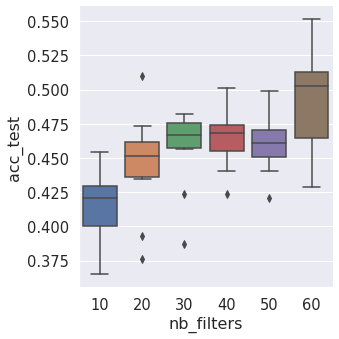

In [0]:
sns.catplot(x="nb_filters", y="acc_test", kind="box", data=df_res_filters);

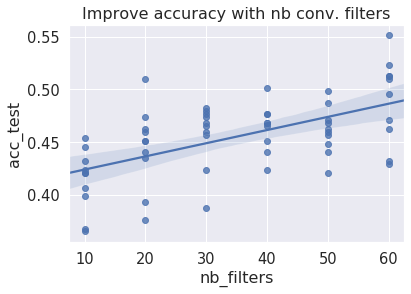

In [0]:
ax = sns.regplot(x="nb_filters", y="acc_test", data=df_res_filters);
ax.set_title("Improve accuracy with nb conv. filters");

Text(0.5, 1.0, 'Increase of time with number of conv. filters')

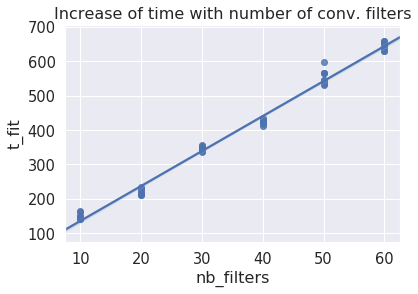

In [0]:
ax = sns.regplot(x="nb_filters", y="t_fit", data=df_res_filters);
ax.set_title("Increase of time with number of conv. filters")

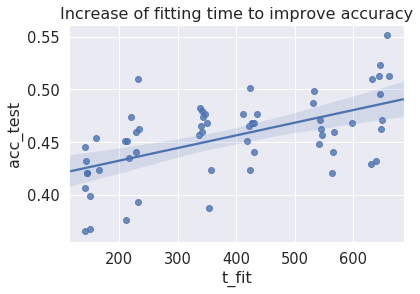

In [0]:
ax = sns.regplot(y="acc_test", x="t_fit", data=df_res_filters);
ax.set_title('Increase of fitting time to improve accuracy');

In [0]:
nb_splits = df_res_filters["nb_try"].nunique()
def confid_interv(value):
  return 1.96*np.std(value)/np.sqrt(nb_splits)
df_filters = df_res_filters.pivot_table(values=["acc_test",	"acc_train", 
                                                "t_fit",	"t_pred"],
                           index="nb_filters", aggfunc={np.mean, confid_interv})
df_filters

acc_test               acc_train                   t_fit  \
           confid_interv      mean confid_interv      mean confid_interv   
nb_filters                                                                 
10              0.017474  0.413370      0.060389  0.747333      4.978048   
20              0.022534  0.445125      0.054662  0.854333      5.622294   
30              0.017478  0.457103      0.116197  0.832667      4.008194   
40              0.012599  0.463788      0.054777  0.927333      3.984650   
50              0.013153  0.461281      0.058212  0.933667     11.728110   
60              0.023691  0.489972      0.007169  0.974667      5.836890   

                              t_pred            
                  mean confid_interv      mean  
nb_filters                                      
10          148.402486      0.053004  0.789478  
20          223.066103      0.087604  1.253220  
30          344.686944      0.051149  1.750084  
40          425.074499      0.037158  2.142808  
50          553.431661      0.048583  2.713446  
60          645.150578      0.082011  3.274829

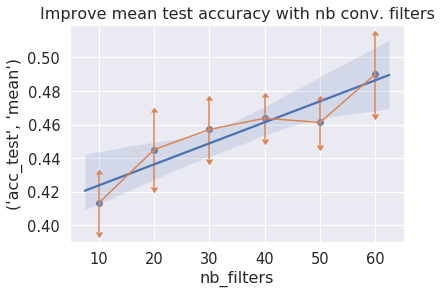

In [0]:
df_filters["nb_filters"] = df_filters.index
ax = sns.regplot(x=df_filters["nb_filters"] , y=df_filters[("acc_test","mean")]);
ax.set_title("Improve mean test accuracy with nb conv. filters");
plt.errorbar(df_filters["nb_filters"], df_filters[("acc_test","mean")], 
             yerr=df_filters[("acc_test","confid_interv")], uplims=True, 
             lolims=True);

#### Conclusion

Improvement with nb filters for range : 10->60 filters

### Loop over nb nodes FC / 60 conv filters / glorot uniform random (10 runs)

In [0]:
print("Loading from disk df_results...")
df_results = joblib.load(path_df_results)

In [0]:
df_res_nodes = None
list_nb_nodes = []
list_nb_try = []
nb_filters = 60
# loop on nb filter to check if accuracy is better and memory not saturated
for nb_nodes in [50, 100, 150, 200, 250, 300]:
  print("nb_nodes: ", nb_nodes)
  for nb_try in range(0, 10):
    print("nb_try: ", nb_try)
    list_nb_nodes.append(nb_nodes)
    list_nb_try.append(nb_try)
    my_VGG16_03 = Sequential()  # Création d'un réseau de neurones vide 
    my_VGG16_03.name = 'my_VGG16_03_{}filt_{}nod_{}'.format(nb_filters, 
                                                            nb_nodes,
                                                            nb_try)  
    # Ajout de la première couche de convolution, suivie d'une couche ReLU
    my_VGG16_03.add(Conv2D(nb_filters, kernel_size=3, strides=1, 
                       input_shape=(224, 224, 3),
                       padding='same', activation='relu'))
    my_VGG16_03.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # test
    # Ajout de la deuxième couche de convolution, suivie  d'une couche ReLU
    my_VGG16_03.add(Conv2D(nb_filters, kernel_size=3, strides=1, padding='same', 
                       activation='relu'))
    # Ajout de la première couche de pooling
    my_VGG16_03.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # test
    my_VGG16_03.add(Flatten())  # Conversion des matrices 3D en vecteur 1D
    # Ajout de la première couche fully-connected, suivie d'une couche ReLU
    my_VGG16_03.add(Dense(nb_nodes, activation='relu'))
    # Ajout de la dernière couche fully-connected qui permet de classifier
    my_VGG16_03.add(Dense(nb_breeds, activation='softmax'))
    print(my_VGG16_03.summary())
    # optimizer
    sgd_2 = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True) 
    # compile model
    my_VGG16_03.compile(loss="categorical_crossentropy", optimizer=sgd_2, 
                 metrics=["accuracy"])
    # prepare training
    epochs = 100
    batch_size = None
    t_fit_0 = time.time()
    # fitting
    model_info_3 = my_VGG16_03.fit(X_train, Y_train, epochs=epochs, 
                             batch_size=batch_size, verbose=2,
                             validation_data=(X_test, Y_test))
    t_fit_1 = time.time()
    print("Timing: ", t_fit_1 - t_fit_0)

    # plot results at each iterations
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(1,3,1)
    ax1.plot(range(0, len(model_info_3.history["acc"])), 
         model_info_3.history["acc"], 'o-')
    ax1.set_xlabel("epochs [-]")
    ax1.set_ylabel("accuracy [-]")
    ax2 = fig.add_subplot(1,3,2)
    ax2.set_xlabel("epochs [-]")
    ax2.set_ylabel("loss [-]")
    ax2.plot(range(0, len(model_info_3.history['loss'])), 
         model_info_3.history["loss"], 'ro-')
    ax3 = fig.add_subplot(1,3,3)
    ax3.set_xlabel("epochs [-]")
    ax3.set_ylabel("acc test [-]")
    ax3.plot(range(0, len(model_info_3.history['val_acc'])), 
         model_info_3.history["val_acc"], 'ro-')

    # NO save
    #my_VGG16_03.save(path_data + 'my_VGG16_03_{}filt.h5'.format(nb_filters))

    # predict as binary labels
    t_pred_0 = time.time()
    Y_train_pred = my_VGG16_03.predict(X_train)
    t_pred_1 = time.time()
    # predict as binary labels
    t_pred_2 = time.time()
    Y_test_pred = my_VGG16_03.predict(X_test)
    t_pred_3 = time.time()

    series_scores = evaluate_mdl_scorings(Y_train, Y_train_pred, 
                                      Y_test, Y_test_pred, 
    timing_fit=t_fit_1 - t_fit_0, 
      timing_pred=t_pred_3-t_pred_2+t_pred_1-t_pred_0)

    df_res_nodes = add_score(df_res_nodes, series_scores, my_VGG16_03.name)

    # save results
    joblib.dump(df_res_nodes, path_data + 'df_res_nodes.pkl', compress=True)
    print("df_res_nodes Saved here:\n{}".\
          format(path_data + 'df_res_nodes.pkl'))
    
    df_res_nodes["nb_nodes"] = list_nb_nodes
    df_res_nodes["nb_try"] = list_nb_try

# save results
joblib.dump(df_res_nodes, path_data + 'df_res_nodes.pkl', compress=True)
print("df_res_nodes Saved here:\n{}".\
          format(path_data + 'df_res_nodes.pkl'))
    
df_res_nodes

nb_nodes:  50
nb_try:  0
Model: "my_VGG16_03_60filt_50nod_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 188160)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                9408050   
_________________________________________________________________
dense_4 (Dense)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 6s - loss: 10.2346 - acc: 0.3333 - val_loss: 7.0524 - val_acc: 0.3538
Epoch 2/100
 - 6s - loss: 7.7754 - acc: 0.3667 - val_loss: 6.3543 - val_acc: 0.4234
Epoch 3/100
 - 6s - loss: 6.4301 - acc: 0.4300 - val_loss: 5.6307 - val_acc: 0.4262
Epoch 4/100
 - 6s - loss: 4.2932 - acc: 0.5267 - val_loss: 4.7569 - val_acc: 0.4178
Epoch 5/100
 - 6s - loss: 2.9247 - acc: 0.6233 - val_loss: 5.1089 - val_acc: 0.4540
Epoch 6/100
 - 6s - loss: 2.4040 - acc: 0.6500 - val_loss: 3.8778 - val_acc: 0.4373
Epoch 7/100
 - 6s - loss: 1.3085 - acc: 0.7433 - val_loss: 3.7281 - val_acc: 0.4206
Epoch 8/100
 - 6s - loss: 0.9473 - acc: 0.7733 - val_loss: 3.6388 - val_acc: 0.4708
Epoch 9/100
 - 6s - loss: 0.6094 - acc: 0.8467 - val_loss: 3.5863 - val_acc: 0.4373
Epoch 10/100
 - 6s - loss: 0.4435 - acc: 0.8833 - val_loss: 3.5541 - val_acc: 0.4290
Epoch 11/100
 - 6s - loss: 0.2900 - acc: 0.9300 - val_loss: 3.5113 - val_acc: 0.4401
Epoch 12/100
 - 6s - loss: 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 6s - loss: 7.0562 - acc: 0.3533 - val_loss: 7.7323 - val_acc: 0.3175
Epoch 2/100
 - 6s - loss: 4.8684 - acc: 0.4700 - val_loss: 6.3265 - val_acc: 0.3983
Epoch 3/100
 - 6s - loss: 3.1407 - acc: 0.6067 - val_loss: 4.8663 - val_acc: 0.4067
Epoch 4/100
 - 6s - loss: 1.9283 - acc: 0.6867 - val_loss: 4.5811 - val_acc: 0.4206
Epoch 5/100
 - 6s - loss: 1.2859 - acc: 0.7767 - val_loss: 4.7601 - val_acc: 0.4150
Epoch 6/100
 - 6s - loss: 0.8918 - acc: 0.8300 - val_loss: 4.6354 - val_acc: 0.4290
Epoch 7/100
 - 6s - loss: 0.6589 - acc: 0.8700 - val_loss: 4.2639 - val_acc: 0.4513
Epoch 8/100
 - 6s - loss: 0.4047 - acc: 0.9300 - val_loss: 4.3024 - val_acc: 0.4373
Epoch 9/100
 - 6s - loss: 0.2911 - acc: 0.9533 - val_loss: 4.2577 - val_acc: 0.4373
Epoch 10/100
 - 6s - loss: 0.2211 - acc: 0.9800 - val_loss: 4.2848 - val_acc: 0.4429
Epoch 11/100
 - 6s - loss: 0.1936 - acc: 0.9867 - val_loss: 4.2836 - val_acc: 0.4485
Epoch 12/100
 - 6s - loss: 0

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 6s - loss: 6.8295 - acc: 0.3400 - val_loss: 5.3356 - val_acc: 0.4067
Epoch 2/100
 - 6s - loss: 4.0458 - acc: 0.4600 - val_loss: 4.9833 - val_acc: 0.4123
Epoch 3/100
 - 6s - loss: 2.4786 - acc: 0.6067 - val_loss: 3.8094 - val_acc: 0.4708
Epoch 4/100
 - 6s - loss: 1.4588 - acc: 0.7067 - val_loss: 3.5936 - val_acc: 0.4373
Epoch 5/100
 - 6s - loss: 0.9491 - acc: 0.8100 - val_loss: 3.4612 - val_acc: 0.4178
Epoch 6/100
 - 6s - loss: 0.6796 - acc: 0.8600 - val_loss: 3.3349 - val_acc: 0.4401
Epoch 7/100
 - 6s - loss: 0.4976 - acc: 0.9133 - val_loss: 3.2401 - val_acc: 0.4401
Epoch 8/100
 - 6s - loss: 0.3894 - acc: 0.9333 - val_loss: 3.1786 - val_acc: 0.4429
Epoch 9/100
 - 6s - loss: 0.2992 - acc: 0.9400 - val_loss: 3.2412 - val_acc: 0.4457
Epoch 10/100
 - 6s - loss: 0.2422 - acc: 0.9600 - val_loss: 3.2854 - val_acc: 0.4485
Epoch 11/100
 - 6s - loss: 0.1938 - acc: 0.9633 - val_loss: 3.2622 - val_acc: 0.4568
Epoch 12/100
 - 6s - loss: 0

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 7s - loss: 8.6785 - acc: 0.3500 - val_loss: 7.3544 - val_acc: 0.3203
Epoch 2/100
 - 6s - loss: 6.8436 - acc: 0.4067 - val_loss: 6.3573 - val_acc: 0.3928
Epoch 3/100
 - 6s - loss: 5.0190 - acc: 0.4967 - val_loss: 6.1707 - val_acc: 0.4150
Epoch 4/100
 - 6s - loss: 2.9570 - acc: 0.6500 - val_loss: 5.0974 - val_acc: 0.4763
Epoch 5/100
 - 6s - loss: 2.1302 - acc: 0.7367 - val_loss: 5.2539 - val_acc: 0.4791
Epoch 6/100
 - 6s - loss: 1.5178 - acc: 0.8000 - val_loss: 5.3181 - val_acc: 0.4568
Epoch 7/100
 - 6s - loss: 1.3704 - acc: 0.7933 - val_loss: 5.2152 - val_acc: 0.4847
Epoch 8/100
 - 6s - loss: 1.0063 - acc: 0.8633 - val_loss: 4.4928 - val_acc: 0.4819
Epoch 9/100
 - 6s - loss: 0.6667 - acc: 0.8967 - val_loss: 4.7465 - val_acc: 0.4847
Epoch 10/100
 - 6s - loss: 0.5122 - acc: 0.9233 - val_loss: 4.5879 - val_acc: 0.4958
Epoch 11/100
 - 6s - loss: 0.3958 - acc: 0.9500 - val_loss: 4.4318 - val_acc: 0.4903
Epoch 12/100
 - 6s - loss: 0

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Model: "my_VGG16_03_60filt_50nod_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 188160)            0         
_________________________________________________________________
dense_15 (Dense)             (None, 50)                9408050   
_________________________________________________________________
dense_16 (Dense)             (None, 3)  

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 7s - loss: 7.7340 - acc: 0.3200 - val_loss: 5.5417 - val_acc: 0.3426
Epoch 2/100
 - 6s - loss: 4.5145 - acc: 0.4033 - val_loss: 4.4079 - val_acc: 0.3900
Epoch 3/100
 - 6s - loss: 2.8335 - acc: 0.4667 - val_loss: 3.4977 - val_acc: 0.4429
Epoch 4/100
 - 6s - loss: 1.8547 - acc: 0.5333 - val_loss: 3.0764 - val_acc: 0.4262
Epoch 5/100
 - 6s - loss: 1.2362 - acc: 0.6367 - val_loss: 2.4268 - val_acc: 0.4178
Epoch 6/100
 - 6s - loss: 0.9807 - acc: 0.6633 - val_loss: 2.2589 - val_acc: 0.4318
Epoch 7/100
 - 6s - loss: 0.7622 - acc: 0.7200 - val_loss: 2.5678 - val_acc: 0.4457
Epoch 8/100
 - 6s - loss: 0.5758 - acc: 0.7600 - val_loss: 2.3771 - val_acc: 0.4401
Epoch 9/100
 - 6s - loss: 0.4620 - acc: 0.8200 - val_loss: 2.2736 - val_acc: 0.4373
Epoch 10/100
 - 6s - loss: 0.3871 - acc: 0.8467 - val_loss: 2.4847 - val_acc: 0.4568
Epoch 11/100
 - 6s - loss: 0.3156 - acc: 0.8700 - val_loss: 2.3313 - val_acc: 0.4513
Epoch 12/100
 - 6s - loss: 0

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 7s - loss: 8.9944 - acc: 0.3700 - val_loss: 7.2286 - val_acc: 0.3733
Epoch 2/100
 - 6s - loss: 6.1436 - acc: 0.3700 - val_loss: 5.1877 - val_acc: 0.3872
Epoch 3/100
 - 6s - loss: 3.8045 - acc: 0.4633 - val_loss: 5.0623 - val_acc: 0.3788
Epoch 4/100
 - 6s - loss: 2.3186 - acc: 0.5867 - val_loss: 5.3475 - val_acc: 0.4067
Epoch 5/100
 - 6s - loss: 1.5562 - acc: 0.6400 - val_loss: 3.5023 - val_acc: 0.4513
Epoch 6/100
 - 6s - loss: 1.0286 - acc: 0.7233 - val_loss: 3.2296 - val_acc: 0.4596
Epoch 7/100
 - 6s - loss: 0.6560 - acc: 0.8333 - val_loss: 3.1458 - val_acc: 0.4596
Epoch 8/100
 - 6s - loss: 0.4283 - acc: 0.8967 - val_loss: 3.1457 - val_acc: 0.4791
Epoch 9/100
 - 6s - loss: 0.3465 - acc: 0.9033 - val_loss: 3.1850 - val_acc: 0.4735
Epoch 10/100
 - 6s - loss: 0.2515 - acc: 0.9400 - val_loss: 3.1962 - val_acc: 0.4735
Epoch 11/100
 - 6s - loss: 0.1947 - acc: 0.9600 - val_loss: 3.1307 - val_acc: 0.4624
Epoch 12/100
 - 6s - loss: 0

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 7s - loss: 8.8033 - acc: 0.3300 - val_loss: 9.0102 - val_acc: 0.3287
Epoch 2/100
 - 6s - loss: 7.4945 - acc: 0.3900 - val_loss: 8.1436 - val_acc: 0.3621
Epoch 3/100
 - 6s - loss: 4.9528 - acc: 0.5400 - val_loss: 6.3819 - val_acc: 0.3760
Epoch 4/100
 - 6s - loss: 3.8737 - acc: 0.6033 - val_loss: 6.1037 - val_acc: 0.4095
Epoch 5/100
 - 6s - loss: 2.8294 - acc: 0.6733 - val_loss: 5.3618 - val_acc: 0.4401
Epoch 6/100
 - 6s - loss: 1.9367 - acc: 0.7433 - val_loss: 4.7976 - val_acc: 0.4540
Epoch 7/100
 - 6s - loss: 1.3683 - acc: 0.8033 - val_loss: 4.7156 - val_acc: 0.4735
Epoch 8/100
 - 6s - loss: 1.1017 - acc: 0.8367 - val_loss: 4.7119 - val_acc: 0.4568
Epoch 9/100
 - 6s - loss: 0.8100 - acc: 0.8933 - val_loss: 4.6090 - val_acc: 0.4735
Epoch 10/100
 - 6s - loss: 0.6750 - acc: 0.9267 - val_loss: 4.5841 - val_acc: 0.4708
Epoch 11/100
 - 6s - loss: 0.6019 - acc: 0.9500 - val_loss: 4.4342 - val_acc: 0.4652
Epoch 12/100
 - 6s - loss: 0

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 7s - loss: 7.3134 - acc: 0.3833 - val_loss: 5.9840 - val_acc: 0.4345
Epoch 2/100
 - 6s - loss: 7.4595 - acc: 0.4033 - val_loss: 6.3759 - val_acc: 0.4457
Epoch 3/100
 - 6s - loss: 5.3077 - acc: 0.5133 - val_loss: 5.9816 - val_acc: 0.4318
Epoch 4/100
 - 6s - loss: 4.0782 - acc: 0.5533 - val_loss: 5.4302 - val_acc: 0.4540
Epoch 5/100
 - 6s - loss: 3.1182 - acc: 0.6200 - val_loss: 5.5233 - val_acc: 0.4485
Epoch 6/100
 - 6s - loss: 2.0077 - acc: 0.7233 - val_loss: 4.1925 - val_acc: 0.5014
Epoch 7/100
 - 6s - loss: 1.4384 - acc: 0.7767 - val_loss: 3.9948 - val_acc: 0.4791
Epoch 8/100
 - 6s - loss: 1.0493 - acc: 0.8500 - val_loss: 4.1340 - val_acc: 0.4708
Epoch 9/100
 - 6s - loss: 0.8304 - acc: 0.9033 - val_loss: 3.8736 - val_acc: 0.4652
Epoch 10/100
 - 6s - loss: 0.6583 - acc: 0.9333 - val_loss: 3.8239 - val_acc: 0.4680
Epoch 11/100
 - 6s - loss: 0.5750 - acc: 0.9467 - val_loss: 3.8145 - val_acc: 0.4652
Epoch 12/100
 - 6s - loss: 0

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 7s - loss: 8.7385 - acc: 0.3333 - val_loss: 7.3119 - val_acc: 0.3705
Epoch 2/100
 - 6s - loss: 6.7655 - acc: 0.3767 - val_loss: 6.7971 - val_acc: 0.4123
Epoch 3/100
 - 6s - loss: 4.8917 - acc: 0.5133 - val_loss: 7.7883 - val_acc: 0.3733
Epoch 4/100
 - 6s - loss: 4.3618 - acc: 0.5667 - val_loss: 5.4263 - val_acc: 0.4485
Epoch 5/100
 - 6s - loss: 2.6879 - acc: 0.6967 - val_loss: 5.6166 - val_acc: 0.4596
Epoch 6/100
 - 6s - loss: 1.9833 - acc: 0.7567 - val_loss: 5.0523 - val_acc: 0.4708
Epoch 7/100
 - 6s - loss: 1.6402 - acc: 0.7900 - val_loss: 4.6167 - val_acc: 0.4930
Epoch 8/100
 - 6s - loss: 1.1758 - acc: 0.8667 - val_loss: 4.6285 - val_acc: 0.4903
Epoch 9/100
 - 6s - loss: 0.9372 - acc: 0.9000 - val_loss: 4.4923 - val_acc: 0.5181
Epoch 10/100
 - 6s - loss: 0.8539 - acc: 0.8833 - val_loss: 4.2965 - val_acc: 0.5292
Epoch 11/100
 - 6s - loss: 0.6697 - acc: 0.9333 - val_loss: 4.5760 - val_acc: 0.5125
Epoch 12/100
 - 6s - loss: 0

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 8s - loss: 7.9991 - acc: 0.3633 - val_loss: 7.3269 - val_acc: 0.3259
Epoch 2/100
 - 6s - loss: 5.7983 - acc: 0.4300 - val_loss: 6.2176 - val_acc: 0.3872
Epoch 3/100
 - 7s - loss: 4.0785 - acc: 0.5733 - val_loss: 5.6458 - val_acc: 0.4429
Epoch 4/100
 - 6s - loss: 2.6718 - acc: 0.6433 - val_loss: 6.0583 - val_acc: 0.4262
Epoch 5/100
 - 6s - loss: 1.8191 - acc: 0.7367 - val_loss: 4.6643 - val_acc: 0.4568
Epoch 6/100
 - 6s - loss: 1.2918 - acc: 0.8067 - val_loss: 6.1877 - val_acc: 0.4178
Epoch 7/100
 - 6s - loss: 0.8862 - acc: 0.8533 - val_loss: 4.6985 - val_acc: 0.4540
Epoch 8/100
 - 6s - loss: 0.6394 - acc: 0.9033 - val_loss: 4.3477 - val_acc: 0.4791
Epoch 9/100
 - 6s - loss: 0.5065 - acc: 0.9300 - val_loss: 4.4699 - val_acc: 0.4485
Epoch 10/100
 - 6s - loss: 0.4513 - acc: 0.9667 - val_loss: 4.4109 - val_acc: 0.4763
Epoch 11/100
 - 6s - loss: 0.4395 - acc: 0.9700 - val_loss: 4.4231 - val_acc: 0.4708
Epoch 12/100
 - 6s - loss: 0

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 8s - loss: 6.1626 - acc: 0.4000 - val_loss: 6.3551 - val_acc: 0.3816
Epoch 2/100
 - 6s - loss: 4.3666 - acc: 0.5067 - val_loss: 5.7825 - val_acc: 0.3705
Epoch 3/100
 - 6s - loss: 2.8046 - acc: 0.6400 - val_loss: 4.7336 - val_acc: 0.4708
Epoch 4/100
 - 6s - loss: 2.0742 - acc: 0.7267 - val_loss: 4.4858 - val_acc: 0.4652
Epoch 5/100
 - 6s - loss: 1.5226 - acc: 0.8167 - val_loss: 4.7014 - val_acc: 0.4735
Epoch 6/100
 - 6s - loss: 1.1595 - acc: 0.8433 - val_loss: 4.6564 - val_acc: 0.4735
Epoch 7/100
 - 6s - loss: 1.0780 - acc: 0.8700 - val_loss: 4.7236 - val_acc: 0.4429
Epoch 8/100
 - 7s - loss: 0.8583 - acc: 0.9100 - val_loss: 4.3551 - val_acc: 0.4680
Epoch 9/100
 - 6s - loss: 0.7488 - acc: 0.9300 - val_loss: 4.3910 - val_acc: 0.4485
Epoch 10/100
 - 6s - loss: 0.6926 - acc: 0.9400 - val_loss: 4.3669 - val_acc: 0.4708
Epoch 11/100
 - 6s - loss: 0.6400 - acc: 0.9500 - val_loss: 4.3419 - val_acc: 0.4624
Epoch 12/100
 - 6s - loss: 0

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 8s - loss: 8.5561 - acc: 0.3100 - val_loss: 8.2735 - val_acc: 0.3649
Epoch 2/100
 - 6s - loss: 7.3086 - acc: 0.4167 - val_loss: 8.1255 - val_acc: 0.4011
Epoch 3/100
 - 6s - loss: 6.6558 - acc: 0.4967 - val_loss: 8.2719 - val_acc: 0.3649
Epoch 4/100
 - 6s - loss: 6.2530 - acc: 0.5367 - val_loss: 8.0062 - val_acc: 0.3816
Epoch 5/100
 - 6s - loss: 6.0374 - acc: 0.5867 - val_loss: 7.8957 - val_acc: 0.3928
Epoch 6/100
 - 6s - loss: 5.8881 - acc: 0.6167 - val_loss: 7.9352 - val_acc: 0.3900
Epoch 7/100
 - 6s - loss: 5.7997 - acc: 0.6200 - val_loss: 7.9560 - val_acc: 0.3844
Epoch 8/100
 - 6s - loss: 5.5530 - acc: 0.6300 - val_loss: 7.3681 - val_acc: 0.3677
Epoch 9/100
 - 6s - loss: 4.0614 - acc: 0.6033 - val_loss: 5.3057 - val_acc: 0.3900
Epoch 10/100
 - 6s - loss: 2.5852 - acc: 0.6267 - val_loss: 4.9977 - val_acc: 0.4234
Epoch 11/100
 - 6s - loss: 1.6109 - acc: 0.7233 - val_loss: 4.9219 - val_acc: 0.4206
Epoch 12/100
 - 6s - loss: 0

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 8s - loss: 7.1707 - acc: 0.3133 - val_loss: 5.7446 - val_acc: 0.4290
Epoch 2/100
 - 6s - loss: 5.1595 - acc: 0.4333 - val_loss: 5.7821 - val_acc: 0.3844
Epoch 3/100
 - 6s - loss: 4.1748 - acc: 0.5600 - val_loss: 5.5619 - val_acc: 0.4485
Epoch 4/100
 - 6s - loss: 3.1379 - acc: 0.6033 - val_loss: 4.4619 - val_acc: 0.4763
Epoch 5/100
 - 6s - loss: 2.2276 - acc: 0.7067 - val_loss: 4.3856 - val_acc: 0.4763
Epoch 6/100
 - 6s - loss: 1.6126 - acc: 0.7800 - val_loss: 4.0811 - val_acc: 0.5014
Epoch 7/100
 - 6s - loss: 1.2152 - acc: 0.8500 - val_loss: 4.0815 - val_acc: 0.5181
Epoch 8/100
 - 6s - loss: 0.9771 - acc: 0.8700 - val_loss: 4.1725 - val_acc: 0.4958
Epoch 9/100
 - 6s - loss: 0.7471 - acc: 0.9067 - val_loss: 4.1989 - val_acc: 0.4847
Epoch 10/100
 - 6s - loss: 0.6269 - acc: 0.9333 - val_loss: 4.0922 - val_acc: 0.4847
Epoch 11/100
 - 6s - loss: 0.5561 - acc: 0.9567 - val_loss: 4.1099 - val_acc: 0.5042
Epoch 12/100
 - 6s - loss: 0

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 8s - loss: 7.8173 - acc: 0.3667 - val_loss: 8.3734 - val_acc: 0.3510
Epoch 2/100
 - 6s - loss: 7.3360 - acc: 0.3967 - val_loss: 8.5887 - val_acc: 0.3649
Epoch 3/100
 - 6s - loss: 6.7956 - acc: 0.4733 - val_loss: 8.7231 - val_acc: 0.3621
Epoch 4/100
 - 6s - loss: 6.3620 - acc: 0.5100 - val_loss: 6.9271 - val_acc: 0.3983
Epoch 5/100
 - 6s - loss: 4.0669 - acc: 0.5533 - val_loss: 5.5115 - val_acc: 0.4290
Epoch 6/100
 - 6s - loss: 2.3253 - acc: 0.6667 - val_loss: 5.7845 - val_acc: 0.3872
Epoch 7/100
 - 6s - loss: 1.5403 - acc: 0.7467 - val_loss: 4.4423 - val_acc: 0.4624
Epoch 8/100
 - 6s - loss: 0.8740 - acc: 0.8533 - val_loss: 4.3766 - val_acc: 0.4791
Epoch 9/100
 - 6s - loss: 0.5758 - acc: 0.8900 - val_loss: 4.3638 - val_acc: 0.4568
Epoch 10/100
 - 6s - loss: 0.4109 - acc: 0.9500 - val_loss: 4.2915 - val_acc: 0.4791
Epoch 11/100
 - 6s - loss: 0.3595 - acc: 0.9700 - val_loss: 4.3404 - val_acc: 0.4708
Epoch 12/100
 - 6s - loss: 0

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 8s - loss: 7.1328 - acc: 0.3567 - val_loss: 6.2690 - val_acc: 0.4095
Epoch 2/100
 - 6s - loss: 4.6687 - acc: 0.5100 - val_loss: 5.6334 - val_acc: 0.4178
Epoch 3/100
 - 6s - loss: 3.4478 - acc: 0.6200 - val_loss: 5.2523 - val_acc: 0.4401
Epoch 4/100
 - 6s - loss: 2.3519 - acc: 0.7433 - val_loss: 5.2204 - val_acc: 0.4652
Epoch 5/100
 - 6s - loss: 1.8217 - acc: 0.8033 - val_loss: 5.2947 - val_acc: 0.4373
Epoch 6/100
 - 6s - loss: 1.4895 - acc: 0.8400 - val_loss: 4.9828 - val_acc: 0.4791
Epoch 7/100
 - 6s - loss: 1.2019 - acc: 0.8900 - val_loss: 4.9942 - val_acc: 0.4652
Epoch 8/100
 - 6s - loss: 1.0356 - acc: 0.9100 - val_loss: 4.8328 - val_acc: 0.4596
Epoch 9/100
 - 6s - loss: 0.8901 - acc: 0.9133 - val_loss: 4.6948 - val_acc: 0.4596
Epoch 10/100
 - 6s - loss: 0.7005 - acc: 0.9433 - val_loss: 5.0410 - val_acc: 0.4095
Epoch 11/100
 - 6s - loss: 0.6545 - acc: 0.9133 - val_loss: 4.7056 - val_acc: 0.4373
Epoch 12/100
 - 6s - loss: 0

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 8s - loss: 6.9479 - acc: 0.3400 - val_loss: 6.4612 - val_acc: 0.4206
Epoch 2/100
 - 6s - loss: 4.9542 - acc: 0.5233 - val_loss: 5.8786 - val_acc: 0.4123
Epoch 3/100
 - 6s - loss: 3.6165 - acc: 0.6100 - val_loss: 6.3613 - val_acc: 0.3872
Epoch 4/100
 - 6s - loss: 2.5116 - acc: 0.7167 - val_loss: 5.7378 - val_acc: 0.4262
Epoch 5/100
 - 6s - loss: 1.8945 - acc: 0.7867 - val_loss: 5.2612 - val_acc: 0.4708
Epoch 6/100
 - 6s - loss: 1.5942 - acc: 0.8567 - val_loss: 5.0946 - val_acc: 0.4513
Epoch 7/100
 - 6s - loss: 1.3906 - acc: 0.9000 - val_loss: 4.8787 - val_acc: 0.4540
Epoch 8/100
 - 6s - loss: 1.2940 - acc: 0.9067 - val_loss: 4.7032 - val_acc: 0.4791
Epoch 9/100
 - 6s - loss: 1.1672 - acc: 0.9200 - val_loss: 4.6349 - val_acc: 0.4791
Epoch 10/100
 - 6s - loss: 1.1086 - acc: 0.9133 - val_loss: 4.5879 - val_acc: 0.4624
Epoch 11/100
 - 6s - loss: 1.0284 - acc: 0.9267 - val_loss: 4.6618 - val_acc: 0.4652
Epoch 12/100
 - 6s - loss: 0

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 8s - loss: 6.7927 - acc: 0.3067 - val_loss: 5.8540 - val_acc: 0.3677
Epoch 2/100
 - 6s - loss: 4.4850 - acc: 0.4800 - val_loss: 5.5247 - val_acc: 0.3928
Epoch 3/100
 - 6s - loss: 2.8407 - acc: 0.6033 - val_loss: 5.3734 - val_acc: 0.3816
Epoch 4/100
 - 6s - loss: 1.7499 - acc: 0.7167 - val_loss: 4.9829 - val_acc: 0.4178
Epoch 5/100
 - 6s - loss: 1.1346 - acc: 0.7933 - val_loss: 4.8895 - val_acc: 0.4123
Epoch 6/100
 - 6s - loss: 0.7345 - acc: 0.8667 - val_loss: 4.7605 - val_acc: 0.4011
Epoch 7/100
 - 6s - loss: 0.4964 - acc: 0.9267 - val_loss: 4.6779 - val_acc: 0.4234
Epoch 8/100
 - 6s - loss: 0.4111 - acc: 0.9567 - val_loss: 4.7549 - val_acc: 0.4150
Epoch 9/100
 - 6s - loss: 0.3565 - acc: 0.9700 - val_loss: 4.7684 - val_acc: 0.4262
Epoch 10/100
 - 6s - loss: 0.3124 - acc: 0.9767 - val_loss: 4.7506 - val_acc: 0.4123
Epoch 11/100
 - 6s - loss: 0.2919 - acc: 0.9833 - val_loss: 4.7491 - val_acc: 0.4095
Epoch 12/100
 - 6s - loss: 0

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 8s - loss: 8.2188 - acc: 0.3400 - val_loss: 6.8692 - val_acc: 0.3677
Epoch 2/100
 - 6s - loss: 5.7406 - acc: 0.4033 - val_loss: 5.8100 - val_acc: 0.3816
Epoch 3/100
 - 6s - loss: 4.0462 - acc: 0.5500 - val_loss: 5.2145 - val_acc: 0.4345
Epoch 4/100
 - 6s - loss: 2.7395 - acc: 0.6300 - val_loss: 5.0102 - val_acc: 0.4568
Epoch 5/100
 - 6s - loss: 1.9278 - acc: 0.7033 - val_loss: 4.5360 - val_acc: 0.4652
Epoch 6/100
 - 7s - loss: 1.1119 - acc: 0.7900 - val_loss: 5.0362 - val_acc: 0.4373
Epoch 7/100
 - 7s - loss: 0.7699 - acc: 0.8733 - val_loss: 4.5123 - val_acc: 0.4568
Epoch 8/100
 - 7s - loss: 0.5304 - acc: 0.9133 - val_loss: 4.7563 - val_acc: 0.4708
Epoch 9/100
 - 7s - loss: 0.5461 - acc: 0.8933 - val_loss: 4.4688 - val_acc: 0.4568
Epoch 10/100
 - 7s - loss: 0.3326 - acc: 0.9567 - val_loss: 4.4684 - val_acc: 0.4485
Epoch 11/100
 - 6s - loss: 0.2593 - acc: 0.9700 - val_loss: 4.3899 - val_acc: 0.4457
Epoch 12/100
 - 6s - loss: 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_nodes Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_nodes.pkl
nb_try:  1
Model: "my_VGG16_03_60filt_150nod_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_45 (Dense)             (None, 150)            

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 8s - loss: 8.3697 - acc: 0.3100 - val_loss: 8.3364 - val_acc: 0.3370
Epoch 2/100
 - 7s - loss: 6.6544 - acc: 0.4300 - val_loss: 6.4164 - val_acc: 0.4150
Epoch 3/100
 - 7s - loss: 4.8953 - acc: 0.5100 - val_loss: 6.3818 - val_acc: 0.3733
Epoch 4/100
 - 7s - loss: 3.1764 - acc: 0.6467 - val_loss: 5.3536 - val_acc: 0.3872
Epoch 5/100
 - 7s - loss: 2.0015 - acc: 0.7367 - val_loss: 4.9737 - val_acc: 0.4234
Epoch 6/100
 - 7s - loss: 1.3377 - acc: 0.8133 - val_loss: 4.8344 - val_acc: 0.4513
Epoch 7/100
 - 7s - loss: 0.9249 - acc: 0.8833 - val_loss: 4.8581 - val_acc: 0.4401
Epoch 8/100
 - 7s - loss: 0.6659 - acc: 0.9300 - val_loss: 4.7481 - val_acc: 0.4485
Epoch 9/100
 - 7s - loss: 0.5708 - acc: 0.9467 - val_loss: 4.8089 - val_acc: 0.4401
Epoch 10/100
 - 7s - loss: 0.4997 - acc: 0.9600 - val_loss: 4.7859 - val_acc: 0.4429
Epoch 11/100
 - 7s - loss: 0.4546 - acc: 0.9700 - val_loss: 4.8682 - val_acc: 0.4345
Epoch 12/100
 - 7s - loss: 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_nodes Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_nodes.pkl
nb_try:  2
Model: "my_VGG16_03_60filt_150nod_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_47 (Dense)             (None, 150)            

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 8s - loss: 7.3580 - acc: 0.3433 - val_loss: 8.4241 - val_acc: 0.2953
Epoch 2/100
 - 6s - loss: 5.6386 - acc: 0.4633 - val_loss: 6.7027 - val_acc: 0.3538
Epoch 3/100
 - 6s - loss: 3.5958 - acc: 0.6133 - val_loss: 6.4237 - val_acc: 0.3705
Epoch 4/100
 - 6s - loss: 2.4766 - acc: 0.6967 - val_loss: 5.6976 - val_acc: 0.4290
Epoch 5/100
 - 6s - loss: 1.9861 - acc: 0.7667 - val_loss: 5.6937 - val_acc: 0.4234
Epoch 6/100
 - 6s - loss: 1.4637 - acc: 0.8400 - val_loss: 5.5752 - val_acc: 0.4318
Epoch 7/100
 - 7s - loss: 1.1355 - acc: 0.8900 - val_loss: 5.4608 - val_acc: 0.4318
Epoch 8/100
 - 6s - loss: 0.9819 - acc: 0.9200 - val_loss: 5.4260 - val_acc: 0.4429
Epoch 9/100
 - 6s - loss: 0.8382 - acc: 0.9233 - val_loss: 5.2652 - val_acc: 0.4624
Epoch 10/100
 - 6s - loss: 0.6734 - acc: 0.9533 - val_loss: 5.2283 - val_acc: 0.4568
Epoch 11/100
 - 6s - loss: 0.6100 - acc: 0.9567 - val_loss: 5.3387 - val_acc: 0.4596
Epoch 12/100
 - 7s - loss: 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_nodes Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_nodes.pkl
nb_try:  3
Model: "my_VGG16_03_60filt_150nod_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_49 (Dense)             (None, 150)            

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 8s - loss: 8.2825 - acc: 0.3100 - val_loss: 7.2012 - val_acc: 0.3287
Epoch 2/100
 - 6s - loss: 5.8928 - acc: 0.4200 - val_loss: 5.7201 - val_acc: 0.4234
Epoch 3/100
 - 6s - loss: 3.7433 - acc: 0.5700 - val_loss: 5.3282 - val_acc: 0.4540
Epoch 4/100
 - 6s - loss: 2.6148 - acc: 0.6833 - val_loss: 5.5309 - val_acc: 0.4652
Epoch 5/100
 - 6s - loss: 1.9624 - acc: 0.7833 - val_loss: 5.6036 - val_acc: 0.4568
Epoch 6/100
 - 7s - loss: 1.6237 - acc: 0.8200 - val_loss: 5.6990 - val_acc: 0.4457
Epoch 7/100
 - 6s - loss: 1.4873 - acc: 0.8667 - val_loss: 4.8097 - val_acc: 0.4847
Epoch 8/100
 - 6s - loss: 1.2242 - acc: 0.8867 - val_loss: 4.7080 - val_acc: 0.4875
Epoch 9/100
 - 6s - loss: 1.0385 - acc: 0.9100 - val_loss: 4.9597 - val_acc: 0.4652
Epoch 10/100
 - 6s - loss: 1.0229 - acc: 0.9133 - val_loss: 4.7036 - val_acc: 0.4986
Epoch 11/100
 - 6s - loss: 0.9483 - acc: 0.9267 - val_loss: 4.8052 - val_acc: 0.4680
Epoch 12/100
 - 6s - loss: 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_nodes Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_nodes.pkl
nb_try:  4
Model: "my_VGG16_03_60filt_150nod_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_51 (Dense)             (None, 150)            

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 9s - loss: 8.7111 - acc: 0.2967 - val_loss: 8.2280 - val_acc: 0.3175
Epoch 2/100
 - 7s - loss: 7.6362 - acc: 0.3900 - val_loss: 5.9368 - val_acc: 0.4206
Epoch 3/100
 - 7s - loss: 6.0295 - acc: 0.4867 - val_loss: 5.6835 - val_acc: 0.4540
Epoch 4/100
 - 7s - loss: 4.6803 - acc: 0.5600 - val_loss: 5.2593 - val_acc: 0.4875
Epoch 5/100
 - 6s - loss: 3.7332 - acc: 0.6333 - val_loss: 5.6091 - val_acc: 0.4680
Epoch 6/100
 - 7s - loss: 2.8087 - acc: 0.6867 - val_loss: 4.8210 - val_acc: 0.4652
Epoch 7/100
 - 6s - loss: 1.8674 - acc: 0.7667 - val_loss: 5.1121 - val_acc: 0.5042
Epoch 8/100
 - 6s - loss: 1.6594 - acc: 0.7633 - val_loss: 4.6742 - val_acc: 0.4735
Epoch 9/100
 - 7s - loss: 1.1456 - acc: 0.8600 - val_loss: 4.6179 - val_acc: 0.4735
Epoch 10/100
 - 6s - loss: 0.9740 - acc: 0.8833 - val_loss: 4.6162 - val_acc: 0.4763
Epoch 11/100
 - 6s - loss: 0.7778 - acc: 0.9233 - val_loss: 4.6893 - val_acc: 0.4624
Epoch 12/100
 - 7s - loss: 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_nodes Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_nodes.pkl
nb_try:  5
Model: "my_VGG16_03_60filt_150nod_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_53 (Conv2D)           (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_53 (Dense)             (None, 150)            

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 8s - loss: 6.5030 - acc: 0.3600 - val_loss: 5.7571 - val_acc: 0.4123
Epoch 2/100
 - 7s - loss: 4.6043 - acc: 0.4500 - val_loss: 4.4970 - val_acc: 0.4150
Epoch 3/100
 - 7s - loss: 2.7182 - acc: 0.6233 - val_loss: 4.6414 - val_acc: 0.4178
Epoch 4/100
 - 6s - loss: 2.0228 - acc: 0.6900 - val_loss: 4.0421 - val_acc: 0.4624
Epoch 5/100
 - 6s - loss: 1.3755 - acc: 0.7867 - val_loss: 3.8897 - val_acc: 0.4457
Epoch 6/100
 - 7s - loss: 1.0280 - acc: 0.8467 - val_loss: 3.5606 - val_acc: 0.4513
Epoch 7/100
 - 7s - loss: 0.7631 - acc: 0.8767 - val_loss: 3.5362 - val_acc: 0.4540
Epoch 8/100
 - 6s - loss: 0.5187 - acc: 0.9167 - val_loss: 3.6528 - val_acc: 0.4457
Epoch 9/100
 - 6s - loss: 0.4252 - acc: 0.9567 - val_loss: 3.5372 - val_acc: 0.4652
Epoch 10/100
 - 6s - loss: 0.3604 - acc: 0.9667 - val_loss: 3.5039 - val_acc: 0.4791
Epoch 11/100
 - 7s - loss: 0.3027 - acc: 0.9800 - val_loss: 3.4881 - val_acc: 0.4680
Epoch 12/100
 - 7s - loss: 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_nodes Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_nodes.pkl
nb_try:  6
Model: "my_VGG16_03_60filt_150nod_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_28 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_55 (Dense)             (None, 150)            

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 8s - loss: 6.8781 - acc: 0.3833 - val_loss: 8.7277 - val_acc: 0.3064
Epoch 2/100
 - 7s - loss: 5.4395 - acc: 0.4233 - val_loss: 5.3689 - val_acc: 0.3705
Epoch 3/100
 - 7s - loss: 3.0591 - acc: 0.5867 - val_loss: 4.9828 - val_acc: 0.4206
Epoch 4/100
 - 6s - loss: 2.0977 - acc: 0.7067 - val_loss: 5.0011 - val_acc: 0.3928
Epoch 5/100
 - 7s - loss: 1.4435 - acc: 0.8233 - val_loss: 4.6616 - val_acc: 0.4095
Epoch 6/100
 - 7s - loss: 1.0957 - acc: 0.8800 - val_loss: 4.5735 - val_acc: 0.4150
Epoch 7/100
 - 6s - loss: 0.9285 - acc: 0.8967 - val_loss: 4.6928 - val_acc: 0.4290
Epoch 8/100
 - 7s - loss: 0.7956 - acc: 0.9233 - val_loss: 4.4700 - val_acc: 0.4150
Epoch 9/100
 - 6s - loss: 0.6801 - acc: 0.9533 - val_loss: 4.5752 - val_acc: 0.3900
Epoch 10/100
 - 7s - loss: 0.6542 - acc: 0.9567 - val_loss: 4.5193 - val_acc: 0.4234
Epoch 11/100
 - 7s - loss: 0.6345 - acc: 0.9600 - val_loss: 4.5203 - val_acc: 0.4150
Epoch 12/100
 - 7s - loss: 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_nodes Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_nodes.pkl
nb_try:  7
Model: "my_VGG16_03_60filt_150nod_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_29 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_57 (Dense)             (None, 150)            

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 9s - loss: 9.0595 - acc: 0.3267 - val_loss: 8.6854 - val_acc: 0.3398
Epoch 2/100
 - 7s - loss: 8.1641 - acc: 0.3800 - val_loss: 8.1959 - val_acc: 0.3733
Epoch 3/100
 - 7s - loss: 6.7993 - acc: 0.4633 - val_loss: 7.2441 - val_acc: 0.4457
Epoch 4/100
 - 7s - loss: 5.3006 - acc: 0.5367 - val_loss: 6.8253 - val_acc: 0.4150
Epoch 5/100
 - 7s - loss: 3.5709 - acc: 0.6933 - val_loss: 6.3398 - val_acc: 0.4763
Epoch 6/100
 - 7s - loss: 3.1091 - acc: 0.7033 - val_loss: 6.0415 - val_acc: 0.4819
Epoch 7/100
 - 7s - loss: 2.3353 - acc: 0.7467 - val_loss: 5.6120 - val_acc: 0.4903
Epoch 8/100
 - 6s - loss: 1.7813 - acc: 0.8333 - val_loss: 5.8207 - val_acc: 0.4735
Epoch 9/100
 - 6s - loss: 1.5094 - acc: 0.8700 - val_loss: 5.7225 - val_acc: 0.4596
Epoch 10/100
 - 7s - loss: 1.3161 - acc: 0.8833 - val_loss: 5.4426 - val_acc: 0.4986
Epoch 11/100
 - 7s - loss: 1.1572 - acc: 0.8767 - val_loss: 5.3583 - val_acc: 0.4958
Epoch 12/100
 - 7s - loss: 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_nodes Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_nodes.pkl
nb_try:  8
Model: "my_VGG16_03_60filt_150nod_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_59 (Conv2D)           (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_59 (Dense)             (None, 150)            

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 9s - loss: 7.4512 - acc: 0.4033 - val_loss: 7.1226 - val_acc: 0.3705
Epoch 2/100
 - 6s - loss: 5.4368 - acc: 0.4633 - val_loss: 6.0413 - val_acc: 0.4345
Epoch 3/100
 - 6s - loss: 3.7711 - acc: 0.5867 - val_loss: 6.0950 - val_acc: 0.4401
Epoch 4/100
 - 6s - loss: 2.6889 - acc: 0.7167 - val_loss: 6.9848 - val_acc: 0.3983
Epoch 5/100
 - 6s - loss: 2.2345 - acc: 0.7333 - val_loss: 6.5549 - val_acc: 0.3928
Epoch 6/100
 - 6s - loss: 1.5424 - acc: 0.7833 - val_loss: 5.5544 - val_acc: 0.4457
Epoch 7/100
 - 6s - loss: 1.0706 - acc: 0.8567 - val_loss: 5.4971 - val_acc: 0.4457
Epoch 8/100
 - 6s - loss: 0.8507 - acc: 0.8967 - val_loss: 5.4678 - val_acc: 0.4513
Epoch 9/100
 - 6s - loss: 0.7028 - acc: 0.9333 - val_loss: 5.4817 - val_acc: 0.4513
Epoch 10/100
 - 6s - loss: 0.6378 - acc: 0.9500 - val_loss: 5.3615 - val_acc: 0.4540
Epoch 11/100
 - 7s - loss: 0.5969 - acc: 0.9433 - val_loss: 5.4251 - val_acc: 0.4624
Epoch 12/100
 - 6s - loss: 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_nodes Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_nodes.pkl
nb_try:  9
Model: "my_VGG16_03_60filt_150nod_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_31 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_61 (Dense)             (None, 150)            

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 9s - loss: 6.6220 - acc: 0.3600 - val_loss: 5.7727 - val_acc: 0.4011
Epoch 2/100
 - 7s - loss: 4.1280 - acc: 0.5233 - val_loss: 4.8463 - val_acc: 0.4540
Epoch 3/100
 - 7s - loss: 2.4624 - acc: 0.6133 - val_loss: 4.6359 - val_acc: 0.4485
Epoch 4/100
 - 7s - loss: 1.6283 - acc: 0.7500 - val_loss: 4.9843 - val_acc: 0.4819
Epoch 5/100
 - 7s - loss: 1.0930 - acc: 0.7700 - val_loss: 4.3731 - val_acc: 0.4568
Epoch 6/100
 - 7s - loss: 0.7657 - acc: 0.8600 - val_loss: 4.0746 - val_acc: 0.4596
Epoch 7/100
 - 7s - loss: 0.4543 - acc: 0.9267 - val_loss: 4.1561 - val_acc: 0.4791
Epoch 8/100
 - 7s - loss: 0.3645 - acc: 0.9533 - val_loss: 4.1351 - val_acc: 0.4708
Epoch 9/100
 - 7s - loss: 0.2854 - acc: 0.9767 - val_loss: 4.0896 - val_acc: 0.4791
Epoch 10/100
 - 7s - loss: 0.2653 - acc: 0.9800 - val_loss: 4.0262 - val_acc: 0.4791
Epoch 11/100
 - 7s - loss: 0.2501 - acc: 0.9833 - val_loss: 4.0052 - val_acc: 0.4624
Epoch 12/100
 - 7s - loss: 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_nodes Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_nodes.pkl
nb_nodes:  200
nb_try:  0
Model: "my_VGG16_03_60filt_200nod_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_32 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_63 (Dense)             (None, 2

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 9s - loss: 7.3364 - acc: 0.3433 - val_loss: 7.1195 - val_acc: 0.3928
Epoch 2/100
 - 7s - loss: 7.7171 - acc: 0.3800 - val_loss: 7.5185 - val_acc: 0.4290
Epoch 3/100
 - 7s - loss: 7.0321 - acc: 0.4633 - val_loss: 6.7238 - val_acc: 0.4485
Epoch 4/100
 - 7s - loss: 4.7531 - acc: 0.5200 - val_loss: 5.3599 - val_acc: 0.4708
Epoch 5/100
 - 7s - loss: 2.6842 - acc: 0.6667 - val_loss: 5.2059 - val_acc: 0.4652
Epoch 6/100
 - 7s - loss: 1.8760 - acc: 0.7200 - val_loss: 4.6965 - val_acc: 0.4875
Epoch 7/100
 - 7s - loss: 1.1622 - acc: 0.8333 - val_loss: 5.0447 - val_acc: 0.4875
Epoch 8/100
 - 7s - loss: 0.8859 - acc: 0.8833 - val_loss: 4.9331 - val_acc: 0.4763
Epoch 9/100
 - 7s - loss: 0.6602 - acc: 0.9267 - val_loss: 4.6993 - val_acc: 0.4652
Epoch 10/100
 - 7s - loss: 0.5544 - acc: 0.9500 - val_loss: 4.5565 - val_acc: 0.4986
Epoch 11/100
 - 7s - loss: 0.4895 - acc: 0.9667 - val_loss: 4.5525 - val_acc: 0.5042
Epoch 12/100
 - 7s - loss: 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_nodes Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_nodes.pkl
nb_try:  1
Model: "my_VGG16_03_60filt_200nod_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_33 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_65 (Dense)             (None, 200)            

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 9s - loss: 8.8928 - acc: 0.3500 - val_loss: 9.0382 - val_acc: 0.2925
Epoch 2/100
 - 7s - loss: 7.8970 - acc: 0.3867 - val_loss: 8.3417 - val_acc: 0.3426
Epoch 3/100
 - 7s - loss: 6.2198 - acc: 0.4867 - val_loss: 7.6767 - val_acc: 0.4178
Epoch 4/100
 - 7s - loss: 5.4988 - acc: 0.5667 - val_loss: 6.9700 - val_acc: 0.4345
Epoch 5/100
 - 7s - loss: 3.8834 - acc: 0.6400 - val_loss: 6.8880 - val_acc: 0.4652
Epoch 6/100
 - 7s - loss: 2.9981 - acc: 0.7167 - val_loss: 7.1189 - val_acc: 0.3872
Epoch 7/100
 - 7s - loss: 2.2715 - acc: 0.7467 - val_loss: 5.9810 - val_acc: 0.5070
Epoch 8/100
 - 7s - loss: 1.5837 - acc: 0.8467 - val_loss: 6.7524 - val_acc: 0.4763
Epoch 9/100
 - 7s - loss: 1.7238 - acc: 0.8400 - val_loss: 6.0768 - val_acc: 0.4958
Epoch 10/100
 - 7s - loss: 1.2924 - acc: 0.8667 - val_loss: 6.2036 - val_acc: 0.4708
Epoch 11/100
 - 7s - loss: 1.3044 - acc: 0.8700 - val_loss: 6.2119 - val_acc: 0.4596
Epoch 12/100
 - 7s - loss: 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_nodes Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_nodes.pkl
nb_try:  2
Model: "my_VGG16_03_60filt_200nod_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_67 (Conv2D)           (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_34 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_67 (Dense)             (None, 200)            

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 9s - loss: 7.7721 - acc: 0.3433 - val_loss: 8.3707 - val_acc: 0.3454
Epoch 2/100
 - 7s - loss: 5.7168 - acc: 0.5033 - val_loss: 7.8683 - val_acc: 0.3900
Epoch 3/100
 - 7s - loss: 6.7812 - acc: 0.5000 - val_loss: 8.1287 - val_acc: 0.3900
Epoch 4/100
 - 7s - loss: 6.2230 - acc: 0.5433 - val_loss: 8.2346 - val_acc: 0.3928
Epoch 5/100
 - 7s - loss: 5.9844 - acc: 0.5767 - val_loss: 8.3020 - val_acc: 0.3955
Epoch 6/100
 - 7s - loss: 5.7802 - acc: 0.6167 - val_loss: 8.1156 - val_acc: 0.3928
Epoch 7/100
 - 7s - loss: 5.6618 - acc: 0.6400 - val_loss: 7.9137 - val_acc: 0.4095
Epoch 8/100
 - 7s - loss: 5.6242 - acc: 0.6467 - val_loss: 8.0040 - val_acc: 0.3955
Epoch 9/100
 - 7s - loss: 5.6077 - acc: 0.6433 - val_loss: 7.9080 - val_acc: 0.3983
Epoch 10/100
 - 7s - loss: 5.5900 - acc: 0.6533 - val_loss: 7.8962 - val_acc: 0.3983
Epoch 11/100
 - 7s - loss: 5.5893 - acc: 0.6533 - val_loss: 7.8872 - val_acc: 0.3983
Epoch 12/100
 - 7s - loss: 5

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_nodes Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_nodes.pkl
nb_try:  3
Model: "my_VGG16_03_60filt_200nod_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_35 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_69 (Dense)             (None, 200)            

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 10s - loss: 8.2053 - acc: 0.3233 - val_loss: 8.3699 - val_acc: 0.3482
Epoch 2/100
 - 7s - loss: 5.8035 - acc: 0.4600 - val_loss: 7.2737 - val_acc: 0.3844
Epoch 3/100
 - 7s - loss: 5.0881 - acc: 0.5500 - val_loss: 7.6045 - val_acc: 0.3928
Epoch 4/100
 - 7s - loss: 4.1971 - acc: 0.5933 - val_loss: 6.8296 - val_acc: 0.4206
Epoch 5/100
 - 7s - loss: 2.9060 - acc: 0.7033 - val_loss: 5.7947 - val_acc: 0.4373
Epoch 6/100
 - 7s - loss: 2.1121 - acc: 0.7600 - val_loss: 5.7363 - val_acc: 0.4401
Epoch 7/100
 - 7s - loss: 1.6101 - acc: 0.8333 - val_loss: 5.4737 - val_acc: 0.4485
Epoch 8/100
 - 7s - loss: 1.2289 - acc: 0.8767 - val_loss: 5.2254 - val_acc: 0.4763
Epoch 9/100
 - 7s - loss: 1.0266 - acc: 0.9033 - val_loss: 5.3124 - val_acc: 0.4652
Epoch 10/100
 - 7s - loss: 0.9301 - acc: 0.9167 - val_loss: 5.2859 - val_acc: 0.4596
Epoch 11/100
 - 7s - loss: 0.8293 - acc: 0.9300 - val_loss: 5.0878 - val_acc: 0.4763
Epoch 12/100
 - 7s - loss: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_nodes Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_nodes.pkl
nb_try:  4
Model: "my_VGG16_03_60filt_200nod_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_36 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_71 (Dense)             (None, 200)            

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 9s - loss: 8.6473 - acc: 0.3033 - val_loss: 7.7784 - val_acc: 0.3983
Epoch 2/100
 - 7s - loss: 8.1771 - acc: 0.3600 - val_loss: 8.9723 - val_acc: 0.3426
Epoch 3/100
 - 7s - loss: 7.2935 - acc: 0.4700 - val_loss: 8.7936 - val_acc: 0.3649
Epoch 4/100
 - 7s - loss: 6.6831 - acc: 0.5367 - val_loss: 8.4358 - val_acc: 0.3649
Epoch 5/100
 - 7s - loss: 6.2323 - acc: 0.5633 - val_loss: 7.8799 - val_acc: 0.3983
Epoch 6/100
 - 7s - loss: 5.2731 - acc: 0.5900 - val_loss: 7.2848 - val_acc: 0.4039
Epoch 7/100
 - 7s - loss: 5.0710 - acc: 0.5933 - val_loss: 6.6334 - val_acc: 0.4150
Epoch 8/100
 - 7s - loss: 3.4001 - acc: 0.6567 - val_loss: 4.8202 - val_acc: 0.5153
Epoch 9/100
 - 7s - loss: 2.3154 - acc: 0.7167 - val_loss: 5.1936 - val_acc: 0.4847
Epoch 10/100
 - 7s - loss: 1.7811 - acc: 0.8033 - val_loss: 4.9807 - val_acc: 0.4958
Epoch 11/100
 - 7s - loss: 1.2501 - acc: 0.8667 - val_loss: 4.8230 - val_acc: 0.5125
Epoch 12/100
 - 7s - loss: 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_nodes Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_nodes.pkl
nb_try:  5
Model: "my_VGG16_03_60filt_200nod_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_73 (Conv2D)           (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_37 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_73 (Dense)             (None, 200)            

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 10s - loss: 6.4784 - acc: 0.3900 - val_loss: 5.9258 - val_acc: 0.3677
Epoch 2/100
 - 7s - loss: 5.0122 - acc: 0.4833 - val_loss: 5.0701 - val_acc: 0.4513
Epoch 3/100
 - 7s - loss: 3.3162 - acc: 0.6267 - val_loss: 4.9218 - val_acc: 0.4903
Epoch 4/100
 - 7s - loss: 2.7474 - acc: 0.6933 - val_loss: 4.4780 - val_acc: 0.5042
Epoch 5/100
 - 7s - loss: 2.0706 - acc: 0.7467 - val_loss: 4.7186 - val_acc: 0.4819
Epoch 6/100
 - 7s - loss: 1.6737 - acc: 0.7967 - val_loss: 4.4738 - val_acc: 0.4875
Epoch 7/100
 - 7s - loss: 1.2857 - acc: 0.8400 - val_loss: 4.3743 - val_acc: 0.5014
Epoch 8/100
 - 7s - loss: 0.9559 - acc: 0.8900 - val_loss: 4.9062 - val_acc: 0.4875
Epoch 9/100
 - 7s - loss: 0.8247 - acc: 0.8833 - val_loss: 4.5676 - val_acc: 0.4903
Epoch 10/100
 - 7s - loss: 0.6656 - acc: 0.9233 - val_loss: 4.4751 - val_acc: 0.4930
Epoch 11/100
 - 7s - loss: 0.6196 - acc: 0.9433 - val_loss: 4.4741 - val_acc: 0.4958
Epoch 12/100
 - 7s - loss: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_nodes Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_nodes.pkl
nb_try:  6
Model: "my_VGG16_03_60filt_200nod_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_75 (Conv2D)           (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_38 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_75 (Dense)             (None, 200)            

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 10s - loss: 6.5208 - acc: 0.3967 - val_loss: 5.9252 - val_acc: 0.4039
Epoch 2/100
 - 7s - loss: 4.4591 - acc: 0.5000 - val_loss: 6.1598 - val_acc: 0.4234
Epoch 3/100
 - 7s - loss: 3.3349 - acc: 0.6300 - val_loss: 6.2381 - val_acc: 0.4513
Epoch 4/100
 - 7s - loss: 2.8557 - acc: 0.6933 - val_loss: 5.1195 - val_acc: 0.4791
Epoch 5/100
 - 7s - loss: 1.8215 - acc: 0.7867 - val_loss: 5.3286 - val_acc: 0.4457
Epoch 6/100
 - 7s - loss: 1.5031 - acc: 0.8100 - val_loss: 5.0256 - val_acc: 0.4708
Epoch 7/100
 - 7s - loss: 1.0361 - acc: 0.8933 - val_loss: 5.0570 - val_acc: 0.4485
Epoch 8/100
 - 7s - loss: 0.9621 - acc: 0.8767 - val_loss: 4.8154 - val_acc: 0.4735
Epoch 9/100
 - 7s - loss: 0.7965 - acc: 0.9433 - val_loss: 4.9104 - val_acc: 0.4791
Epoch 10/100
 - 7s - loss: 0.7632 - acc: 0.9500 - val_loss: 4.8988 - val_acc: 0.4763
Epoch 11/100
 - 7s - loss: 0.7581 - acc: 0.9533 - val_loss: 4.8913 - val_acc: 0.4763
Epoch 12/100
 - 7s - loss: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_nodes Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_nodes.pkl
nb_try:  7
Model: "my_VGG16_03_60filt_200nod_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_77 (Conv2D)           (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_77 (MaxPooling (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_39 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_77 (Dense)             (None, 200)            

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 10s - loss: 7.9872 - acc: 0.3067 - val_loss: 8.4625 - val_acc: 0.3315
Epoch 2/100
 - 7s - loss: 6.9119 - acc: 0.4367 - val_loss: 5.9689 - val_acc: 0.4401
Epoch 3/100
 - 7s - loss: 4.4705 - acc: 0.5700 - val_loss: 6.2638 - val_acc: 0.4262
Epoch 4/100
 - 7s - loss: 3.6480 - acc: 0.6600 - val_loss: 5.6007 - val_acc: 0.4763
Epoch 5/100
 - 7s - loss: 2.7457 - acc: 0.7500 - val_loss: 5.3673 - val_acc: 0.4763
Epoch 6/100
 - 7s - loss: 2.1935 - acc: 0.8000 - val_loss: 5.5466 - val_acc: 0.4708
Epoch 7/100
 - 7s - loss: 1.9010 - acc: 0.8233 - val_loss: 5.1976 - val_acc: 0.4875
Epoch 8/100
 - 7s - loss: 1.7302 - acc: 0.8433 - val_loss: 5.8425 - val_acc: 0.4847
Epoch 9/100
 - 7s - loss: 1.6414 - acc: 0.8433 - val_loss: 5.3794 - val_acc: 0.4958
Epoch 10/100
 - 7s - loss: 1.3583 - acc: 0.8900 - val_loss: 5.5372 - val_acc: 0.5070
Epoch 11/100
 - 7s - loss: 1.2433 - acc: 0.8967 - val_loss: 4.7722 - val_acc: 0.5097
Epoch 12/100
 - 7s - loss: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_nodes Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_nodes.pkl
nb_try:  8
Model: "my_VGG16_03_60filt_200nod_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_79 (Conv2D)           (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_79 (MaxPooling (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_40 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_79 (Dense)             (None, 200)            

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 10s - loss: 8.7543 - acc: 0.3233 - val_loss: 7.8444 - val_acc: 0.3733
Epoch 2/100
 - 7s - loss: 7.2391 - acc: 0.4167 - val_loss: 7.4356 - val_acc: 0.3844
Epoch 3/100
 - 7s - loss: 5.6102 - acc: 0.5300 - val_loss: 6.8244 - val_acc: 0.4095
Epoch 4/100
 - 7s - loss: 4.1924 - acc: 0.6033 - val_loss: 6.5074 - val_acc: 0.4485
Epoch 5/100
 - 7s - loss: 3.5762 - acc: 0.6200 - val_loss: 5.8662 - val_acc: 0.4373
Epoch 6/100
 - 7s - loss: 2.6078 - acc: 0.7267 - val_loss: 5.5991 - val_acc: 0.4596
Epoch 7/100
 - 7s - loss: 1.9953 - acc: 0.7800 - val_loss: 5.8853 - val_acc: 0.4680
Epoch 8/100
 - 7s - loss: 1.8051 - acc: 0.7567 - val_loss: 5.0515 - val_acc: 0.4568
Epoch 9/100
 - 7s - loss: 1.2079 - acc: 0.8733 - val_loss: 4.9046 - val_acc: 0.4652
Epoch 10/100
 - 7s - loss: 1.1035 - acc: 0.8933 - val_loss: 4.9918 - val_acc: 0.4596
Epoch 11/100
 - 7s - loss: 0.9130 - acc: 0.9167 - val_loss: 4.7700 - val_acc: 0.4763
Epoch 12/100
 - 7s - loss: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_nodes Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_nodes.pkl
nb_try:  9
Model: "my_VGG16_03_60filt_200nod_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_81 (Conv2D)           (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_41 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_81 (Dense)             (None, 200)            

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 10s - loss: 8.0513 - acc: 0.3167 - val_loss: 5.9742 - val_acc: 0.3705
Epoch 2/100
 - 7s - loss: 5.2786 - acc: 0.4200 - val_loss: 5.4366 - val_acc: 0.4401
Epoch 3/100
 - 7s - loss: 3.3500 - acc: 0.5400 - val_loss: 5.4844 - val_acc: 0.4624
Epoch 4/100
 - 7s - loss: 2.3867 - acc: 0.6567 - val_loss: 4.7927 - val_acc: 0.4513
Epoch 5/100
 - 7s - loss: 1.4883 - acc: 0.7800 - val_loss: 4.5200 - val_acc: 0.4680
Epoch 6/100
 - 7s - loss: 0.9584 - acc: 0.8533 - val_loss: 4.4801 - val_acc: 0.4763
Epoch 7/100
 - 7s - loss: 0.9014 - acc: 0.8300 - val_loss: 4.2152 - val_acc: 0.4735
Epoch 8/100
 - 7s - loss: 0.6022 - acc: 0.9200 - val_loss: 4.0749 - val_acc: 0.4819
Epoch 9/100
 - 7s - loss: 0.5084 - acc: 0.9467 - val_loss: 4.3006 - val_acc: 0.4791
Epoch 10/100
 - 7s - loss: 0.4279 - acc: 0.9600 - val_loss: 4.2377 - val_acc: 0.4373
Epoch 11/100
 - 7s - loss: 0.4138 - acc: 0.9533 - val_loss: 3.9650 - val_acc: 0.4763
Epoch 12/100
 - 7s - loss: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_nodes Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_nodes.pkl
nb_nodes:  250
nb_try:  0
Model: "my_VGG16_03_60filt_250nod_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_83 (Conv2D)           (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_42 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_83 (Dense)             (None, 2

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 10s - loss: 9.5511 - acc: 0.2933 - val_loss: 10.2756 - val_acc: 0.2925
Epoch 2/100
 - 7s - loss: 8.1956 - acc: 0.4233 - val_loss: 6.9640 - val_acc: 0.4095
Epoch 3/100
 - 7s - loss: 8.8274 - acc: 0.3667 - val_loss: 7.0527 - val_acc: 0.4485
Epoch 4/100
 - 7s - loss: 6.4109 - acc: 0.5133 - val_loss: 7.9932 - val_acc: 0.4262
Epoch 5/100
 - 7s - loss: 6.3863 - acc: 0.5067 - val_loss: 6.4182 - val_acc: 0.4847
Epoch 6/100
 - 7s - loss: 4.2767 - acc: 0.6200 - val_loss: 5.8621 - val_acc: 0.4930
Epoch 7/100
 - 7s - loss: 3.4065 - acc: 0.6567 - val_loss: 5.7240 - val_acc: 0.5404
Epoch 8/100
 - 7s - loss: 2.4618 - acc: 0.7300 - val_loss: 5.5641 - val_acc: 0.4930
Epoch 9/100
 - 7s - loss: 1.6028 - acc: 0.8133 - val_loss: 5.2370 - val_acc: 0.5097
Epoch 10/100
 - 7s - loss: 1.0341 - acc: 0.8867 - val_loss: 5.1803 - val_acc: 0.4958
Epoch 11/100
 - 7s - loss: 0.9971 - acc: 0.8867 - val_loss: 5.2732 - val_acc: 0.4847
Epoch 12/100
 - 7s - loss:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_nodes Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_nodes.pkl
nb_try:  1
Model: "my_VGG16_03_60filt_250nod_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_85 (Conv2D)           (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_86 (MaxPooling (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_43 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_85 (Dense)             (None, 250)            

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 10s - loss: 9.5236 - acc: 0.3400 - val_loss: 7.9863 - val_acc: 0.3148
Epoch 2/100
 - 7s - loss: 7.2550 - acc: 0.3467 - val_loss: 7.0436 - val_acc: 0.3510
Epoch 3/100
 - 7s - loss: 4.8395 - acc: 0.4933 - val_loss: 5.9719 - val_acc: 0.3983
Epoch 4/100
 - 7s - loss: 3.3672 - acc: 0.6467 - val_loss: 5.9679 - val_acc: 0.4206
Epoch 5/100
 - 7s - loss: 2.3936 - acc: 0.7567 - val_loss: 5.6444 - val_acc: 0.4401
Epoch 6/100
 - 7s - loss: 1.9139 - acc: 0.8100 - val_loss: 5.7052 - val_acc: 0.4513
Epoch 7/100
 - 7s - loss: 1.4859 - acc: 0.8167 - val_loss: 5.5575 - val_acc: 0.4568
Epoch 8/100
 - 7s - loss: 1.1186 - acc: 0.8667 - val_loss: 5.0926 - val_acc: 0.4568
Epoch 9/100
 - 7s - loss: 0.7813 - acc: 0.9167 - val_loss: 5.2454 - val_acc: 0.4429
Epoch 10/100
 - 7s - loss: 0.6336 - acc: 0.9200 - val_loss: 5.4014 - val_acc: 0.4624
Epoch 11/100
 - 7s - loss: 0.5793 - acc: 0.9333 - val_loss: 5.1057 - val_acc: 0.4568
Epoch 12/100
 - 7s - loss: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_nodes Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_nodes.pkl
nb_try:  2
Model: "my_VGG16_03_60filt_250nod_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_87 (Conv2D)           (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_87 (MaxPooling (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_88 (MaxPooling (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_44 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_87 (Dense)             (None, 250)            

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 10s - loss: 10.7433 - acc: 0.3333 - val_loss: 11.5236 - val_acc: 0.2841
Epoch 2/100
 - 7s - loss: 9.8136 - acc: 0.3633 - val_loss: 9.0642 - val_acc: 0.3983
Epoch 3/100
 - 7s - loss: 10.4056 - acc: 0.3433 - val_loss: 9.8018 - val_acc: 0.3872
Epoch 4/100
 - 7s - loss: 10.6704 - acc: 0.3333 - val_loss: 9.7299 - val_acc: 0.3900
Epoch 5/100
 - 7s - loss: 9.4697 - acc: 0.3700 - val_loss: 10.4079 - val_acc: 0.2897
Epoch 6/100
 - 7s - loss: 8.8204 - acc: 0.3500 - val_loss: 7.1923 - val_acc: 0.3872
Epoch 7/100
 - 7s - loss: 5.1120 - acc: 0.4900 - val_loss: 7.0653 - val_acc: 0.3955
Epoch 8/100
 - 7s - loss: 3.8339 - acc: 0.6167 - val_loss: 6.2304 - val_acc: 0.4178
Epoch 9/100
 - 7s - loss: 3.0186 - acc: 0.6933 - val_loss: 5.6964 - val_acc: 0.4262
Epoch 10/100
 - 7s - loss: 2.2076 - acc: 0.7700 - val_loss: 6.3923 - val_acc: 0.4011
Epoch 11/100
 - 7s - loss: 1.9893 - acc: 0.7867 - val_loss: 5.9499 - val_acc: 0.4039
Epoch 12/100
 - 7s - l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_nodes Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_nodes.pkl
nb_try:  3
Model: "my_VGG16_03_60filt_250nod_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_89 (Conv2D)           (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_89 (MaxPooling (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_45 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_89 (Dense)             (None, 250)            

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 10s - loss: 7.5835 - acc: 0.3467 - val_loss: 7.3211 - val_acc: 0.3593
Epoch 2/100
 - 7s - loss: 5.0810 - acc: 0.4633 - val_loss: 6.4924 - val_acc: 0.4011
Epoch 3/100
 - 7s - loss: 3.5494 - acc: 0.6233 - val_loss: 5.8320 - val_acc: 0.4345
Epoch 4/100
 - 7s - loss: 2.1238 - acc: 0.7267 - val_loss: 5.4036 - val_acc: 0.4123
Epoch 5/100
 - 7s - loss: 1.4808 - acc: 0.8400 - val_loss: 5.1428 - val_acc: 0.4373
Epoch 6/100
 - 7s - loss: 1.0731 - acc: 0.8833 - val_loss: 5.1431 - val_acc: 0.4457
Epoch 7/100
 - 7s - loss: 0.8078 - acc: 0.9167 - val_loss: 5.1123 - val_acc: 0.4457
Epoch 8/100
 - 7s - loss: 0.7433 - acc: 0.9367 - val_loss: 5.3972 - val_acc: 0.4290
Epoch 9/100
 - 7s - loss: 0.7157 - acc: 0.9367 - val_loss: 5.0372 - val_acc: 0.4568
Epoch 10/100
 - 7s - loss: 0.6622 - acc: 0.9500 - val_loss: 5.1384 - val_acc: 0.4457
Epoch 11/100
 - 7s - loss: 0.6010 - acc: 0.9600 - val_loss: 5.1059 - val_acc: 0.4401
Epoch 12/100
 - 7s - loss: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_nodes Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_nodes.pkl
nb_try:  4
Model: "my_VGG16_03_60filt_250nod_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_91 (Conv2D)           (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_91 (MaxPooling (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_92 (MaxPooling (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_46 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_91 (Dense)             (None, 250)            

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 11s - loss: 8.0290 - acc: 0.3133 - val_loss: 6.3607 - val_acc: 0.3844
Epoch 2/100
 - 7s - loss: 5.1307 - acc: 0.4600 - val_loss: 5.6365 - val_acc: 0.4290
Epoch 3/100
 - 7s - loss: 3.4123 - acc: 0.6167 - val_loss: 5.2934 - val_acc: 0.4318
Epoch 4/100
 - 7s - loss: 2.3013 - acc: 0.7367 - val_loss: 5.1120 - val_acc: 0.4652
Epoch 5/100
 - 7s - loss: 1.6087 - acc: 0.8433 - val_loss: 4.9466 - val_acc: 0.4485
Epoch 6/100
 - 7s - loss: 1.3719 - acc: 0.8533 - val_loss: 4.9676 - val_acc: 0.4485
Epoch 7/100
 - 7s - loss: 1.1378 - acc: 0.8967 - val_loss: 4.8837 - val_acc: 0.4819
Epoch 8/100
 - 7s - loss: 1.0637 - acc: 0.9133 - val_loss: 4.8129 - val_acc: 0.4819
Epoch 9/100
 - 7s - loss: 1.0230 - acc: 0.8967 - val_loss: 4.9996 - val_acc: 0.4930
Epoch 10/100
 - 7s - loss: 0.9397 - acc: 0.9167 - val_loss: 4.9457 - val_acc: 0.4735
Epoch 11/100
 - 7s - loss: 0.8463 - acc: 0.9267 - val_loss: 4.6280 - val_acc: 0.4735
Epoch 12/100
 - 7s - loss: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_nodes Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_nodes.pkl
nb_try:  5
Model: "my_VGG16_03_60filt_250nod_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_93 (Conv2D)           (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_94 (MaxPooling (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_47 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_93 (Dense)             (None, 250)            

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 11s - loss: 9.3705 - acc: 0.3400 - val_loss: 7.8109 - val_acc: 0.3788
Epoch 2/100
 - 7s - loss: 8.5788 - acc: 0.3367 - val_loss: 7.9057 - val_acc: 0.3900
Epoch 3/100
 - 7s - loss: 6.8638 - acc: 0.4333 - val_loss: 5.8690 - val_acc: 0.4429
Epoch 4/100
 - 7s - loss: 4.0203 - acc: 0.5800 - val_loss: 5.5354 - val_acc: 0.4568
Epoch 5/100
 - 7s - loss: 2.5592 - acc: 0.7067 - val_loss: 4.8326 - val_acc: 0.4791
Epoch 6/100
 - 7s - loss: 1.7657 - acc: 0.7933 - val_loss: 4.7407 - val_acc: 0.4596
Epoch 7/100
 - 7s - loss: 1.4127 - acc: 0.8633 - val_loss: 4.5504 - val_acc: 0.4819
Epoch 8/100
 - 7s - loss: 1.0868 - acc: 0.9000 - val_loss: 5.0245 - val_acc: 0.4540
Epoch 9/100
 - 7s - loss: 1.0297 - acc: 0.8933 - val_loss: 4.5261 - val_acc: 0.4708
Epoch 10/100
 - 7s - loss: 0.9919 - acc: 0.9033 - val_loss: 4.3698 - val_acc: 0.4986
Epoch 11/100
 - 7s - loss: 0.8324 - acc: 0.9300 - val_loss: 4.5158 - val_acc: 0.4763
Epoch 12/100
 - 7s - loss: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_nodes Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_nodes.pkl
nb_try:  6
Model: "my_VGG16_03_60filt_250nod_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_95 (Conv2D)           (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_95 (MaxPooling (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_96 (MaxPooling (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_48 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_95 (Dense)             (None, 250)            

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 10s - loss: 8.0901 - acc: 0.3433 - val_loss: 8.4914 - val_acc: 0.3398
Epoch 2/100
 - 7s - loss: 8.8832 - acc: 0.3233 - val_loss: 8.5526 - val_acc: 0.3593
Epoch 3/100
 - 7s - loss: 8.5501 - acc: 0.3933 - val_loss: 8.0804 - val_acc: 0.3621
Epoch 4/100
 - 7s - loss: 7.4437 - acc: 0.4500 - val_loss: 7.8118 - val_acc: 0.3928
Epoch 5/100
 - 7s - loss: 6.5384 - acc: 0.5233 - val_loss: 7.9538 - val_acc: 0.3955
Epoch 6/100
 - 7s - loss: 6.1432 - acc: 0.5700 - val_loss: 7.4196 - val_acc: 0.4067
Epoch 7/100
 - 7s - loss: 6.1028 - acc: 0.5700 - val_loss: 7.4245 - val_acc: 0.3900
Epoch 8/100
 - 7s - loss: 5.7774 - acc: 0.6133 - val_loss: 7.5008 - val_acc: 0.4150
Epoch 9/100
 - 7s - loss: 5.7374 - acc: 0.6367 - val_loss: 7.5136 - val_acc: 0.3788
Epoch 10/100
 - 7s - loss: 5.7065 - acc: 0.6433 - val_loss: 7.6536 - val_acc: 0.3705
Epoch 11/100
 - 7s - loss: 5.7049 - acc: 0.6400 - val_loss: 7.4208 - val_acc: 0.4011
Epoch 12/100
 - 7s - loss: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_nodes Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_nodes.pkl
nb_try:  7
Model: "my_VGG16_03_60filt_250nod_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_97 (Conv2D)           (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_97 (MaxPooling (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_98 (MaxPooling (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_49 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_97 (Dense)             (None, 250)            

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 11s - loss: 8.5374 - acc: 0.3067 - val_loss: 9.8105 - val_acc: 0.2869
Epoch 2/100
 - 7s - loss: 6.4388 - acc: 0.4400 - val_loss: 7.0106 - val_acc: 0.3955
Epoch 3/100
 - 7s - loss: 5.1412 - acc: 0.4867 - val_loss: 6.5761 - val_acc: 0.4290
Epoch 4/100
 - 7s - loss: 3.4835 - acc: 0.6067 - val_loss: 5.9451 - val_acc: 0.4262
Epoch 5/100
 - 7s - loss: 2.2827 - acc: 0.7433 - val_loss: 6.1413 - val_acc: 0.3983
Epoch 6/100
 - 7s - loss: 1.8141 - acc: 0.7867 - val_loss: 5.9929 - val_acc: 0.4234
Epoch 7/100
 - 7s - loss: 1.4577 - acc: 0.8633 - val_loss: 5.8210 - val_acc: 0.4234
Epoch 8/100
 - 7s - loss: 1.1915 - acc: 0.8900 - val_loss: 5.7298 - val_acc: 0.4401
Epoch 9/100
 - 7s - loss: 1.0836 - acc: 0.8967 - val_loss: 5.6539 - val_acc: 0.4290
Epoch 10/100
 - 7s - loss: 0.8938 - acc: 0.9267 - val_loss: 5.7481 - val_acc: 0.4485
Epoch 11/100
 - 7s - loss: 0.8064 - acc: 0.9367 - val_loss: 5.5734 - val_acc: 0.4401
Epoch 12/100
 - 7s - loss: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_nodes Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_nodes.pkl
nb_try:  8
Model: "my_VGG16_03_60filt_250nod_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_99 (Conv2D)           (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_99 (MaxPooling (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_100 (MaxPoolin (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_50 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_99 (Dense)             (None, 250)            

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 11s - loss: 8.0896 - acc: 0.3467 - val_loss: 9.3759 - val_acc: 0.3203
Epoch 2/100
 - 7s - loss: 7.4381 - acc: 0.4300 - val_loss: 7.4391 - val_acc: 0.3621
Epoch 3/100
 - 7s - loss: 5.5413 - acc: 0.4933 - val_loss: 6.5255 - val_acc: 0.4067
Epoch 4/100
 - 7s - loss: 3.8131 - acc: 0.6233 - val_loss: 5.8153 - val_acc: 0.4290
Epoch 5/100
 - 7s - loss: 2.8162 - acc: 0.6967 - val_loss: 5.3771 - val_acc: 0.4680
Epoch 6/100
 - 7s - loss: 2.0756 - acc: 0.8000 - val_loss: 4.9406 - val_acc: 0.5181
Epoch 7/100
 - 7s - loss: 1.5356 - acc: 0.8367 - val_loss: 4.8913 - val_acc: 0.5292
Epoch 8/100
 - 7s - loss: 1.2660 - acc: 0.8867 - val_loss: 4.6881 - val_acc: 0.4930
Epoch 9/100
 - 7s - loss: 1.0872 - acc: 0.9100 - val_loss: 4.7457 - val_acc: 0.4903
Epoch 10/100
 - 7s - loss: 1.0369 - acc: 0.9333 - val_loss: 4.6133 - val_acc: 0.5125
Epoch 11/100
 - 7s - loss: 1.0487 - acc: 0.9233 - val_loss: 4.6195 - val_acc: 0.5125
Epoch 12/100
 - 7s - loss: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_nodes Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_nodes.pkl
nb_try:  9
Model: "my_VGG16_03_60filt_250nod_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_101 (Conv2D)          (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_101 (MaxPoolin (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_102 (MaxPoolin (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_51 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_101 (Dense)            (None, 250)            

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 11s - loss: 7.7403 - acc: 0.3333 - val_loss: 7.1386 - val_acc: 0.3454
Epoch 2/100
 - 7s - loss: 5.5729 - acc: 0.4567 - val_loss: 5.5227 - val_acc: 0.4150
Epoch 3/100
 - 7s - loss: 3.9356 - acc: 0.5800 - val_loss: 5.9060 - val_acc: 0.3928
Epoch 4/100
 - 7s - loss: 3.1158 - acc: 0.6367 - val_loss: 5.2325 - val_acc: 0.4290
Epoch 5/100
 - 7s - loss: 2.1258 - acc: 0.7233 - val_loss: 4.9037 - val_acc: 0.4485
Epoch 6/100
 - 7s - loss: 1.4933 - acc: 0.8333 - val_loss: 4.7345 - val_acc: 0.4596
Epoch 7/100
 - 7s - loss: 1.2120 - acc: 0.8700 - val_loss: 4.6402 - val_acc: 0.4763
Epoch 8/100
 - 7s - loss: 0.9889 - acc: 0.9000 - val_loss: 4.5942 - val_acc: 0.4624
Epoch 9/100
 - 7s - loss: 0.8259 - acc: 0.9400 - val_loss: 4.6635 - val_acc: 0.4708
Epoch 10/100
 - 7s - loss: 0.7645 - acc: 0.9333 - val_loss: 4.5897 - val_acc: 0.4735
Epoch 11/100
 - 7s - loss: 0.7039 - acc: 0.9467 - val_loss: 4.6570 - val_acc: 0.4596
Epoch 12/100
 - 7s - loss: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_nodes Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_nodes.pkl
nb_nodes:  300
nb_try:  0
Model: "my_VGG16_03_60filt_300nod_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_103 (Conv2D)          (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_103 (MaxPoolin (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_104 (MaxPoolin (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_52 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_103 (Dense)            (None, 3

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 11s - loss: 8.3788 - acc: 0.4000 - val_loss: 7.9950 - val_acc: 0.4011
Epoch 2/100
 - 7s - loss: 6.9976 - acc: 0.3800 - val_loss: 7.7534 - val_acc: 0.3844
Epoch 3/100
 - 7s - loss: 5.5231 - acc: 0.4933 - val_loss: 6.0870 - val_acc: 0.4178
Epoch 4/100
 - 7s - loss: 3.6960 - acc: 0.6200 - val_loss: 6.8980 - val_acc: 0.3928
Epoch 5/100
 - 7s - loss: 3.0120 - acc: 0.7167 - val_loss: 6.0343 - val_acc: 0.4680
Epoch 6/100
 - 7s - loss: 2.2051 - acc: 0.7867 - val_loss: 5.8553 - val_acc: 0.4513
Epoch 7/100
 - 7s - loss: 1.7547 - acc: 0.8433 - val_loss: 5.7984 - val_acc: 0.4624
Epoch 8/100
 - 7s - loss: 1.4947 - acc: 0.8700 - val_loss: 5.9092 - val_acc: 0.4345
Epoch 9/100
 - 7s - loss: 1.4303 - acc: 0.8767 - val_loss: 5.6697 - val_acc: 0.4540
Epoch 10/100
 - 7s - loss: 1.2838 - acc: 0.9067 - val_loss: 5.7274 - val_acc: 0.4373
Epoch 11/100
 - 7s - loss: 1.1939 - acc: 0.9100 - val_loss: 5.7478 - val_acc: 0.4791
Epoch 12/100
 - 7s - loss: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_nodes Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_nodes.pkl
nb_try:  1
Model: "my_VGG16_03_60filt_300nod_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_105 (Conv2D)          (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_105 (MaxPoolin (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_106 (MaxPoolin (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_53 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_105 (Dense)            (None, 300)            

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 11s - loss: 7.8200 - acc: 0.3567 - val_loss: 7.1429 - val_acc: 0.4067
Epoch 2/100
 - 7s - loss: 5.7857 - acc: 0.4400 - val_loss: 6.5552 - val_acc: 0.3928
Epoch 3/100
 - 7s - loss: 4.1638 - acc: 0.6100 - val_loss: 5.8279 - val_acc: 0.4513
Epoch 4/100
 - 7s - loss: 3.7076 - acc: 0.6367 - val_loss: 5.6118 - val_acc: 0.4373
Epoch 5/100
 - 7s - loss: 3.1099 - acc: 0.7100 - val_loss: 5.6960 - val_acc: 0.4345
Epoch 6/100
 - 7s - loss: 2.3206 - acc: 0.7833 - val_loss: 5.5201 - val_acc: 0.4652
Epoch 7/100
 - 7s - loss: 1.7997 - acc: 0.8100 - val_loss: 6.1076 - val_acc: 0.4429
Epoch 8/100
 - 7s - loss: 1.7009 - acc: 0.8267 - val_loss: 5.2510 - val_acc: 0.4513
Epoch 9/100
 - 7s - loss: 1.2199 - acc: 0.8367 - val_loss: 5.7302 - val_acc: 0.4262
Epoch 10/100
 - 7s - loss: 1.0469 - acc: 0.8400 - val_loss: 5.3045 - val_acc: 0.4345
Epoch 11/100
 - 7s - loss: 0.6549 - acc: 0.9233 - val_loss: 5.0114 - val_acc: 0.4429
Epoch 12/100
 - 7s - loss: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_nodes Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_nodes.pkl
nb_try:  2
Model: "my_VGG16_03_60filt_300nod_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_107 (Conv2D)          (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_107 (MaxPoolin (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_108 (MaxPoolin (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_54 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_107 (Dense)            (None, 300)            

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 11s - loss: 8.4570 - acc: 0.3967 - val_loss: 8.5038 - val_acc: 0.3816
Epoch 2/100
 - 7s - loss: 7.2179 - acc: 0.4467 - val_loss: 8.3973 - val_acc: 0.3705
Epoch 3/100
 - 7s - loss: 6.3184 - acc: 0.5133 - val_loss: 6.3312 - val_acc: 0.4652
Epoch 4/100
 - 7s - loss: 4.2547 - acc: 0.5533 - val_loss: 5.6709 - val_acc: 0.4763
Epoch 5/100
 - 7s - loss: 2.5657 - acc: 0.6600 - val_loss: 4.3276 - val_acc: 0.4903
Epoch 6/100
 - 7s - loss: 1.4317 - acc: 0.7567 - val_loss: 4.2834 - val_acc: 0.4903
Epoch 7/100
 - 7s - loss: 0.9792 - acc: 0.8500 - val_loss: 4.0390 - val_acc: 0.5070
Epoch 8/100
 - 7s - loss: 0.6414 - acc: 0.8867 - val_loss: 3.7867 - val_acc: 0.5042
Epoch 9/100
 - 7s - loss: 0.4483 - acc: 0.9433 - val_loss: 3.9642 - val_acc: 0.5014
Epoch 10/100
 - 7s - loss: 0.3605 - acc: 0.9600 - val_loss: 3.9783 - val_acc: 0.5320
Epoch 11/100
 - 7s - loss: 0.2877 - acc: 0.9533 - val_loss: 3.6701 - val_acc: 0.5153
Epoch 12/100
 - 7s - loss: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_nodes Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_nodes.pkl
nb_try:  3
Model: "my_VGG16_03_60filt_300nod_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_109 (Conv2D)          (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_109 (MaxPoolin (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_110 (MaxPoolin (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_55 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_109 (Dense)            (None, 300)            

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 11s - loss: 8.4720 - acc: 0.3233 - val_loss: 8.1400 - val_acc: 0.2981
Epoch 2/100
 - 7s - loss: 6.7803 - acc: 0.4133 - val_loss: 7.0331 - val_acc: 0.3510
Epoch 3/100
 - 7s - loss: 4.5299 - acc: 0.5500 - val_loss: 7.7706 - val_acc: 0.3287
Epoch 4/100
 - 7s - loss: 3.1713 - acc: 0.6600 - val_loss: 5.9371 - val_acc: 0.4540
Epoch 5/100
 - 7s - loss: 1.7518 - acc: 0.7900 - val_loss: 5.9655 - val_acc: 0.4290
Epoch 6/100
 - 7s - loss: 1.2593 - acc: 0.8667 - val_loss: 6.0391 - val_acc: 0.4067
Epoch 7/100
 - 7s - loss: 0.9192 - acc: 0.8900 - val_loss: 5.6769 - val_acc: 0.4262
Epoch 8/100
 - 7s - loss: 0.7882 - acc: 0.9367 - val_loss: 5.6827 - val_acc: 0.4178
Epoch 9/100
 - 7s - loss: 0.7291 - acc: 0.9467 - val_loss: 5.7572 - val_acc: 0.4123
Epoch 10/100
 - 7s - loss: 0.6871 - acc: 0.9533 - val_loss: 5.7321 - val_acc: 0.4150
Epoch 11/100
 - 7s - loss: 0.6345 - acc: 0.9567 - val_loss: 5.7801 - val_acc: 0.4262
Epoch 12/100
 - 7s - loss: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


add line
df_res_nodes Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_nodes.pkl
nb_try:  4
Model: "my_VGG16_03_60filt_300nod_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_111 (Conv2D)          (None, 224, 224, 60)      1680      
_________________________________________________________________
max_pooling2d_111 (MaxPoolin (None, 112, 112, 60)      0         
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 112, 112, 60)      32460     
_________________________________________________________________
max_pooling2d_112 (MaxPoolin (None, 56, 56, 60)        0         
_________________________________________________________________
flatten_56 (Flatten)         (None, 188160)            0         
_________________________________________________________________
dense_111 (Dense)            (None, 300)            

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 11s - loss: 7.1759 - acc: 0.3233 - val_loss: 6.1045 - val_acc: 0.3844
Epoch 2/100
 - 7s - loss: 5.3928 - acc: 0.4533 - val_loss: 5.4944 - val_acc: 0.4067
Epoch 3/100
 - 7s - loss: 3.5331 - acc: 0.5700 - val_loss: 5.0052 - val_acc: 0.4345
Epoch 4/100
 - 7s - loss: 2.3742 - acc: 0.6533 - val_loss: 4.9909 - val_acc: 0.4485
Epoch 5/100
 - 7s - loss: 1.6749 - acc: 0.7500 - val_loss: 4.8568 - val_acc: 0.4624
Epoch 6/100
 - 7s - loss: 1.1663 - acc: 0.8067 - val_loss: 4.9673 - val_acc: 0.4513
Epoch 7/100
 - 7s - loss: 0.8038 - acc: 0.8633 - val_loss: 4.9039 - val_acc: 0.4568
Epoch 8/100
 - 7s - loss: 0.5220 - acc: 0.9000 - val_loss: 4.9723 - val_acc: 0.4540
Epoch 9/100
 - 7s - loss: 0.3274 - acc: 0.9400 - val_loss: 4.6085 - val_acc: 0.4485


#### Compare

In [0]:
print("Loading from disk df_results...")
df_results = joblib.load(path_df_results)
print("Loading from disk df_res_filters...")
df_res_filters = joblib.load(path_data + 'df_res_filters.pkl')
print("Loading from disk df_res_nodes...")
df_res_nodes = joblib.load(path_data + 'df_res_nodes.pkl')

Loading from disk df_results...
Loading from disk df_res_filters...
Loading from disk df_res_nodes...


In [0]:
df_res_nodes

acc_test  acc_train  nb_nodes  nb_try  \
my_VGG16_03_60filt_50nod_0   0.470752   0.996667      50.0     0.0   
my_VGG16_03_60filt_50nod_1   0.473538   0.993333      50.0     1.0   
my_VGG16_03_60filt_50nod_2   0.451253   0.993333      50.0     2.0   
my_VGG16_03_60filt_50nod_3   0.448468   0.990000      50.0     3.0   
my_VGG16_03_60filt_50nod_4   0.476323   0.996667      50.0     4.0   
my_VGG16_03_60filt_50nod_5   0.493036   0.990000      50.0     5.0   
my_VGG16_03_60filt_50nod_6   0.495822   0.946667      50.0     6.0   
my_VGG16_03_60filt_50nod_7   0.490251   1.000000      50.0     7.0   
my_VGG16_03_60filt_50nod_8   0.462396   0.996667      50.0     8.0   
my_VGG16_03_60filt_50nod_9   0.479109   0.980000      50.0     9.0   
my_VGG16_03_60filt_100nod_0  0.495822   0.973333     100.0     0.0   
my_VGG16_03_60filt_100nod_1  0.518106   0.970000     100.0     1.0   
my_VGG16_03_60filt_100nod_2  0.473538   0.976667     100.0     2.0   
my_VGG16_03_60filt_100nod_3  0.459610   0.976667     100.0     3.0   
my_VGG16_03_60filt_100nod_4  0.442897   0.983333     100.0     4.0   
my_VGG16_03_60filt_100nod_5  0.504178   0.970000     100.0     5.0   
my_VGG16_03_60filt_100nod_6  0.456825   0.980000     100.0     6.0   
my_VGG16_03_60filt_100nod_7  0.470752   0.990000     100.0     7.0   
my_VGG16_03_60filt_100nod_8  0.456825   0.956667     100.0     8.0   
my_VGG16_03_60filt_100nod_9  0.415042   0.983333     100.0     9.0   
my_VGG16_03_60filt_150nod_0  0.470752   0.990000     150.0     0.0   
my_VGG16_03_60filt_150nod_1  0.448468   0.973333     150.0     1.0   
my_VGG16_03_60filt_150nod_2  0.465181   0.966667     150.0     2.0   
my_VGG16_03_60filt_150nod_3  0.501393   0.950000     150.0     3.0   
my_VGG16_03_60filt_150nod_4  0.501393   0.976667     150.0     4.0   
my_VGG16_03_60filt_150nod_5  0.473538   0.983333     150.0     5.0   
my_VGG16_03_60filt_150nod_6  0.423398   0.963333     150.0     6.0   
my_VGG16_03_60filt_150nod_7  0.484680   0.953333     150.0     7.0   
my_VGG16_03_60filt_150nod_8  0.454039   0.976667     150.0     8.0   
my_VGG16_03_60filt_150nod_9  0.479109   0.986667     150.0     9.0   
my_VGG16_03_60filt_200nod_0  0.495822   0.976667     200.0     0.0   
my_VGG16_03_60filt_200nod_1  0.518106   0.973333     200.0     1.0   
my_VGG16_03_60filt_200nod_2  0.409471   0.653333     200.0     2.0   
my_VGG16_03_60filt_200nod_3  0.467967   0.956667     200.0     3.0   
my_VGG16_03_60filt_200nod_4  0.506964   0.983333     200.0     4.0   
my_VGG16_03_60filt_200nod_5  0.498607   0.973333     200.0     5.0   
my_VGG16_03_60filt_200nod_6  0.479109   0.960000     200.0     6.0   
my_VGG16_03_60filt_200nod_7  0.526462   0.943333     200.0     7.0   
my_VGG16_03_60filt_200nod_8  0.490251   0.960000     200.0     8.0   
my_VGG16_03_60filt_200nod_9  0.479109   0.990000     200.0     9.0   
my_VGG16_03_60filt_250nod_0  0.487465   0.960000     250.0     0.0   
my_VGG16_03_60filt_250nod_1  0.451253   0.980000     250.0     1.0   
my_VGG16_03_60filt_250nod_2  0.465181   0.970000     250.0     2.0   
my_VGG16_03_60filt_250nod_3  0.445682   0.963333     250.0     3.0   
my_VGG16_03_60filt_250nod_4  0.495822   0.973333     250.0     4.0   
my_VGG16_03_60filt_250nod_5  0.498607   0.963333     250.0     5.0   
my_VGG16_03_60filt_250nod_6  0.389972   0.650000     250.0     6.0   
my_VGG16_03_60filt_250nod_7  0.462396   0.953333     250.0     7.0   
my_VGG16_03_60filt_250nod_8  0.498607   0.940000     250.0     8.0   
my_VGG16_03_60filt_250nod_9  0.459610   0.960000     250.0     9.0   
my_VGG16_03_60filt_300nod_0  0.454039   0.940000     300.0     0.0   
my_VGG16_03_60filt_300nod_1  0.445682   0.976667     300.0     1.0   
my_VGG16_03_60filt_300nod_2  0.509749   0.990000     300.0     2.0   
my_VGG16_03_60filt_300nod_3  0.412256   0.963333       NaN     NaN   

                                  t_fit    t_pred  
my_VGG16_03_60filt_50nod_0   595.077186  1.685714  
my_VGG16_03_60filt_50nod_1   594.278769  1.698831  
my_VGG16_03_60filt_50n

In [0]:
df_res_nodes.at["my_VGG16_03_60filt_300nod_3","nb_nodes"] = 300
df_res_nodes.at["my_VGG16_03_60filt_300nod_3","nb_try"] = 3
df_res_nodes

acc_test  acc_train  nb_nodes  nb_try  \
my_VGG16_03_60filt_50nod_0   0.470752   0.996667      50.0     0.0   
my_VGG16_03_60filt_50nod_1   0.473538   0.993333      50.0     1.0   
my_VGG16_03_60filt_50nod_2   0.451253   0.993333      50.0     2.0   
my_VGG16_03_60filt_50nod_3   0.448468   0.990000      50.0     3.0   
my_VGG16_03_60filt_50nod_4   0.476323   0.996667      50.0     4.0   
my_VGG16_03_60filt_50nod_5   0.493036   0.990000      50.0     5.0   
my_VGG16_03_60filt_50nod_6   0.495822   0.946667      50.0     6.0   
my_VGG16_03_60filt_50nod_7   0.490251   1.000000      50.0     7.0   
my_VGG16_03_60filt_50nod_8   0.462396   0.996667      50.0     8.0   
my_VGG16_03_60filt_50nod_9   0.479109   0.980000      50.0     9.0   
my_VGG16_03_60filt_100nod_0  0.495822   0.973333     100.0     0.0   
my_VGG16_03_60filt_100nod_1  0.518106   0.970000     100.0     1.0   
my_VGG16_03_60filt_100nod_2  0.473538   0.976667     100.0     2.0   
my_VGG16_03_60filt_100nod_3  0.459610   0.976667     100.0     3.0   
my_VGG16_03_60filt_100nod_4  0.442897   0.983333     100.0     4.0   
my_VGG16_03_60filt_100nod_5  0.504178   0.970000     100.0     5.0   
my_VGG16_03_60filt_100nod_6  0.456825   0.980000     100.0     6.0   
my_VGG16_03_60filt_100nod_7  0.470752   0.990000     100.0     7.0   
my_VGG16_03_60filt_100nod_8  0.456825   0.956667     100.0     8.0   
my_VGG16_03_60filt_100nod_9  0.415042   0.983333     100.0     9.0   
my_VGG16_03_60filt_150nod_0  0.470752   0.990000     150.0     0.0   
my_VGG16_03_60filt_150nod_1  0.448468   0.973333     150.0     1.0   
my_VGG16_03_60filt_150nod_2  0.465181   0.966667     150.0     2.0   
my_VGG16_03_60filt_150nod_3  0.501393   0.950000     150.0     3.0   
my_VGG16_03_60filt_150nod_4  0.501393   0.976667     150.0     4.0   
my_VGG16_03_60filt_150nod_5  0.473538   0.983333     150.0     5.0   
my_VGG16_03_60filt_150nod_6  0.423398   0.963333     150.0     6.0   
my_VGG16_03_60filt_150nod_7  0.484680   0.953333     150.0     7.0   
my_VGG16_03_60filt_150nod_8  0.454039   0.976667     150.0     8.0   
my_VGG16_03_60filt_150nod_9  0.479109   0.986667     150.0     9.0   
my_VGG16_03_60filt_200nod_0  0.495822   0.976667     200.0     0.0   
my_VGG16_03_60filt_200nod_1  0.518106   0.973333     200.0     1.0   
my_VGG16_03_60filt_200nod_2  0.409471   0.653333     200.0     2.0   
my_VGG16_03_60filt_200nod_3  0.467967   0.956667     200.0     3.0   
my_VGG16_03_60filt_200nod_4  0.506964   0.983333     200.0     4.0   
my_VGG16_03_60filt_200nod_5  0.498607   0.973333     200.0     5.0   
my_VGG16_03_60filt_200nod_6  0.479109   0.960000     200.0     6.0   
my_VGG16_03_60filt_200nod_7  0.526462   0.943333     200.0     7.0   
my_VGG16_03_60filt_200nod_8  0.490251   0.960000     200.0     8.0   
my_VGG16_03_60filt_200nod_9  0.479109   0.990000     200.0     9.0   
my_VGG16_03_60filt_250nod_0  0.487465   0.960000     250.0     0.0   
my_VGG16_03_60filt_250nod_1  0.451253   0.980000     250.0     1.0   
my_VGG16_03_60filt_250nod_2  0.465181   0.970000     250.0     2.0   
my_VGG16_03_60filt_250nod_3  0.445682   0.963333     250.0     3.0   
my_VGG16_03_60filt_250nod_4  0.495822   0.973333     250.0     4.0   
my_VGG16_03_60filt_250nod_5  0.498607   0.963333     250.0     5.0   
my_VGG16_03_60filt_250nod_6  0.389972   0.650000     250.0     6.0   
my_VGG16_03_60filt_250nod_7  0.462396   0.953333     250.0     7.0   
my_VGG16_03_60filt_250nod_8  0.498607   0.940000     250.0     8.0   
my_VGG16_03_60filt_250nod_9  0.459610   0.960000     250.0     9.0   
my_VGG16_03_60filt_300nod_0  0.454039   0.940000     300.0     0.0   
my_VGG16_03_60filt_300nod_1  0.445682   0.976667     300.0     1.0   
my_VGG16_03_60filt_300nod_2  0.509749   0.990000     300.0     2.0   
my_VGG16_03_60filt_300nod_3  0.412256   0.963333     300.0     3.0   

                                  t_fit    t_pred  
my_VGG16_03_60filt_50nod_0   595.077186  1.685714  
my_VGG16_03_60filt_50nod_1   594.278769  1.698831  
my_VGG16_03_60filt_50n

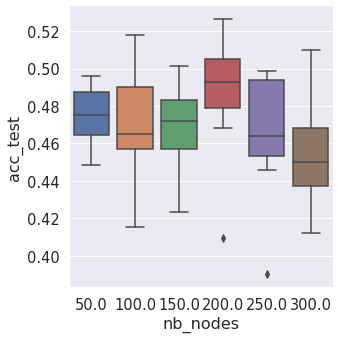

In [0]:
sns.catplot(x="nb_nodes", y="acc_test", kind="box", data=df_res_nodes);

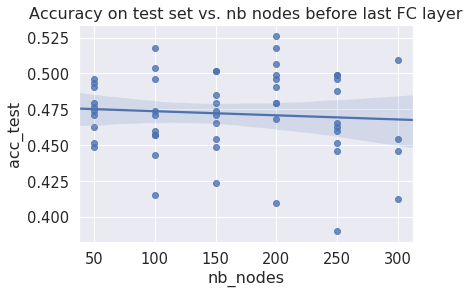

In [0]:
ax = sns.regplot(x="nb_nodes", y="acc_test", data=df_res_nodes);
ax.set_title("Accuracy on test set vs. nb nodes before last FC layer");

Text(0.5, 1.0, ' number nodes before last FC layer vs. time of fitting')

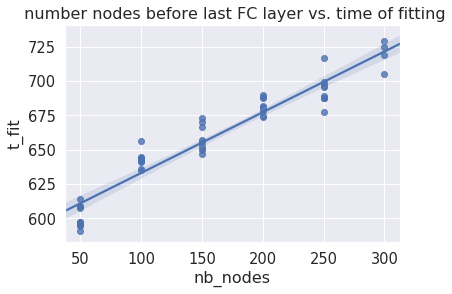

In [0]:
ax = sns.regplot(x="nb_nodes", y="t_fit", data=df_res_nodes);
ax.set_title(" number nodes before last FC layer vs. time of fitting")

In [0]:
nb_splits = df_res_nodes["nb_try"].nunique()
def confid_interv(value):
  return 1.96*np.std(value)/np.sqrt(nb_splits)

df_nodes = df_res_nodes.pivot_table(values=["acc_test",	"acc_train", 
                                                "t_fit",	"t_pred"],
                           index="nb_nodes", aggfunc={np.mean, confid_interv})
df_nodes

acc_test               acc_train                   t_fit  \
         confid_interv      mean confid_interv      mean confid_interv   
nb_nodes                                                                 
50.0          0.009699  0.474095      0.009205  0.988333      4.599597   
100.0         0.017930  0.469359      0.005451  0.976000      3.411763   
150.0         0.014128  0.470195      0.007959  0.972000      5.307727   
200.0         0.019248  0.487187      0.059165  0.937000      3.274642   
250.0         0.019540  0.465460      0.058481  0.931333      6.172422   
300.0         0.021719  0.455432      0.011445  0.967500      5.605318   

                            t_pred            
                mean confid_interv      mean  
nb_nodes                                      
50.0      600.867403      0.065224  1.841613  
100.0     642.762251      0.042009  2.310717  
150.0     657.997799      0.069290  2.496272  
200.0     681.325554      0.046388  2.824746  
250.0     693.458628      0.088040  3.150462  
300.0     719.234305      0.066717  3.404299

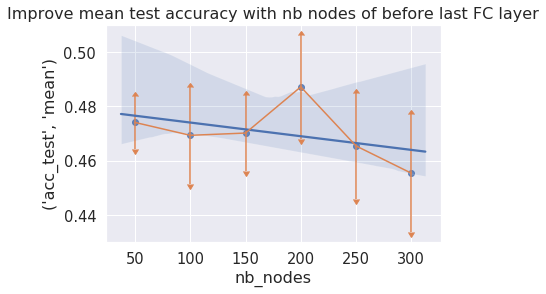

In [0]:
df_nodes["nb_nodes"] = df_nodes.index
ax = sns.regplot(x=df_nodes["nb_nodes"] , y=df_nodes[("acc_test","mean")]);
ax.set_title("Improve mean test accuracy with nb nodes of before last FC layer");
plt.errorbar(df_nodes["nb_nodes"], df_nodes[("acc_test","mean")], 
             yerr=df_nodes[("acc_test","confid_interv")], uplims=True, 
             lolims=True);

#### Conclusion
For 50 -> 300 nodes : 

In general, more nodes decrease accuracy.

Good results with 50 nodes.

200 nodes seem to be the best : to be validated if it is a random result.

### Max filters : 320 conv filters / 50 nodes FC / glorot uniform random (10runs)

In [0]:
#df_res_filters_max = None
print("Loading from disk df_res_filters_max...")
df_res_filters_max = joblib.load(path_data + 'df_res_filters_max.pkl')

Loading from disk df_res_filters_max...


nb_filters:  320
nb_try:  0
Model: "my_VGG16_03_320filt_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 224, 224, 320)     8960      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 112, 112, 320)     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 112, 112, 320)     921920    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 56, 56, 320)       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1003520)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 50)                50176050  
_________________________________________________________________
dense_10 (Dense) 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/100


KeyboardInterrupt: ignored

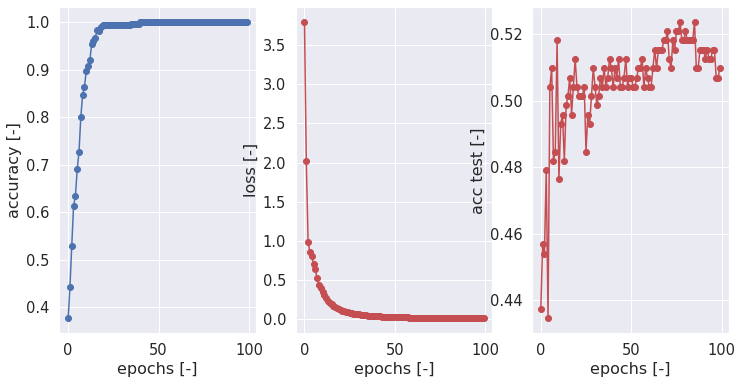

In [0]:
list_nb_filters = df_res_filters_max["nb_filters"].tolist()
list_nb_try = df_res_filters_max["nb_try"].tolist()
# loop on nb filter to check if accuracy is better and memory not saturated
for nb_filters in [320]:
  print("nb_filters: ", nb_filters)
  for nb_try in range(0, 10):
    print("nb_try: ", nb_try)
    list_nb_filters.append(nb_filters)
    list_nb_try.append(nb_try)
    my_VGG16_03 = Sequential()  # Création d'un réseau de neurones vide 
    my_VGG16_03.name = 'my_VGG16_03_{}filt_{}'.format(nb_filters, nb_try)  
    # Ajout de la première couche de convolution, suivie d'une couche ReLU
    my_VGG16_03.add(Conv2D(nb_filters, kernel_size=3, strides=1, 
                       input_shape=(224, 224, 3),
                       padding='same', activation='relu'))
    my_VGG16_03.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # test
    # Ajout de la deuxième couche de convolution, suivie  d'une couche ReLU
    my_VGG16_03.add(Conv2D(nb_filters, kernel_size=3, strides=1, padding='same', 
                       activation='relu'))
    # Ajout de la première couche de pooling
    my_VGG16_03.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # test
    my_VGG16_03.add(Flatten())  # Conversion des matrices 3D en vecteur 1D
    # Ajout de la première couche fully-connected, suivie d'une couche ReLU
    my_VGG16_03.add(Dense(50, activation='relu'))
    # Ajout de la dernière couche fully-connected qui permet de classifier
    my_VGG16_03.add(Dense(nb_breeds, activation='softmax'))
    print(my_VGG16_03.summary())
    # optimizer
    sgd_2 = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True) 
    # compile model
    my_VGG16_03.compile(loss="categorical_crossentropy", optimizer=sgd_2, 
                 metrics=["accuracy"])
    # prepare training
    epochs = 100
    batch_size = None
    t_fit_0 = time.time()
    # fitting
    model_info_3 = my_VGG16_03.fit(X_train, Y_train, epochs=epochs, 
                             batch_size=batch_size, verbose=2,
                             validation_data=(X_test, Y_test))
    t_fit_1 = time.time()
    print("Timing: ", t_fit_1 - t_fit_0)

    # plot results at each iterations
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(1,3,1)
    ax1.plot(range(0, len(model_info_3.history["acc"])), 
         model_info_3.history["acc"], 'o-')
    ax1.set_xlabel("epochs [-]")
    ax1.set_ylabel("accuracy [-]")
    ax2 = fig.add_subplot(1,3,2)
    ax2.set_xlabel("epochs [-]")
    ax2.set_ylabel("loss [-]")
    ax2.plot(range(0, len(model_info_3.history['loss'])), 
         model_info_3.history["loss"], 'ro-')
    ax3 = fig.add_subplot(1,3,3)
    ax3.set_xlabel("epochs [-]")
    ax3.set_ylabel("acc test [-]")
    ax3.plot(range(0, len(model_info_3.history['val_acc'])), 
         model_info_3.history["val_acc"], 'ro-')

    # predict as binary labels
    t_pred_0 = time.time()
    Y_train_pred = my_VGG16_03.predict(X_train)
    t_pred_1 = time.time()
    # predict as binary labels
    t_pred_2 = time.time()
    Y_test_pred = my_VGG16_03.predict(X_test)
    t_pred_3 = time.time()

    series_scores = evaluate_mdl_scorings(Y_train, Y_train_pred, 
                                      Y_test, Y_test_pred, 
    timing_fit=t_fit_1 - t_fit_0, 
      timing_pred=t_pred_3-t_pred_2+t_pred_1-t_pred_0)

    df_res_filters_max = add_score(df_res_filters_max, series_scores, my_VGG16_03.name)

    # save results
    joblib.dump(df_res_filters_max, path_data + 'df_res_filters_max.pkl', compress=True)
    print("df_res_filters Saved here:\n{}".\
          format(path_data + 'df_res_filters_max.pkl'))
    
    df_res_filters_max["nb_filters"] = list_nb_filters
    df_res_filters_max["nb_try"] = list_nb_try

# save results
joblib.dump(df_res_filters_max, path_data + 'df_res_filters_max.pkl', compress=True)
print("df_res_filters_max Saved here:\n{}".\
          format(path_data + 'df_res_filters_max.pkl'))
    
df_res_filters_max

In [0]:
print("Loading from disk df_results...")
df_results = joblib.load(path_df_results)
print("Loading from disk df_res_filters...")
df_res_filters = joblib.load(path_data + 'df_res_filters.pkl')
print("Loading from disk df_res_nodes...")
df_res_nodes = joblib.load(path_data + 'df_res_nodes.pkl')
print("Loading from disk df_res_filters_max...")
df_res_filters_max = joblib.load(path_data + 'df_res_filters_max.pkl')

Loading from disk df_results...
Loading from disk df_res_filters...
Loading from disk df_res_nodes...
Loading from disk df_res_filters_max...


In [0]:
df_res_filters_max

acc_test  acc_train  nb_filters  nb_try        t_fit  \
my_VGG16_03_64filt_0   0.481894   1.000000        64.0     0.0   701.617775   
my_VGG16_03_64filt_1   0.473538   0.980000        64.0     1.0   686.326369   
my_VGG16_03_64filt_2   0.440111   0.983333        64.0     2.0   716.353079   
my_VGG16_03_64filt_3   0.481894   1.000000        64.0     3.0   734.432032   
my_VGG16_03_64filt_4   0.454039   0.990000        64.0     4.0   707.417458   
my_VGG16_03_64filt_5   0.451253   0.983333        64.0     5.0   731.884541   
my_VGG16_03_64filt_6   0.431755   1.000000        64.0     6.0   741.613991   
my_VGG16_03_64filt_7   0.456825   0.983333        64.0     7.0   740.556427   
my_VGG16_03_64filt_8   0.459610   0.996667        64.0     8.0   732.546703   
my_VGG16_03_64filt_9   0.459610   0.990000        64.0     9.0   740.506418   
my_VGG16_03_128filt_0  0.540390   0.996667       128.0     0.0  1455.857613   
my_VGG16_03_128filt_1  0.493036   1.000000       128.0     1.0  1450.812938   
my_VGG16_03_128filt_2  0.462396   1.000000       128.0     2.0  1454.774060   
my_VGG16_03_128filt_3  0.487465   1.000000       128.0     3.0  1456.835454   
my_VGG16_03_128filt_4  0.437326   1.000000       128.0     4.0  1438.760543   
my_VGG16_03_128filt_5  0.387187   0.333333       128.0     5.0  1461.321872   
my_VGG16_03_320filt_0  0.509749   1.000000       320.0     0.0  4599.775408   

                          t_pred  
my_VGG16_03_64filt_0    2.072533  
my_VGG16_03_64filt_1    2.153477  
my_VGG16_03_64filt_2    2.357288  
my_VGG16_03_64filt_3    2.686761  
my_VGG16_03_64filt_4    2.399992  
my_VGG16_03_64filt_5    2.682044  
my_VGG16_03_64filt_6    2.981172  
my_VGG16_03_64filt_7    3.060145  
my_VGG16_03_64filt_8    3.007402  
my_VGG16_03_64filt_9    3.143795  
my_VGG16_03_128filt_0   5.203671  
my_VGG16_03_128filt_1   5.163815  
my_VGG16_03_128filt_2   5.224103  
my_VGG16_03_128filt_3   4.965214  
my_VGG16_03_128filt_4   5.154043  
my_VGG16_03_128filt_5   4.941389  
my_VGG16_03_320filt_0  17.606255

In [0]:
joblib.dump(df_res_filters_max, path_data + 'df_res_filters_max.pkl', compress=True)

['/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_filters_max.pkl']

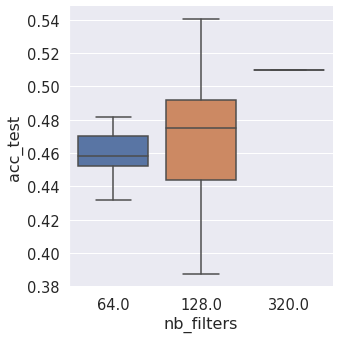

In [0]:
sns.catplot(x="nb_filters", y="acc_test", kind="box", data=df_res_filters_max);

### Test max filter

Model: "my_VGG16_03"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                10035250  
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 

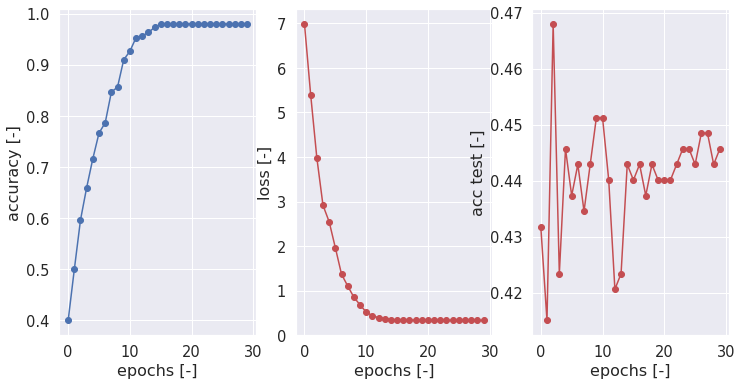

In [0]:
my_VGG16_03 = Sequential()  # Création d'un réseau de neurones vide 
my_VGG16_03.name = 'my_VGG16_03'
# Ajout de la première couche de convolution, suivie d'une couche ReLU
my_VGG16_03.add(Conv2D(64, kernel_size=3, strides=1, input_shape=(224, 224, 3),
                       padding='same', activation='relu'))
my_VGG16_03.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # test
# Ajout de la deuxième couche de convolution, suivie  d'une couche ReLU
my_VGG16_03.add(Conv2D(64, kernel_size=3, strides=1, padding='same', 
                       activation='relu'))

# Ajout de la première couche de pooling
my_VGG16_03.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # test
my_VGG16_03.add(Flatten())  # Conversion des matrices 3D en vecteur 1D

# Ajout de la première couche fully-connected, suivie d'une couche ReLU
my_VGG16_03.add(Dense(50, activation='relu'))

# Ajout de la dernière couche fully-connected qui permet de classifier
my_VGG16_03.add(Dense(nb_breeds, activation='softmax'))
print(my_VGG16_03.summary())

# optimizer
sgd_2 = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True) 
# compile model
my_VGG16_03.compile(loss="categorical_crossentropy", optimizer=sgd_2, 
                 metrics=["accuracy"])
# prepare training
epochs = 30
batch_size = None
t_fit_0 = time.time()
# fitting
model_info_3 = my_VGG16_03.fit(X_train, Y_train, epochs=epochs, 
                             batch_size=batch_size, verbose=2,
                             validation_data=(X_test, Y_test))
t_fit_1 = time.time()
print("Timing: ", t_fit_1 - t_fit_0)

# plot results at each iterations
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1,3,1)
ax1.plot(range(0, len(model_info_3.history["acc"])), 
         model_info_3.history["acc"], 'o-')
ax1.set_xlabel("epochs [-]")
ax1.set_ylabel("accuracy [-]")
ax2 = fig.add_subplot(1,3,2)
ax2.set_xlabel("epochs [-]")
ax2.set_ylabel("loss [-]")
ax2.plot(range(0, len(model_info_3.history['loss'])), 
         model_info_3.history["loss"], 'ro-')
ax3 = fig.add_subplot(1,3,3)
ax3.set_xlabel("epochs [-]")
ax3.set_ylabel("acc test [-]")
ax3.plot(range(0, len(model_info_3.history['val_acc'])), 
         model_info_3.history["val_acc"], 'ro-')

### Test filters with 50 nodes FC

nb_filters:  64
nb_try:  0
Model: "my_VGG16_03_64filt_0_50nod"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 200704)            0         
_________________________________________________________________
dense_33 (Dense)             (None, 50)                10035250  
_________________________________________________________________
dense_34 (Den

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/10
 - 9s - loss: 6.0346 - acc: 0.4433 - val_loss: 6.1955 - val_acc: 0.3538
Epoch 2/10
 - 8s - loss: 4.5089 - acc: 0.5400 - val_loss: 5.7961 - val_acc: 0.3983
Epoch 3/10
 - 8s - loss: 3.3267 - acc: 0.6400 - val_loss: 6.5414 - val_acc: 0.3872
Epoch 4/10
 - 8s - loss: 2.5997 - acc: 0.7200 - val_loss: 5.3723 - val_acc: 0.4290
Epoch 5/10
 - 8s - loss: 2.1077 - acc: 0.7700 - val_loss: 5.3086 - val_acc: 0.4206
Epoch 6/10
 - 8s - loss: 1.7763 - acc: 0.7867 - val_loss: 5.1881 - val_acc: 0.4123
Epoch 7/10
 - 8s - loss: 1.4561 - acc: 0.8533 - val_loss: 5.3049 - val_acc: 0.4318
Epoch 8/10
 - 8s - loss: 1.3358 - acc: 0.8633 - val_loss: 5.0478 - val_acc: 0.4401
Epoch 9/10
 - 8s - loss: 1.1845 - acc: 0.9033 - val_loss: 5.0956 - val_acc: 0.4262
Epoch 10/10
 - 8s - loss: 1.0498 - acc: 0.9100 - val_loss: 4.9942 - val_acc: 0.4262
Timing:  83.48764777183533
model_info_3 Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/model_info_3_6

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/10
 - 18s - loss: 5.4915 - acc: 0.3767 - val_loss: 4.0931 - val_acc: 0.4039
Epoch 2/10
 - 17s - loss: 2.7015 - acc: 0.4600 - val_loss: 1.8970 - val_acc: 0.5265
Epoch 3/10
 - 17s - loss: 1.4747 - acc: 0.5633 - val_loss: 1.7505 - val_acc: 0.4847
Epoch 4/10
 - 17s - loss: 0.9658 - acc: 0.6267 - val_loss: 1.5967 - val_acc: 0.4875
Epoch 5/10
 - 17s - loss: 0.7276 - acc: 0.7467 - val_loss: 1.7640 - val_acc: 0.4457
Epoch 6/10
 - 17s - loss: 0.5733 - acc: 0.8033 - val_loss: 1.5729 - val_acc: 0.5125
Epoch 7/10
 - 17s - loss: 0.4411 - acc: 0.8533 - val_loss: 1.6026 - val_acc: 0.5432
Epoch 8/10
 - 17s - loss: 0.3876 - acc: 0.8567 - val_loss: 1.5945 - val_acc: 0.5153
Epoch 9/10
 - 17s - loss: 0.2963 - acc: 0.8967 - val_loss: 1.6661 - val_acc: 0.5265
Epoch 10/10
 - 17s - loss: 0.2499 - acc: 0.9167 - val_loss: 1.7251 - val_acc: 0.5014
Timing:  169.53359174728394
model_info_3 Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/mod

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/10
 - 19s - loss: 6.0943 - acc: 0.3633 - val_loss: 7.7045 - val_acc: 0.3315
Epoch 2/10
 - 17s - loss: 4.0607 - acc: 0.4700 - val_loss: 3.8500 - val_acc: 0.4234
Epoch 3/10
 - 17s - loss: 1.9006 - acc: 0.6067 - val_loss: 2.5762 - val_acc: 0.4930
Epoch 4/10
 - 17s - loss: 1.0236 - acc: 0.7133 - val_loss: 2.5184 - val_acc: 0.5014
Epoch 5/10
 - 17s - loss: 0.6212 - acc: 0.7867 - val_loss: 2.5346 - val_acc: 0.4930
Epoch 6/10
 - 17s - loss: 0.3659 - acc: 0.8767 - val_loss: 2.5650 - val_acc: 0.4596
Epoch 7/10
 - 17s - loss: 0.2287 - acc: 0.9067 - val_loss: 2.6601 - val_acc: 0.4652
Epoch 8/10
 - 17s - loss: 0.1584 - acc: 0.9433 - val_loss: 2.5970 - val_acc: 0.4875
Epoch 9/10
 - 17s - loss: 0.1205 - acc: 0.9667 - val_loss: 2.5268 - val_acc: 0.4903
Epoch 10/10
 - 17s - loss: 0.0723 - acc: 0.9867 - val_loss: 2.4898 - val_acc: 0.4819
Timing:  170.18273425102234
model_info_3 Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/mod

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/10
 - 18s - loss: 4.8359 - acc: 0.2867 - val_loss: 3.2936 - val_acc: 0.3649
Epoch 2/10
 - 16s - loss: 1.9378 - acc: 0.4333 - val_loss: 2.4929 - val_acc: 0.4150
Epoch 3/10
 - 17s - loss: 1.1269 - acc: 0.5800 - val_loss: 2.1473 - val_acc: 0.4624
Epoch 4/10
 - 16s - loss: 0.7172 - acc: 0.7167 - val_loss: 1.9750 - val_acc: 0.4930
Epoch 5/10
 - 16s - loss: 0.4609 - acc: 0.8167 - val_loss: 1.8719 - val_acc: 0.4875
Epoch 6/10
 - 17s - loss: 0.3109 - acc: 0.8800 - val_loss: 1.8889 - val_acc: 0.4875
Epoch 7/10
 - 17s - loss: 0.2369 - acc: 0.9333 - val_loss: 1.9177 - val_acc: 0.4930
Epoch 8/10
 - 16s - loss: 0.1774 - acc: 0.9600 - val_loss: 1.9700 - val_acc: 0.4875
Epoch 9/10
 - 16s - loss: 0.1581 - acc: 0.9600 - val_loss: 1.9051 - val_acc: 0.4986
Epoch 10/10
 - 17s - loss: 0.1148 - acc: 0.9867 - val_loss: 1.9792 - val_acc: 0.5209
Timing:  166.96877217292786
model_info_3 Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/mod

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/10
 - 38s - loss: 4.7233 - acc: 0.3533 - val_loss: 1.6962 - val_acc: 0.3955
Epoch 2/10
 - 36s - loss: 1.3647 - acc: 0.4267 - val_loss: 1.2036 - val_acc: 0.4039
Epoch 3/10
 - 35s - loss: 1.0971 - acc: 0.4433 - val_loss: 1.1260 - val_acc: 0.3844
Epoch 4/10
 - 35s - loss: 0.9987 - acc: 0.4733 - val_loss: 1.1286 - val_acc: 0.3900
Epoch 5/10
 - 35s - loss: 0.9137 - acc: 0.5300 - val_loss: 1.1745 - val_acc: 0.3816
Epoch 6/10
 - 35s - loss: 0.8228 - acc: 0.6133 - val_loss: 1.1721 - val_acc: 0.4123
Epoch 7/10
 - 36s - loss: 0.7595 - acc: 0.6500 - val_loss: 1.2903 - val_acc: 0.4429
Epoch 8/10
 - 36s - loss: 0.6749 - acc: 0.6867 - val_loss: 1.3505 - val_acc: 0.4708
Epoch 9/10
 - 36s - loss: 0.5805 - acc: 0.7533 - val_loss: 1.2731 - val_acc: 0.4763
Epoch 10/10
 - 36s - loss: 0.4887 - acc: 0.8267 - val_loss: 1.3899 - val_acc: 0.4680
Timing:  358.4046130180359
model_info_3 Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/mode

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/10
 - 38s - loss: 4.3114 - acc: 0.3133 - val_loss: 2.5008 - val_acc: 0.3733
Epoch 2/10
 - 36s - loss: 1.4450 - acc: 0.5200 - val_loss: 1.6384 - val_acc: 0.4568
Epoch 3/10
 - 36s - loss: 0.8661 - acc: 0.6733 - val_loss: 1.6434 - val_acc: 0.4847
Epoch 4/10
 - 36s - loss: 0.5275 - acc: 0.7833 - val_loss: 1.5896 - val_acc: 0.4735
Epoch 5/10
 - 35s - loss: 0.3883 - acc: 0.8667 - val_loss: 1.7782 - val_acc: 0.4708
Epoch 6/10
 - 36s - loss: 0.2882 - acc: 0.9000 - val_loss: 1.6049 - val_acc: 0.5181
Epoch 7/10
 - 36s - loss: 0.1946 - acc: 0.9367 - val_loss: 1.6882 - val_acc: 0.4986
Epoch 8/10
 - 36s - loss: 0.1284 - acc: 0.9800 - val_loss: 1.7054 - val_acc: 0.5292
Epoch 9/10
 - 36s - loss: 0.0969 - acc: 0.9867 - val_loss: 1.7528 - val_acc: 0.5153
Epoch 10/10
 - 36s - loss: 0.0852 - acc: 0.9967 - val_loss: 1.7131 - val_acc: 0.5125
Timing:  359.7916431427002
model_info_3 Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/mode

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/10
 - 38s - loss: 4.5562 - acc: 0.3500 - val_loss: 3.9869 - val_acc: 0.3565
Epoch 2/10
 - 35s - loss: 2.0124 - acc: 0.4933 - val_loss: 3.3784 - val_acc: 0.4206
Epoch 3/10
 - 35s - loss: 1.2775 - acc: 0.6500 - val_loss: 1.9514 - val_acc: 0.4513
Epoch 4/10
 - 35s - loss: 0.5959 - acc: 0.7967 - val_loss: 1.8887 - val_acc: 0.4875
Epoch 5/10
 - 35s - loss: 0.3968 - acc: 0.8633 - val_loss: 1.8330 - val_acc: 0.4875
Epoch 6/10
 - 35s - loss: 0.2568 - acc: 0.9333 - val_loss: 1.7862 - val_acc: 0.5097
Epoch 7/10
 - 35s - loss: 0.1747 - acc: 0.9700 - val_loss: 1.8004 - val_acc: 0.5097
Epoch 8/10
 - 35s - loss: 0.1252 - acc: 0.9767 - val_loss: 1.8288 - val_acc: 0.4930
Epoch 9/10
 - 35s - loss: 0.1131 - acc: 0.9767 - val_loss: 1.8413 - val_acc: 0.5209
Epoch 10/10
 - 35s - loss: 0.0873 - acc: 0.9900 - val_loss: 1.8241 - val_acc: 0.5265
Timing:  354.40759682655334
model_info_3 Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/mod

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/10
 - 50s - loss: 3.5939 - acc: 0.3667 - val_loss: 1.8019 - val_acc: 0.3593
Epoch 2/10
 - 46s - loss: 1.1308 - acc: 0.5400 - val_loss: 1.3068 - val_acc: 0.4039
Epoch 3/10
 - 46s - loss: 0.8730 - acc: 0.5767 - val_loss: 1.3503 - val_acc: 0.4401
Epoch 4/10
 - 46s - loss: 0.7182 - acc: 0.7000 - val_loss: 1.4262 - val_acc: 0.4095
Epoch 5/10
 - 46s - loss: 0.6071 - acc: 0.7567 - val_loss: 1.3661 - val_acc: 0.4485
Epoch 6/10
 - 46s - loss: 0.5080 - acc: 0.7933 - val_loss: 1.4049 - val_acc: 0.4262
Epoch 7/10
 - 46s - loss: 0.4316 - acc: 0.8200 - val_loss: 1.4294 - val_acc: 0.4318
Epoch 8/10
 - 46s - loss: 0.3906 - acc: 0.8667 - val_loss: 1.4986 - val_acc: 0.4596
Epoch 9/10
 - 46s - loss: 0.3170 - acc: 0.8967 - val_loss: 1.4794 - val_acc: 0.4457
Epoch 10/10
 - 46s - loss: 0.2689 - acc: 0.9267 - val_loss: 1.4874 - val_acc: 0.4958
Timing:  465.31358313560486
model_info_3 Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/mod

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/10
 - 49s - loss: 4.0315 - acc: 0.3567 - val_loss: 2.6320 - val_acc: 0.3816
Epoch 2/10
 - 46s - loss: 1.6111 - acc: 0.4733 - val_loss: 1.4000 - val_acc: 0.4540
Epoch 3/10
 - 47s - loss: 0.8594 - acc: 0.6167 - val_loss: 1.2486 - val_acc: 0.4847
Epoch 4/10
 - 47s - loss: 0.6915 - acc: 0.6900 - val_loss: 1.3669 - val_acc: 0.4540
Epoch 5/10
 - 46s - loss: 0.5079 - acc: 0.7833 - val_loss: 1.3973 - val_acc: 0.4680
Epoch 6/10
 - 47s - loss: 0.4399 - acc: 0.8300 - val_loss: 1.3214 - val_acc: 0.5125
Epoch 7/10
 - 47s - loss: 0.3702 - acc: 0.8800 - val_loss: 1.2932 - val_acc: 0.5070
Epoch 8/10
 - 47s - loss: 0.2805 - acc: 0.9300 - val_loss: 1.3552 - val_acc: 0.4930
Epoch 9/10
 - 47s - loss: 0.2429 - acc: 0.9567 - val_loss: 1.3783 - val_acc: 0.5097
Epoch 10/10
 - 47s - loss: 0.2121 - acc: 0.9533 - val_loss: 1.3337 - val_acc: 0.5376
Timing:  468.952260017395
model_info_3 Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/model

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/10
 - 50s - loss: 3.6036 - acc: 0.3900 - val_loss: 2.1275 - val_acc: 0.4123
Epoch 2/10
 - 46s - loss: 1.2464 - acc: 0.6033 - val_loss: 2.5947 - val_acc: 0.4011
Epoch 3/10
 - 46s - loss: 0.7282 - acc: 0.7433 - val_loss: 1.9902 - val_acc: 0.4596
Epoch 4/10
 - 46s - loss: 0.3187 - acc: 0.8700 - val_loss: 2.1774 - val_acc: 0.4513
Epoch 5/10
 - 46s - loss: 0.1952 - acc: 0.9367 - val_loss: 2.0944 - val_acc: 0.4401
Epoch 6/10
 - 47s - loss: 0.1202 - acc: 0.9633 - val_loss: 2.0785 - val_acc: 0.4540
Epoch 7/10
 - 47s - loss: 0.0786 - acc: 0.9933 - val_loss: 2.0507 - val_acc: 0.4847
Epoch 8/10
 - 46s - loss: 0.0587 - acc: 0.9967 - val_loss: 2.1110 - val_acc: 0.4513
Epoch 9/10
 - 46s - loss: 0.0477 - acc: 0.9967 - val_loss: 2.1237 - val_acc: 0.4596
Epoch 10/10
 - 46s - loss: 0.0387 - acc: 0.9967 - val_loss: 2.1203 - val_acc: 0.4540
Timing:  466.9342346191406
model_info_3 Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/mode

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


acc_test  acc_train  nb_filters  nb_try  \
my_VGG16_03_64filt_0_50nod   0.423398   0.923333          64       0   
my_VGG16_03_64filt_1_50nod   0.459610   0.893333          64       1   
my_VGG16_03_64filt_2_50nod   0.426184   0.913333          64       2   
my_VGG16_03_128filt_0_50nod  0.501393   0.926667         128       0   
my_VGG16_03_128filt_1_50nod  0.481894   0.993333         128       1   
my_VGG16_03_128filt_2_50nod  0.520891   0.990000         128       2   
my_VGG16_03_256filt_0_50nod  0.467967   0.823333         256       0   
my_VGG16_03_256filt_1_50nod  0.512535   0.996667         256       1   
my_VGG16_03_256filt_2_50nod  0.526462   0.993333         256       2   
my_VGG16_03_320filt_0_50nod  0.495822   0.953333         320       0   
my_VGG16_03_320filt_1_50nod  0.537604   0.976667         320       1   
my_VGG16_03_320filt_2_50nod  0.454039   0.996667         320       2   

                                  t_fit     t_pred  
my_VGG16_03_64filt_0_50nod    84.365171   3.234802  
my_VGG16_03_64filt_1_50nod    82.909575   3.814394  
my_VGG16_03_64filt_2_50nod    83.487648   3.355069  
my_VGG16_03_128filt_0_50nod  169.533592   6.716658  
my_VGG16_03_128filt_1_50nod  170.182734   6.540102  
my_VGG16_03_128filt_2_50nod  166.968772   6.485526  
my_VGG16_03_256filt_0_50nod  358.404613  14.058613  
my_VGG16_03_256filt_1_50nod  359.791643  14.188514  
my_VGG16_03_256filt_2_50nod  354.407597  13.682062  
my_VGG16_03_320filt_0_50nod  465.313583  18.341121  
my_VGG16_03_320filt_1_50nod  468.952260  18.602858  
my_VGG16_03_320filt_2_50nod  466.934235  18.453639

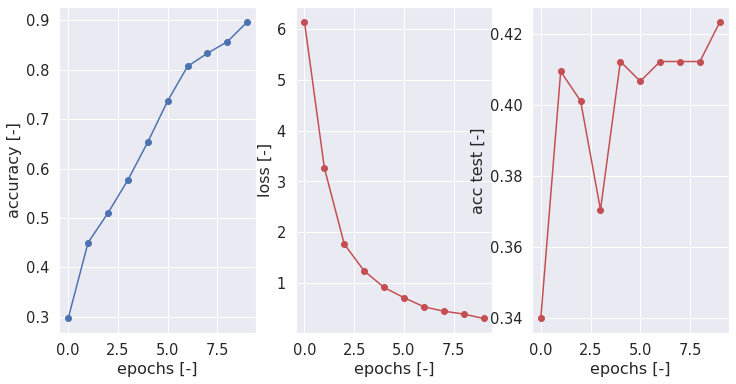

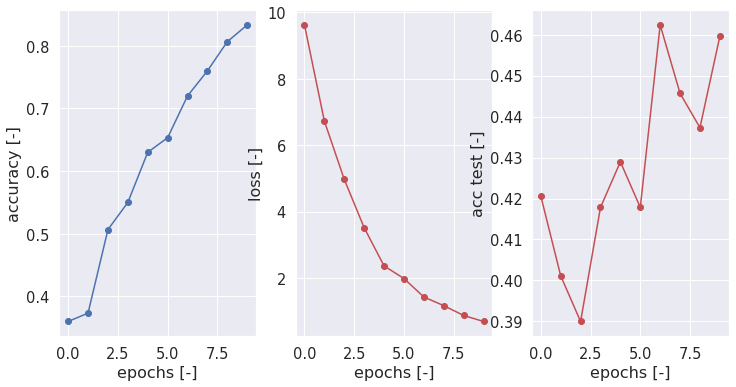

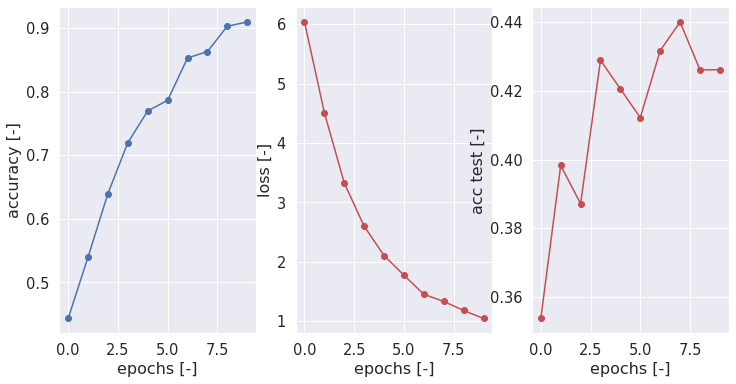

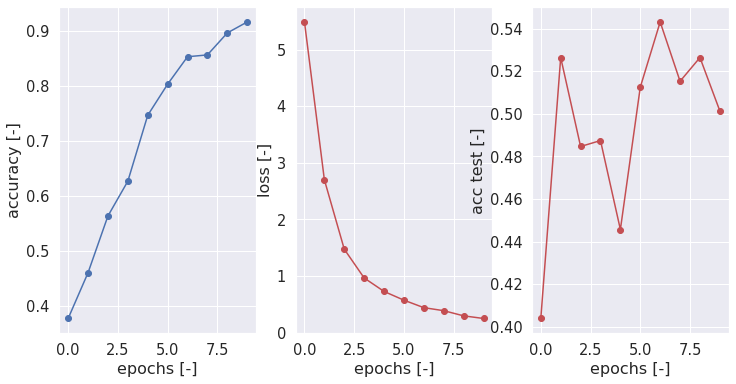

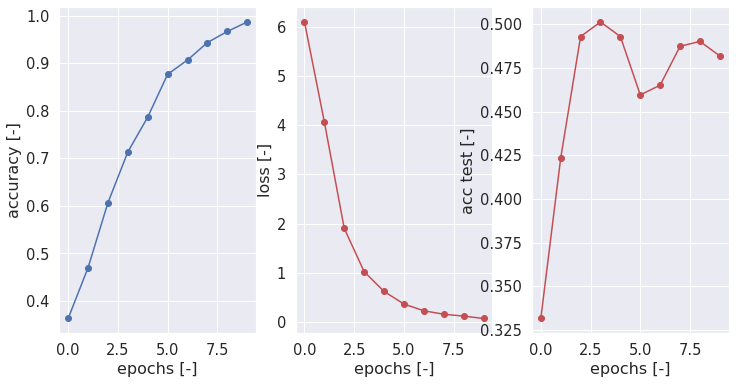

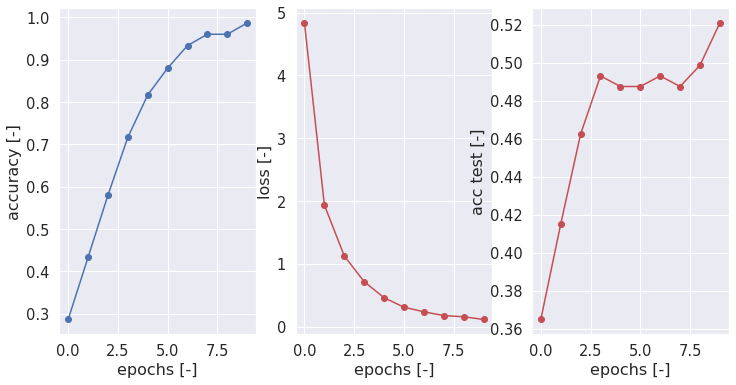

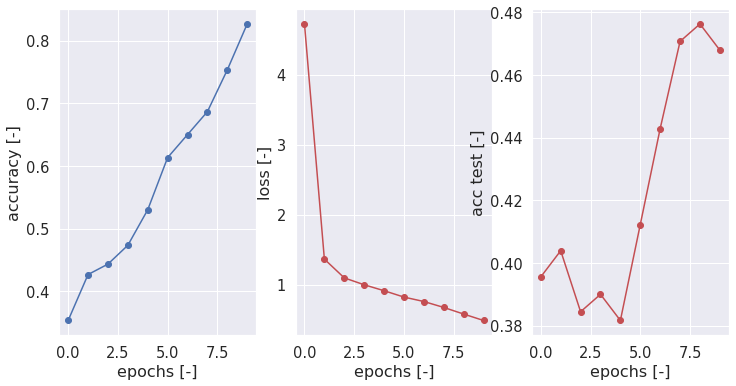

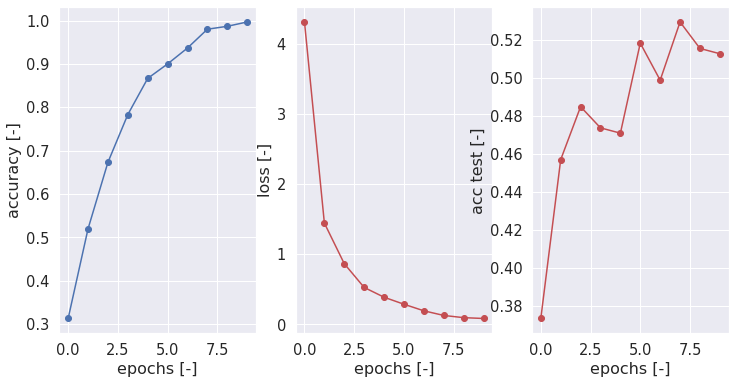

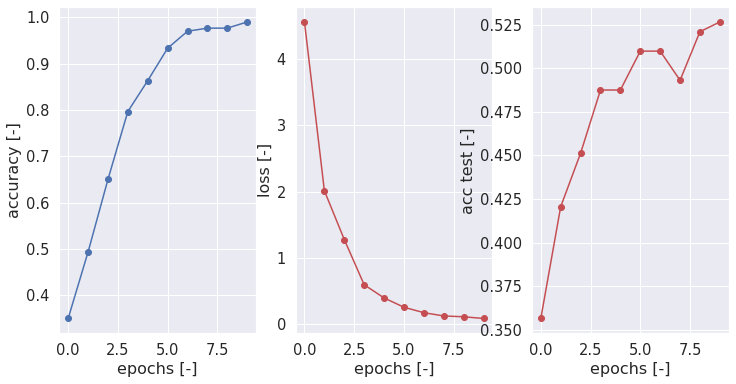

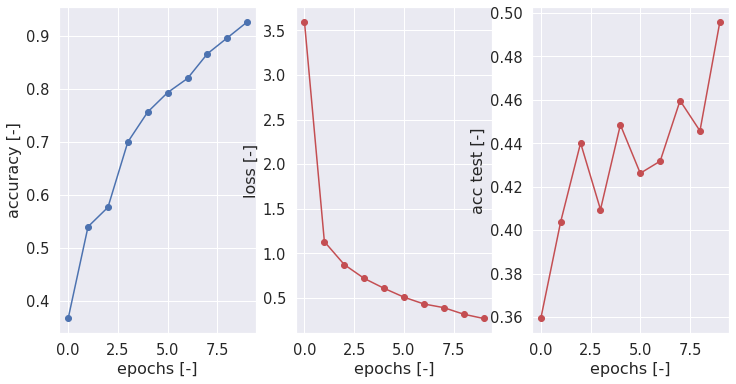

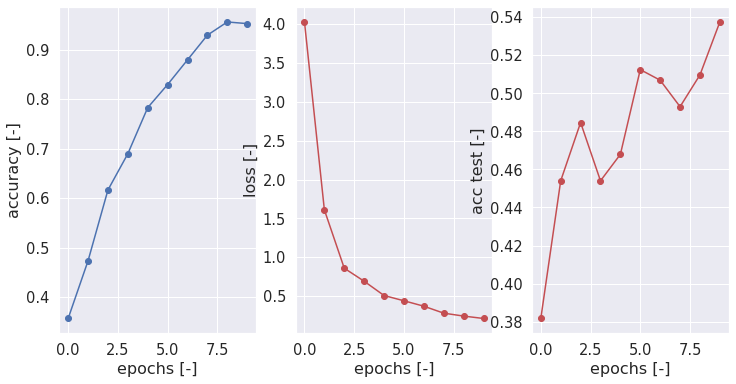

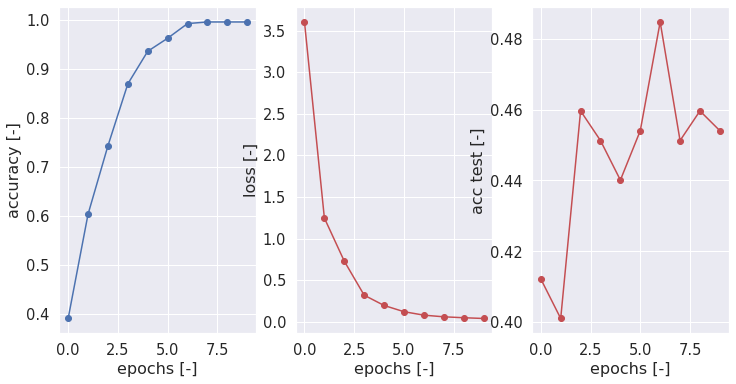

In [0]:
df_res_filters_50nodes = None
list_nb_filters = []
list_nb_try = []
# loop on nb filter to check if accuracy is better and memory not saturated
for nb_filters in [64, 128, 256, 320]:
  print("nb_filters: ", nb_filters)
  for nb_try in range(0, 3):
    print("nb_try: ", nb_try)
    list_nb_filters.append(nb_filters)
    list_nb_try.append(nb_try)
    my_VGG16_03 = Sequential()  # Création d'un réseau de neurones vide 
    my_VGG16_03.name = 'my_VGG16_03_{}filt_{}_50nod'.format(nb_filters, nb_try)  
    # Ajout de la première couche de convolution, suivie d'une couche ReLU
    my_VGG16_03.add(Conv2D(nb_filters, kernel_size=3, strides=1, 
                       input_shape=(224, 224, 3),
                       padding='same', activation='relu'))
    my_VGG16_03.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # test
    # Ajout de la deuxième couche de convolution, suivie  d'une couche ReLU
    my_VGG16_03.add(Conv2D(nb_filters, kernel_size=3, strides=1, padding='same', 
                       activation='relu'))
    # Ajout de la première couche de pooling
    my_VGG16_03.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # test
    my_VGG16_03.add(Flatten())  # Conversion des matrices 3D en vecteur 1D
    # Ajout de la première couche fully-connected, suivie d'une couche ReLU
    my_VGG16_03.add(Dense(50, activation='relu'))
    # Ajout de la dernière couche fully-connected qui permet de classifier
    my_VGG16_03.add(Dense(nb_breeds, activation='softmax'))
    print(my_VGG16_03.summary())
    # optimizer
    sgd_2 = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True) 
    # compile model
    my_VGG16_03.compile(loss="categorical_crossentropy", optimizer=sgd_2, 
                 metrics=["accuracy"])
    # prepare training
    epochs = 10
    batch_size = None
    t_fit_0 = time.time()
    # fitting
    model_info_3 = my_VGG16_03.fit(X_train, Y_train, epochs=epochs, 
                             batch_size=batch_size, verbose=2,
                             validation_data=(X_test, Y_test))
    t_fit_1 = time.time()
    print("Timing: ", t_fit_1 - t_fit_0)

    # save : model info
    joblib.dump(model_info_3, 
                path_data + 'model_info_3_{}filt_50nodes_{}.pkl'.\
                format(nb_filters, nb_try), compress=True)
    print("model_info_3 Saved here:\n{}".\
          format(path_data + 'model_info_3_{}filt_50nodes_{}.pkl'.\
                format(nb_filters, nb_try)))


    # plot results at each iterations
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(1,3,1)
    ax1.plot(range(0, len(model_info_3.history["acc"])), 
         model_info_3.history["acc"], 'o-')
    ax1.set_xlabel("epochs [-]")
    ax1.set_ylabel("accuracy [-]")
    ax2 = fig.add_subplot(1,3,2)
    ax2.set_xlabel("epochs [-]")
    ax2.set_ylabel("loss [-]")
    ax2.plot(range(0, len(model_info_3.history['loss'])), 
         model_info_3.history["loss"], 'ro-')
    ax3 = fig.add_subplot(1,3,3)
    ax3.set_xlabel("epochs [-]")
    ax3.set_ylabel("acc test [-]")
    ax3.plot(range(0, len(model_info_3.history['val_acc'])), 
         model_info_3.history["val_acc"], 'ro-')

    # NO save
    #my_VGG16_03.save(path_data + 'my_VGG16_03_{}filt.h5'.format(nb_filters))

    # predict as binary labels
    t_pred_0 = time.time()
    Y_train_pred = my_VGG16_03.predict(X_train)
    t_pred_1 = time.time()
    # predict as binary labels
    t_pred_2 = time.time()
    Y_test_pred = my_VGG16_03.predict(X_test)
    t_pred_3 = time.time()

    series_scores = evaluate_mdl_scorings(Y_train, Y_train_pred, 
                                      Y_test, Y_test_pred, 
    timing_fit=t_fit_1 - t_fit_0, 
      timing_pred=t_pred_3-t_pred_2+t_pred_1-t_pred_0)

    df_res_filters_50nodes = add_score(df_res_filters_50nodes, series_scores, my_VGG16_03.name)

    # save results
    joblib.dump(df_res_filters_50nodes, path_data + 'df_res_filters_50nodes.pkl', compress=True)
    print("df_res_filters_50nodes Saved here:\n{}".\
          format(path_data + 'df_res_filters_50nodes.pkl'))
    
    df_res_filters_50nodes["nb_filters"] = list_nb_filters
    df_res_filters_50nodes["nb_try"] = list_nb_try

# save results
joblib.dump(df_res_filters_50nodes, path_data + 'df_res_filters_50nodes.pkl', compress=True)
print("df_res_filters_50nodes Saved here:\n{}".\
          format(path_data + 'df_res_filters_50nodes.pkl'))
    
df_res_filters_50nodes

In [0]:
print("Loading from disk df_results...")
df_results = joblib.load(path_df_results)
print("Loading from disk df_res_filters...")
df_res_filters = joblib.load(path_data + 'df_res_filters.pkl')
print("Loading from disk df_res_nodes...")
df_res_nodes = joblib.load(path_data + 'df_res_nodes.pkl')
print("Loading from disk df_res_filters_max...")
df_res_filters_max = joblib.load(path_data + 'df_res_filters_max.pkl')
print("Loading from disk df_res_filters_50nodes...")
df_res_filters_50nodes = joblib.load(path_data + 'df_res_filters_50nodes.pkl')



Loading from disk df_results...
Loading from disk df_res_filters...
Loading from disk df_res_nodes...
Loading from disk df_res_filters_max...
Loading from disk df_res_filters_50nodes...


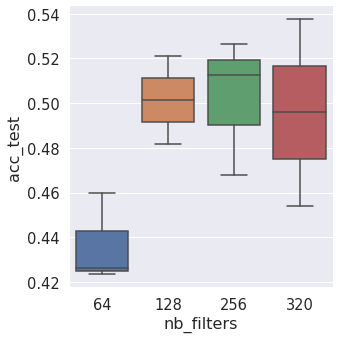

In [0]:
sns.catplot(x="nb_filters", y="acc_test", kind="box", data=df_res_filters_50nodes);

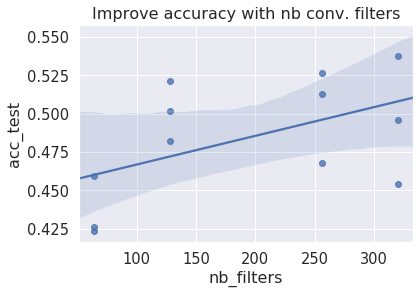

In [0]:
ax = sns.regplot(x="nb_filters", y="acc_test", data=df_res_filters_50nodes);
ax.set_title("Improve accuracy with nb conv. filters");

Text(0.5, 1.0, 'Increase of time with number of conv. filters')

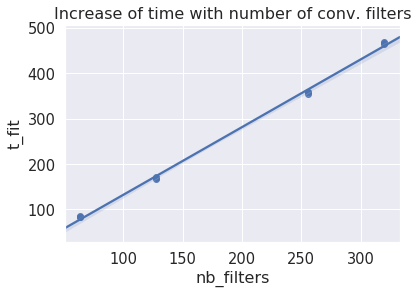

In [0]:
ax = sns.regplot(x="nb_filters", y="t_fit", data=df_res_filters_50nodes);
ax.set_title("Increase of time with number of conv. filters")

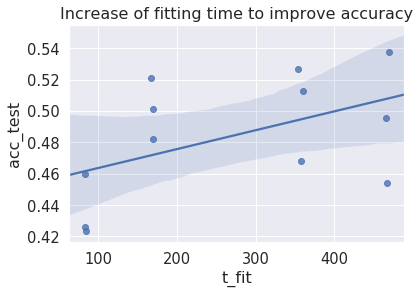

In [0]:
ax = sns.regplot(y="acc_test", x="t_fit", data=df_res_filters_50nodes);
ax.set_title('Increase of fitting time to improve accuracy');

In [0]:
nb_splits = df_res_filters_50nodes["nb_try"].nunique()
def confid_interv(value):
  return 1.96*np.std(value)/np.sqrt(nb_splits)
df_filters = df_res_filters_50nodes.pivot_table(values=["acc_test",	"acc_train", 
                                                "t_fit",	"t_pred"],
                           index="nb_filters", aggfunc={np.mean, confid_interv})
df_filters

acc_test               acc_train                   t_fit  \
           confid_interv      mean confid_interv      mean confid_interv   
nb_filters                                                                 
64              0.018618  0.436397      0.014114  0.910000      0.677178   
128             0.018016  0.501393      0.034708  0.970000      1.570232   
256             0.028232  0.502321      0.091588  0.937778      2.582883   
320             0.038605  0.495822      0.020039  0.975556      1.684321   

                              t_pred             
                  mean confid_interv       mean  
nb_filters                                       
64           83.587465      0.282618   3.468089  
128         168.895033      0.111624   6.580762  
256         357.534618      0.243042  13.976397  
320         467.066693      0.121312  18.465873

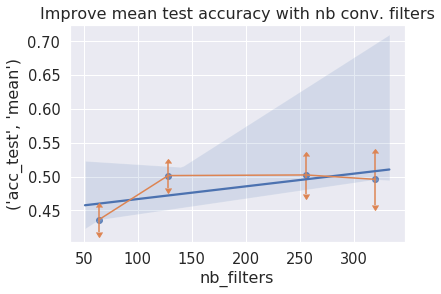

In [0]:
df_filters["nb_filters"] = df_filters.index
ax = sns.regplot(x=df_filters["nb_filters"] , y=df_filters[("acc_test","mean")]);
ax.set_title("Improve mean test accuracy with nb conv. filters");
plt.errorbar(df_filters["nb_filters"], df_filters[("acc_test","mean")], 
             yerr=df_filters[("acc_test","confid_interv")], uplims=True, 
             lolims=True);

In [0]:
print("Loading from model_info_3...")
model_info_3 = joblib.load(path_data + 'model_info_3_256filt_50nodes_2.pkl')

Loading from model_info_3...











Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




### Test initalisation HE normal

#### Test HE initialization

Model: "my_VGG16_03"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 200704)            0         
_________________________________________________________________
dense_37 (Dense)             (None, 50)                10035250  
_________________________________________________________________
dense_38 (Dense)             (None, 3)                 

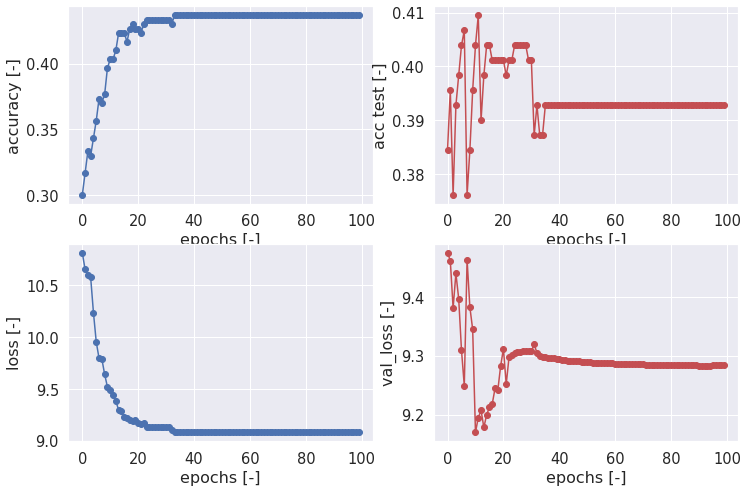

In [0]:
lr = 1e-7

my_VGG16_03 = Sequential()  # Création d'un réseau de neurones vide 
my_VGG16_03.name = 'my_VGG16_03'
# initializers 
init_he_n = keras.initializers.he_normal(seed=0)
init_glorot_u = keras.initializers.glorot_uniform(seed=0)
conv_init = init_he_n # Conv2D layers
dens_init = init_he_n # first FC layer
out_init = init_glorot_u # output FC layer
# Ajout de la première couche de convolution, suivie d'une couche ReLU
my_VGG16_03.add(Conv2D(64, kernel_size=3, strides=1, input_shape=(224, 224, 3),
                       padding='same', activation='relu',
                       kernel_initializer=conv_init))
my_VGG16_03.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # test
# Ajout de la deuxième couche de convolution, suivie  d'une couche ReLU
my_VGG16_03.add(Conv2D(64, kernel_size=3, strides=1, padding='same', 
                       activation='relu', kernel_initializer=conv_init))
# Ajout de la première couche de pooling
my_VGG16_03.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # test
# add flatten layer before dense
my_VGG16_03.add(Flatten())  # Conversion des matrices 3D en vecteur 1D
# Ajout de la première couche fully-connected, suivie d'une couche ReLU
my_VGG16_03.add(Dense(50, activation='relu', kernel_initializer=dens_init))
# Ajout de la dernière couche fully-connected qui permet de classifier
my_VGG16_03.add(Dense(nb_breeds, activation='softmax',
              kernel_initializer=out_init))
# print List layers
print(my_VGG16_03.summary())
# optimizer
sgd_2 = optimizers.SGD(lr=lr, decay=1e-6, momentum=0.5, nesterov=True) 
# compile model
my_VGG16_03.compile(loss="categorical_crossentropy", optimizer=sgd_2, 
                 metrics=["accuracy"])
# prepare training
epochs = 100
batch_size = None
t_fit_0 = time.time()
# fitting
model_info_3 = my_VGG16_03.fit(X_train, Y_train, epochs=epochs, 
                             batch_size=batch_size, verbose=2,
                             validation_data=(X_test, Y_test))
t_fit_1 = time.time()
print("Timing: ", t_fit_1 - t_fit_0)

# plot results at each iterations
plot_history(model_info_3.history)

In [0]:
my_VGG16_03.save(path_data + my_VGG16_03.name + '_100ep.h5')

In [0]:
lr=1e-7
# optimizer
sgd_2 = optimizers.SGD(lr=lr, decay=1e-6, momentum=0, nesterov=False) 
# compile model
my_VGG16_03.compile(loss="categorical_crossentropy", optimizer=sgd_2, 
                 metrics=["accuracy"])
# prepare training
epochs = 100
batch_size = None
t_fit_0 = time.time()
# fitting
model_info_3 = my_VGG16_03.fit(X_train, Y_train, epochs=epochs, 
                             batch_size=batch_size, verbose=2,
                             validation_data=(X_test, Y_test))
t_fit_1 = time.time()
print("Timing: ", t_fit_1 - t_fit_0)

# plot results at each iterations
plot_history(model_info_3.history)

Train on 300 samples, validate on 359 samples
Epoch 1/100
 - 8s - loss: 10.7454 - acc: 0.3333 - val_loss: 9.8774 - val_acc: 0.3872
Epoch 2/100
 - 7s - loss: 10.7454 - acc: 0.3333 - val_loss: 9.8774 - val_acc: 0.3872
Epoch 3/100
 - 6s - loss: 10.7454 - acc: 0.3333 - val_loss: 9.8774 - val_acc: 0.3872
Epoch 4/100
 - 6s - loss: 10.7454 - acc: 0.3333 - val_loss: 9.8774 - val_acc: 0.3872
Epoch 5/100
 - 6s - loss: 10.7454 - acc: 0.3333 - val_loss: 9.8774 - val_acc: 0.3872
Epoch 6/100
 - 6s - loss: 10.7454 - acc: 0.3333 - val_loss: 9.8774 - val_acc: 0.3872
Epoch 7/100
 - 7s - loss: 10.7454 - acc: 0.3333 - val_loss: 9.8774 - val_acc: 0.3872
Epoch 8/100
 - 7s - loss: 10.7454 - acc: 0.3333 - val_loss: 9.8774 - val_acc: 0.3872
Epoch 9/100
 - 7s - loss: 10.7454 - acc: 0.3333 - val_loss: 9.8774 - val_acc: 0.3872
Epoch 10/100


KeyboardInterrupt: ignored

In [0]:
pow((1/(1+1e-6)),1)

0.9999990000010001

In [0]:
pow((1/(1+1e-6)),100)

0.9999000050498345

#### Test to initialize with HE normal method, with a fixed seed.

Model: "my_VGG16_03"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                10035250  
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 

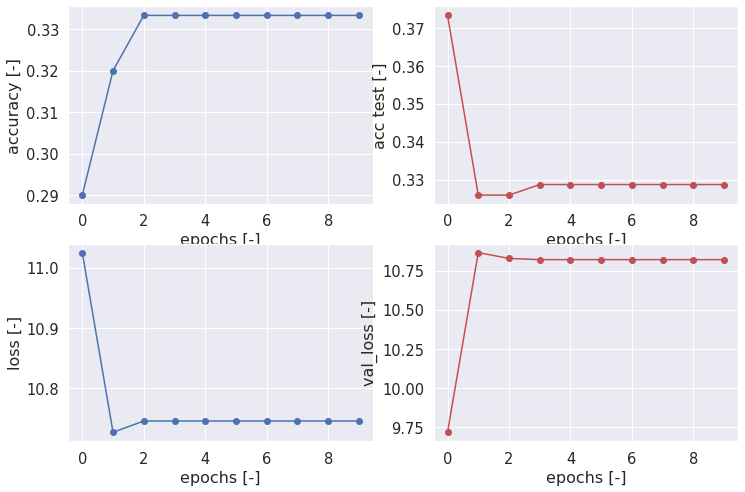

In [0]:
my_VGG16_03 = Sequential()  # Création d'un réseau de neurones vide 
my_VGG16_03.name = 'my_VGG16_03'
# Ajout de la première couche de convolution, suivie d'une couche ReLU
my_VGG16_03.add(Conv2D(64, kernel_size=3, strides=1, input_shape=(224, 224, 3),
                       padding='same', activation='relu',
                       kernel_initializer=keras.initializers.he_normal(seed=0)))
my_VGG16_03.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # test
# Ajout de la deuxième couche de convolution, suivie  d'une couche ReLU
my_VGG16_03.add(Conv2D(64, kernel_size=3, strides=1, padding='same', 
                       activation='relu',
                       kernel_initializer=keras.initializers.he_normal(seed=0)))

# Ajout de la première couche de pooling
my_VGG16_03.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # test
my_VGG16_03.add(Flatten())  # Conversion des matrices 3D en vecteur 1D

# Ajout de la première couche fully-connected, suivie d'une couche ReLU
my_VGG16_03.add(Dense(50, activation='relu',
                      kernel_initializer=keras.initializers.he_normal(seed=0)))

# Ajout de la dernière couche fully-connected qui permet de classifier
my_VGG16_03.add(Dense(nb_breeds, activation='softmax',
                kernel_initializer=keras.initializers.glorot_uniform(seed=0)))
print(my_VGG16_03.summary())

# optimizer
sgd_2 = optimizers.SGD(lr=0.0000001, decay=1e-6, momentum=0.9, nesterov=True) 
# compile model
my_VGG16_03.compile(loss="categorical_crossentropy", optimizer=sgd_2, 
                 metrics=["accuracy"])

# prepare training
epochs = 10
batch_size = None
t_fit_0 = time.time()
# fitting
model_info_3 = my_VGG16_03.fit(X_train, Y_train, epochs=epochs, 
                             batch_size=batch_size, verbose=2,
                             validation_data=(X_test, Y_test))
t_fit_1 = time.time()
print("Timing: ", t_fit_1 - t_fit_0)

# plot results at each iterations
plot_history(model_info_3.history)

#### Loop over nb conv filters / 50 nodes FC / init HE normal fixed seed (3 runs)

Output layer is fixed to 50.


##### Test earlystop

Model: "my_VGG16_03_early"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_28 (Flatten)         (None, 200704)            0         
_________________________________________________________________
dense_55 (Dense)             (None, 50)                10035250  
_________________________________________________________________
dense_56 (Dense)             (None, 3)           

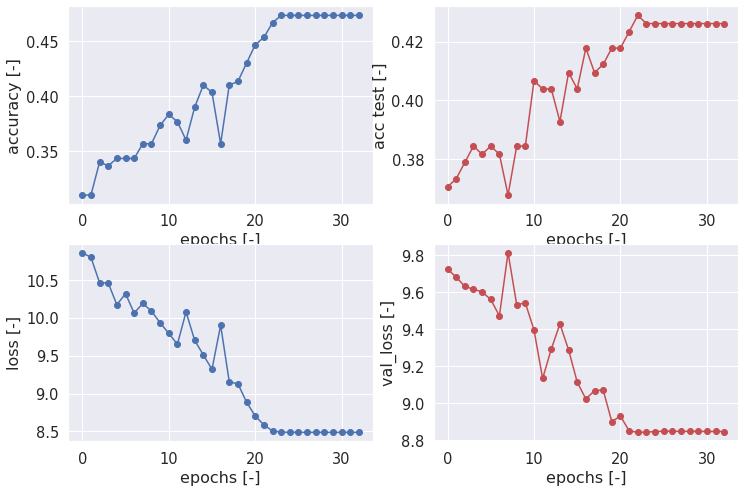

In [0]:
my_VGG16_03 = Sequential()  # Création d'un réseau de neurones vide 
my_VGG16_03.name = 'my_VGG16_03_early'
# Ajout de la première couche de convolution, suivie d'une couche ReLU
my_VGG16_03.add(Conv2D(64, kernel_size=3, strides=1, input_shape=(224, 224, 3),
                       padding='same', activation='relu',
                       kernel_initializer=keras.initializers.he_normal(seed=0)))
my_VGG16_03.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # test
# Ajout de la deuxième couche de convolution, suivie  d'une couche ReLU
my_VGG16_03.add(Conv2D(64, kernel_size=3, strides=1, padding='same', 
                       activation='relu',
                       kernel_initializer=keras.initializers.he_normal(seed=0)))

# Ajout de la première couche de pooling
my_VGG16_03.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # test
my_VGG16_03.add(Flatten())  # Conversion des matrices 3D en vecteur 1D

# Ajout de la première couche fully-connected, suivie d'une couche ReLU
my_VGG16_03.add(Dense(50, activation='relu',
                      kernel_initializer=keras.initializers.he_normal(seed=0)))

# Ajout de la dernière couche fully-connected qui permet de classifier
my_VGG16_03.add(Dense(nb_breeds, activation='softmax',
                kernel_initializer=keras.initializers.glorot_uniform(seed=0)))
print(my_VGG16_03.summary())

# optimizer
#0.000001
sgd_2 = optimizers.SGD(lr=3e-8, decay=1e-6, momentum=0.9, nesterov=True) 
# compile model
my_VGG16_03.compile(loss="categorical_crossentropy", optimizer=sgd_2, 
                 metrics=["accuracy"])
# prepare training
epochs = 100
batch_size = None
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                   verbose=1, patience=10,
                                   restore_best_weights=True)
t_fit_0 = time.time()
# fitting
model_info_3 = my_VGG16_03.fit(X_train, Y_train, epochs=epochs, 
                             batch_size=batch_size, verbose=2,
                             validation_data=(X_test, Y_test),
                             callbacks=[es])
t_fit_1 = time.time()
print("Timing: ", t_fit_1 - t_fit_0)

# plot results at each iterations
plot_history(model_info_3.history)

##### Loop over filters 64 128

In [0]:
df_res_filters_he_50nod = None
list_nb_filters = []
list_nb_try = []
# loop on nb filter to check if accuracy is better and memory not saturated
for nb_filters in [64, 128]:
  print("nb_filters: ", nb_filters)
  for nb_try in range(0, 3):
    print("nb_try: ", nb_try)
    list_nb_filters.append(nb_filters)
    list_nb_try.append(nb_try)

    my_VGG16_03 = Sequential()  # Création d'un réseau de neurones vide 
    my_VGG16_03.name = 'my_VGG16_03_{}filt_he_50nod_{}'.format(nb_filters, 
                                                               nb_try)
    # Ajout de la première couche de convolution, suivie d'une couche ReLU
    my_VGG16_03.add(Conv2D(nb_filters, kernel_size=3, strides=1, 
                      input_shape=(224, 224, 3), padding='same', 
                      activation='relu',
                      kernel_initializer=keras.initializers.he_normal(seed=0)))
    # Maxpooling layer
    my_VGG16_03.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) 
    # Ajout de la deuxième couche de convolution, suivie  d'une couche ReLU
    my_VGG16_03.add(Conv2D(nb_filters, kernel_size=3, strides=1, padding='same', 
                      activation='relu',
                      kernel_initializer=keras.initializers.he_normal(seed=0)))

    # Ajout de la première couche de pooling
    my_VGG16_03.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    my_VGG16_03.add(Flatten())  # Conversion des matrices 3D en vecteur 1D

    # Ajout de la première couche fully-connected, suivie d'une couche ReLU
    my_VGG16_03.add(Dense(50, activation='relu',
                      kernel_initializer=keras.initializers.he_normal(seed=0)))

    # Ajout de la dernière couche fully-connected qui permet de classifier
    my_VGG16_03.add(Dense(nb_breeds, activation='softmax',
                kernel_initializer=keras.initializers.glorot_uniform(seed=0)))
    
    print(my_VGG16_03.summary())

    # optimizer
    sgd_2 = optimizers.SGD(lr=3e-8, decay=1e-6, momentum=0.9, nesterov=True) 
    # compile model
    my_VGG16_03.compile(loss="categorical_crossentropy", optimizer=sgd_2, 
                    metrics=["accuracy"])
    # prepare training
    epochs = 150
    batch_size = None
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                      verbose=1, patience=30,
                                      restore_best_weights=True)
    t_fit_0 = time.time()
    # fitting
    model_info_3 = my_VGG16_03.fit(X_train, Y_train, epochs=epochs, 
                                batch_size=batch_size, verbose=2,
                                validation_data=(X_test, Y_test),
                                callbacks=[es])
    t_fit_1 = time.time()
    print("Timing: ", t_fit_1 - t_fit_0)

    # save : model info
    joblib.dump(model_info_3.history, 
                path_data + 'hist_my_VGG16_03_{}filt_he_50nod_{}.pkl'.\
                format(nb_filters, nb_try), compress=True)
    print("model_info_3 history Saved here:\n{}".\
          format(path_data + 'hist_my_VGG16_03_{}filt_he_50nod_{}.pkl'.\
                format(nb_filters, nb_try)))

    # plot results at each iterations
    plot_history(model_info_3.history)

    #  save
    my_VGG16_03.save(path_data + my_VGG16_03.name + '.h5')

    # predict as binary labels
    t_pred_0 = time.time()
    Y_train_pred = my_VGG16_03.predict(X_train)
    t_pred_1 = time.time()
    # predict as binary labels
    t_pred_2 = time.time()
    Y_test_pred = my_VGG16_03.predict(X_test)
    t_pred_3 = time.time()

    series_scores = evaluate_mdl_scorings(Y_train, Y_train_pred, 
                                      Y_test, Y_test_pred, 
      timing_fit=t_fit_1 - t_fit_0, 
      timing_pred=t_pred_3-t_pred_2+t_pred_1-t_pred_0)

    df_res_filters_he_50nod = add_score(df_res_filters_he_50nod, series_scores, 
                                       my_VGG16_03.name)

    # save results
    joblib.dump(df_res_filters_he_50nod, 
                path_data + 'df_res_filters_he_50nod.pkl', compress=True)
    print("df_res_filters_he_50nod Saved here:\n{}".\
          format(path_data + 'df_res_filters_he_50nod.pkl'))
    
    df_res_filters_he_50nod["nb_filters"] = list_nb_filters
    df_res_filters_he_50nod["nb_try"] = list_nb_try

# save results
joblib.dump(df_res_filters_he_50nod, 
            path_data + 'df_res_filters_he_50nod.pkl', compress=True)
print("df_res_filters_he_50nod Saved here:\n{}".\
          format(path_data + 'df_res_filters_he_50nod.pkl'))
    
df_res_filters_he_50nod

nb_filters:  64
nb_try:  0
Model: "my_VGG16_03_64filt_he_50nod_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_32 (Flatten)         (None, 200704)            0         
_________________________________________________________________
dense_63 (Dense)             (None, 50)                10035250  
_________________________________________________________________
dense_64 (

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/150
 - 10s - loss: 11.1304 - acc: 0.2900 - val_loss: 9.7683 - val_acc: 0.3621
Epoch 2/150
 - 8s - loss: 10.6194 - acc: 0.3300 - val_loss: 9.6172 - val_acc: 0.3788
Epoch 3/150
 - 8s - loss: 10.4066 - acc: 0.3367 - val_loss: 9.5202 - val_acc: 0.3872
Epoch 4/150
 - 8s - loss: 10.4631 - acc: 0.3267 - val_loss: 9.4031 - val_acc: 0.3872
Epoch 5/150
 - 9s - loss: 10.1718 - acc: 0.3533 - val_loss: 9.3408 - val_acc: 0.3928
Epoch 6/150
 - 10s - loss: 9.9985 - acc: 0.3667 - val_loss: 9.3972 - val_acc: 0.3955
Epoch 7/150
 - 10s - loss: 9.9092 - acc: 0.3733 - val_loss: 9.3783 - val_acc: 0.4011
Epoch 8/150
 - 9s - loss: 9.8301 - acc: 0.3833 - val_loss: 9.3605 - val_acc: 0.3900
Epoch 9/150
 - 8s - loss: 10.1053 - acc: 0.3400 - val_loss: 9.3250 - val_acc: 0.3872
Epoch 10/150
 - 8s - loss: 9.9770 - acc: 0.3500 - val_loss: 9.0050 - val_acc: 0.4150
Epoch 11/150
 - 8s - loss: 9.6356 - acc: 0.3633 - val_loss: 8.9664 - val_acc: 0.4095
Epoch 12/150
 - 8s 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/150
 - 18s - loss: 10.5229 - acc: 0.3200 - val_loss: 9.4284 - val_acc: 0.3900
Epoch 2/150
 - 15s - loss: 10.3100 - acc: 0.3433 - val_loss: 9.2020 - val_acc: 0.4234
Epoch 3/150
 - 15s - loss: 9.9647 - acc: 0.3733 - val_loss: 9.4748 - val_acc: 0.4011
Epoch 4/150
 - 15s - loss: 9.6906 - acc: 0.3833 - val_loss: 9.9396 - val_acc: 0.3677
Epoch 5/150
 - 15s - loss: 9.9265 - acc: 0.3800 - val_loss: 10.0204 - val_acc: 0.3733
Epoch 6/150
 - 15s - loss: 9.8748 - acc: 0.3800 - val_loss: 10.0866 - val_acc: 0.3593
Epoch 7/150
 - 15s - loss: 9.8107 - acc: 0.3833 - val_loss: 9.9587 - val_acc: 0.3677
Epoch 8/150
 - 15s - loss: 9.6363 - acc: 0.3967 - val_loss: 9.8757 - val_acc: 0.3733
Epoch 9/150
 - 15s - loss: 9.4958 - acc: 0.3867 - val_loss: 9.8160 - val_acc: 0.3760
Epoch 10/150
 - 15s - loss: 9.0668 - acc: 0.4333 - val_loss: 9.6862 - val_acc: 0.3844
Epoch 11/150
 - 15s - loss: 8.9769 - acc: 0.4400 - val_loss: 9.6723 - val_acc: 0.3844
Epoch 12/150


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/150
 - 18s - loss: 10.7136 - acc: 0.3167 - val_loss: 9.5903 - val_acc: 0.3872
Epoch 2/150
 - 15s - loss: 10.1956 - acc: 0.3467 - val_loss: 9.4346 - val_acc: 0.4039
Epoch 3/150
 - 15s - loss: 10.0320 - acc: 0.3567 - val_loss: 9.3445 - val_acc: 0.3955
Epoch 4/150
 - 15s - loss: 9.7052 - acc: 0.3833 - val_loss: 9.2835 - val_acc: 0.4095
Epoch 5/150
 - 15s - loss: 9.5181 - acc: 0.4000 - val_loss: 9.3494 - val_acc: 0.4067
Epoch 6/150
 - 15s - loss: 9.4393 - acc: 0.4033 - val_loss: 9.4516 - val_acc: 0.3955
Epoch 7/150
 - 15s - loss: 9.3123 - acc: 0.4167 - val_loss: 9.6731 - val_acc: 0.3872
Epoch 8/150
 - 15s - loss: 9.2021 - acc: 0.4167 - val_loss: 9.4461 - val_acc: 0.4039
Epoch 9/150
 - 15s - loss: 9.4202 - acc: 0.4067 - val_loss: 9.5867 - val_acc: 0.3816
Epoch 10/150
 - 15s - loss: 9.3445 - acc: 0.4033 - val_loss: 9.5619 - val_acc: 0.3788
Epoch 11/150
 - 14s - loss: 9.0887 - acc: 0.4167 - val_loss: 9.5808 - val_acc: 0.3816
Epoch 12/150
 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/150
 - 18s - loss: 11.2250 - acc: 0.2833 - val_loss: 10.1591 - val_acc: 0.3510
Epoch 2/150
 - 15s - loss: 11.2378 - acc: 0.2933 - val_loss: 10.4336 - val_acc: 0.3426
Epoch 3/150
 - 15s - loss: 10.9481 - acc: 0.3100 - val_loss: 10.6492 - val_acc: 0.3315
Epoch 4/150
 - 15s - loss: 10.9286 - acc: 0.3200 - val_loss: 10.4704 - val_acc: 0.3398
Epoch 5/150
 - 15s - loss: 10.8071 - acc: 0.3233 - val_loss: 10.4493 - val_acc: 0.3454
Epoch 6/150
 - 15s - loss: 10.7455 - acc: 0.3333 - val_loss: 10.4598 - val_acc: 0.3426
Epoch 7/150
 - 15s - loss: 10.7455 - acc: 0.3333 - val_loss: 10.4647 - val_acc: 0.3426
Epoch 8/150
 - 15s - loss: 10.7455 - acc: 0.3333 - val_loss: 10.4695 - val_acc: 0.3426
Epoch 9/150
 - 15s - loss: 10.7454 - acc: 0.3333 - val_loss: 10.4718 - val_acc: 0.3426
Epoch 10/150
 - 15s - loss: 10.7454 - acc: 0.3333 - val_loss: 10.4729 - val_acc: 0.3426
Epoch 11/150
 - 15s - loss: 10.7454 - acc: 0.3333 - val_loss: 10.4734 - val_acc: 0.

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


df_res_filters_he_50nod Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_filters_he_50nod.pkl
nb_filters:  256
nb_try:  0
Model: "my_VGG16_03_256filt_he_50nod_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_75 (Conv2D)           (None, 224, 224, 256)     7168      
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 112, 112, 256)     0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 112, 112, 256)     590080    
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 56, 56, 256)       0         
_________________________________________________________________
flatten_38 (Flatten)         (None, 802816)            0         
_________________________________________________________________
dense_75 (Dense)   

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/150
 - 36s - loss: 9.7432 - acc: 0.3733 - val_loss: 9.0352 - val_acc: 0.4095
Epoch 2/150
 - 33s - loss: 9.9912 - acc: 0.3667 - val_loss: 9.7877 - val_acc: 0.3872
Epoch 3/150
 - 32s - loss: 10.6711 - acc: 0.3367 - val_loss: 9.7769 - val_acc: 0.3928
Epoch 4/150
 - 33s - loss: 10.6917 - acc: 0.3367 - val_loss: 9.8774 - val_acc: 0.3872
Epoch 5/150
 - 33s - loss: 10.7454 - acc: 0.3333 - val_loss: 9.8774 - val_acc: 0.3872
Epoch 6/150
 - 33s - loss: 10.7454 - acc: 0.3333 - val_loss: 9.8774 - val_acc: 0.3872
Epoch 7/150
 - 33s - loss: 10.7454 - acc: 0.3333 - val_loss: 9.8774 - val_acc: 0.3872
Epoch 8/150
 - 33s - loss: 10.7454 - acc: 0.3333 - val_loss: 9.8774 - val_acc: 0.3872
Epoch 9/150
 - 33s - loss: 10.7454 - acc: 0.3333 - val_loss: 9.8774 - val_acc: 0.3872
Epoch 10/150
 - 33s - loss: 10.7454 - acc: 0.3333 - val_loss: 9.8774 - val_acc: 0.3872
Epoch 11/150
 - 33s - loss: 10.7454 - acc: 0.3333 - val_loss: 9.8774 - val_acc: 0.3872
Epoch 12

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/150
 - 36s - loss: 10.0179 - acc: 0.3500 - val_loss: 9.6011 - val_acc: 0.3760
Epoch 2/150
 - 33s - loss: 9.2986 - acc: 0.4133 - val_loss: 9.5270 - val_acc: 0.4011
Epoch 3/150
 - 33s - loss: 8.9955 - acc: 0.4300 - val_loss: 8.7573 - val_acc: 0.4290
Epoch 4/150
 - 32s - loss: 9.2185 - acc: 0.4100 - val_loss: 8.6801 - val_acc: 0.4345
Epoch 5/150
 - 32s - loss: 9.5139 - acc: 0.4000 - val_loss: 9.4303 - val_acc: 0.4095
Epoch 6/150
 - 32s - loss: 8.8779 - acc: 0.4300 - val_loss: 9.9616 - val_acc: 0.3621
Epoch 7/150
 - 32s - loss: 9.3392 - acc: 0.3967 - val_loss: 9.7204 - val_acc: 0.3955
Epoch 8/150
 - 32s - loss: 10.1211 - acc: 0.3600 - val_loss: 10.0116 - val_acc: 0.3593
Epoch 9/150
 - 32s - loss: 9.6360 - acc: 0.3900 - val_loss: 10.3113 - val_acc: 0.3426
Epoch 10/150
 - 33s - loss: 9.4925 - acc: 0.3967 - val_loss: 10.1987 - val_acc: 0.3454
Epoch 11/150
 - 32s - loss: 9.2435 - acc: 0.4200 - val_loss: 9.9655 - val_acc: 0.3649
Epoch 12/150

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/150
 - 48s - loss: 10.2048 - acc: 0.3367 - val_loss: 10.4111 - val_acc: 0.3343
Epoch 2/150
 - 44s - loss: 10.0532 - acc: 0.3633 - val_loss: 10.1923 - val_acc: 0.3454
Epoch 3/150
 - 43s - loss: 10.3928 - acc: 0.3433 - val_loss: 11.3222 - val_acc: 0.2953
Epoch 4/150
 - 43s - loss: 10.7599 - acc: 0.3300 - val_loss: 11.5386 - val_acc: 0.2841
Epoch 5/150
 - 43s - loss: 10.7454 - acc: 0.3333 - val_loss: 11.5386 - val_acc: 0.2841
Epoch 6/150
 - 44s - loss: 10.7454 - acc: 0.3333 - val_loss: 11.5386 - val_acc: 0.2841
Epoch 7/150
 - 43s - loss: 10.7454 - acc: 0.3333 - val_loss: 11.5386 - val_acc: 0.2841
Epoch 8/150
 - 44s - loss: 10.7454 - acc: 0.3333 - val_loss: 11.5386 - val_acc: 0.2841
Epoch 9/150
 - 43s - loss: 10.7454 - acc: 0.3333 - val_loss: 11.5386 - val_acc: 0.2841
Epoch 10/150
 - 43s - loss: 10.7454 - acc: 0.3333 - val_loss: 11.5386 - val_acc: 0.2841
Epoch 11/150
 - 43s - loss: 10.7454 - acc: 0.3333 - val_loss: 11.5386 - val_acc: 0.

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/150
 - 48s - loss: 10.3537 - acc: 0.3167 - val_loss: 10.2503 - val_acc: 0.3426
Epoch 2/150
 - 44s - loss: 9.5745 - acc: 0.3800 - val_loss: 9.8807 - val_acc: 0.3649
Epoch 3/150
 - 44s - loss: 9.0091 - acc: 0.4233 - val_loss: 9.7623 - val_acc: 0.3788
Epoch 4/150
 - 44s - loss: 8.9164 - acc: 0.4300 - val_loss: 10.1014 - val_acc: 0.3510
Epoch 5/150
 - 44s - loss: 9.0552 - acc: 0.4233 - val_loss: 9.8612 - val_acc: 0.3705
Epoch 6/150
 - 44s - loss: 8.5885 - acc: 0.4567 - val_loss: 9.9623 - val_acc: 0.3621
Epoch 7/150
 - 44s - loss: 9.1881 - acc: 0.4300 - val_loss: 10.8149 - val_acc: 0.3259
Epoch 8/150
 - 44s - loss: 9.9100 - acc: 0.3800 - val_loss: 11.0742 - val_acc: 0.3092
Epoch 9/150
 - 44s - loss: 9.7622 - acc: 0.3900 - val_loss: 10.8056 - val_acc: 0.3259
Epoch 10/150
 - 44s - loss: 9.6616 - acc: 0.3967 - val_loss: 10.3821 - val_acc: 0.3482
Epoch 11/150
 - 44s - loss: 9.3721 - acc: 0.4100 - val_loss: 9.9762 - val_acc: 0.3621
Epoch 12/1

In [0]:
print("Loading from disk df_results...")
df_results = joblib.load(path_df_results)
print("Loading from disk df_res_filters...")
df_res_filters = joblib.load(path_data + 'df_res_filters.pkl')
print("Loading from disk df_res_nodes...")
df_res_nodes = joblib.load(path_data + 'df_res_nodes.pkl')
print("Loading from disk df_res_filters_max...")
df_res_filters_max = joblib.load(path_data + 'df_res_filters_max.pkl')
print("Loading from disk df_res_filters_he_50nod.pkl...")
df_res_filters_he_50nod = joblib.load(path_data + 'df_res_filters_he_50nod.pkl')

Loading from disk df_results...
Loading from disk df_res_filters...
Loading from disk df_res_nodes...
Loading from disk df_res_filters_max...
Loading from disk df_res_filters_he_50nod.pkl...


In [0]:
df_res_filters_he_50nod

acc_test  acc_train  nb_filters  nb_try  \
my_VGG16_03_64filt_he_50nod_0   0.417827   0.430000        64.0     0.0   
my_VGG16_03_64filt_he_50nod_1   0.392758   0.376667        64.0     1.0   
my_VGG16_03_64filt_he_50nod_2   0.434540   0.450000        64.0     2.0   
my_VGG16_03_128filt_he_50nod_0  0.423398   0.353333       128.0     0.0   
my_VGG16_03_128filt_he_50nod_1  0.409471   0.396667       128.0     1.0   
my_VGG16_03_128filt_he_50nod_2  0.350975   0.290000       128.0     2.0   
my_VGG16_03_256filt_he_50nod_0  0.387187   0.333333         NaN     NaN   

                                      t_fit     t_pred  
my_VGG16_03_64filt_he_50nod_0    388.014725   4.111839  
my_VGG16_03_64filt_he_50nod_1    314.672082   4.001432  
my_VGG16_03_64filt_he_50nod_2    349.375930   5.031592  
my_VGG16_03_128filt_he_50nod_0   484.828323   5.954232  
my_VGG16_03_128filt_he_50nod_1   510.914365   5.861617  
my_VGG16_03_128filt_he_50nod_2   466.134335   5.928975  
my_VGG16_03_256filt_he_50nod_0  1323.231511  13.057279

##### Loops over filter 256 320

In [0]:
list_nb_filters = df_res_filters_he_50nod["nb_filters"].tolist()
list_nb_try = df_res_filters_he_50nod["nb_try"].tolist()

nb_filters:  256
nb_try:  0
Model: "my_VGG16_03_256filt_he_50nod_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 224, 224, 256)     7168      
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 112, 112, 256)     0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 112, 112, 256)     590080    
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 56, 56, 256)       0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 802816)            0         
_________________________________________________________________
dense_39 (Dense)             (None, 50)                40140850  
_________________________________________________________________
dense_40

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/150
 - 37s - loss: 9.8691 - acc: 0.3767 - val_loss: 10.7304 - val_acc: 0.3343
Epoch 2/150
 - 35s - loss: 10.7026 - acc: 0.3333 - val_loss: 10.8202 - val_acc: 0.3287
Epoch 3/150
 - 35s - loss: 10.6917 - acc: 0.3367 - val_loss: 10.8202 - val_acc: 0.3287
Epoch 4/150
 - 35s - loss: 10.6917 - acc: 0.3367 - val_loss: 10.8202 - val_acc: 0.3287
Epoch 5/150
 - 35s - loss: 10.6888 - acc: 0.3367 - val_loss: 10.7344 - val_acc: 0.3315
Epoch 6/150
 - 35s - loss: 10.6005 - acc: 0.3400 - val_loss: 10.4017 - val_acc: 0.3538
Epoch 7/150
 - 35s - loss: 10.3569 - acc: 0.3500 - val_loss: 10.1051 - val_acc: 0.3649
Epoch 8/150
 - 35s - loss: 9.3359 - acc: 0.4067 - val_loss: 9.3790 - val_acc: 0.4039
Epoch 9/150
 - 35s - loss: 10.0361 - acc: 0.3700 - val_loss: 9.7879 - val_acc: 0.3928
Epoch 10/150
 - 35s - loss: 10.7454 - acc: 0.3333 - val_loss: 9.9046 - val_acc: 0.3844
Epoch 11/150
 - 35s - loss: 10.7454 - acc: 0.3333 - val_loss: 9.8930 - val_acc: 0.3844
E

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/150
 - 36s - loss: 9.5196 - acc: 0.3767 - val_loss: 9.6938 - val_acc: 0.3621
Epoch 2/150
 - 35s - loss: 8.9612 - acc: 0.4300 - val_loss: 9.5127 - val_acc: 0.3872
Epoch 3/150
 - 35s - loss: 8.9253 - acc: 0.4333 - val_loss: 9.0850 - val_acc: 0.4067
Epoch 4/150
 - 35s - loss: 8.2465 - acc: 0.4733 - val_loss: 8.9731 - val_acc: 0.4150
Epoch 5/150
 - 35s - loss: 8.9186 - acc: 0.4233 - val_loss: 9.8834 - val_acc: 0.3816
Epoch 6/150
 - 35s - loss: 9.0818 - acc: 0.4300 - val_loss: 10.0508 - val_acc: 0.3705
Epoch 7/150
 - 35s - loss: 9.2058 - acc: 0.4267 - val_loss: 9.7130 - val_acc: 0.3872
Epoch 8/150
 - 35s - loss: 8.7932 - acc: 0.4433 - val_loss: 9.3083 - val_acc: 0.3928
Epoch 9/150
 - 35s - loss: 9.7090 - acc: 0.3733 - val_loss: 9.0907 - val_acc: 0.4067
Epoch 10/150
 - 35s - loss: 8.3290 - acc: 0.4700 - val_loss: 9.5884 - val_acc: 0.3955
Epoch 11/150
 - 35s - loss: 9.2545 - acc: 0.4233 - val_loss: 10.5556 - val_acc: 0.3398
Epoch 12/150
 -

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/150
 - 47s - loss: 10.0091 - acc: 0.3533 - val_loss: 10.7618 - val_acc: 0.3315
Epoch 2/150
 - 45s - loss: 10.6932 - acc: 0.3367 - val_loss: 10.8202 - val_acc: 0.3287
Epoch 3/150
 - 46s - loss: 10.7454 - acc: 0.3333 - val_loss: 10.8202 - val_acc: 0.3287
Epoch 4/150
 - 45s - loss: 10.7454 - acc: 0.3333 - val_loss: 10.8202 - val_acc: 0.3287
Epoch 5/150
 - 45s - loss: 10.7454 - acc: 0.3333 - val_loss: 10.8202 - val_acc: 0.3287
Epoch 6/150
 - 45s - loss: 10.7454 - acc: 0.3333 - val_loss: 10.8202 - val_acc: 0.3287
Epoch 7/150
 - 45s - loss: 10.7454 - acc: 0.3333 - val_loss: 10.8202 - val_acc: 0.3287
Epoch 8/150
 - 45s - loss: 10.7454 - acc: 0.3333 - val_loss: 10.8202 - val_acc: 0.3287
Epoch 9/150
 - 46s - loss: 10.7454 - acc: 0.3333 - val_loss: 10.8202 - val_acc: 0.3287
Epoch 10/150
 - 45s - loss: 10.7454 - acc: 0.3333 - val_loss: 10.8202 - val_acc: 0.3287
Epoch 11/150
 - 45s - loss: 10.7454 - acc: 0.3333 - val_loss: 10.8202 - val_acc: 0.

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/150
 - 48s - loss: 10.0944 - acc: 0.3600 - val_loss: 10.3310 - val_acc: 0.3370
Epoch 2/150
 - 46s - loss: 10.2075 - acc: 0.3500 - val_loss: 10.7604 - val_acc: 0.3203
Epoch 3/150
 - 46s - loss: 10.0823 - acc: 0.3567 - val_loss: 10.4399 - val_acc: 0.3370
Epoch 4/150
 - 46s - loss: 9.8256 - acc: 0.3767 - val_loss: 10.2081 - val_acc: 0.3538
Epoch 5/150
 - 46s - loss: 9.9250 - acc: 0.3767 - val_loss: 10.1844 - val_acc: 0.3649
Epoch 6/150
 - 46s - loss: 9.4679 - acc: 0.3933 - val_loss: 9.7631 - val_acc: 0.3816
Epoch 7/150
 - 46s - loss: 8.3545 - acc: 0.4667 - val_loss: 10.3279 - val_acc: 0.3398
Epoch 8/150
 - 45s - loss: 8.5017 - acc: 0.4567 - val_loss: 9.5348 - val_acc: 0.3900
Epoch 9/150
 - 44s - loss: 8.5149 - acc: 0.4567 - val_loss: 10.9442 - val_acc: 0.3175
Epoch 10/150
 - 44s - loss: 9.9924 - acc: 0.3700 - val_loss: 10.0578 - val_acc: 0.3593
Epoch 11/150
 - 44s - loss: 8.9184 - acc: 0.4400 - val_loss: 10.1696 - val_acc: 0.3565
Epoch

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/150
 - 46s - loss: 10.0960 - acc: 0.3567 - val_loss: 10.6689 - val_acc: 0.3287
Epoch 2/150
 - 44s - loss: 10.1911 - acc: 0.3600 - val_loss: 10.9031 - val_acc: 0.3120
Epoch 3/150
 - 44s - loss: 9.8410 - acc: 0.3800 - val_loss: 10.5813 - val_acc: 0.3343
Epoch 4/150
 - 44s - loss: 9.7558 - acc: 0.3767 - val_loss: 10.0645 - val_acc: 0.3621
Epoch 5/150
 - 44s - loss: 10.3272 - acc: 0.3500 - val_loss: 10.4035 - val_acc: 0.3510
Epoch 6/150
 - 44s - loss: 9.9901 - acc: 0.3767 - val_loss: 10.1197 - val_acc: 0.3621
Epoch 7/150
 - 44s - loss: 9.9545 - acc: 0.3667 - val_loss: 10.1402 - val_acc: 0.3649
Epoch 8/150
 - 44s - loss: 9.6772 - acc: 0.3900 - val_loss: 9.9743 - val_acc: 0.3760
Epoch 9/150
 - 44s - loss: 9.3082 - acc: 0.4200 - val_loss: 9.8214 - val_acc: 0.3760
Epoch 10/150
 - 44s - loss: 8.9909 - acc: 0.4233 - val_loss: 9.7373 - val_acc: 0.3760
Epoch 11/150
 - 44s - loss: 8.8427 - acc: 0.4333 - val_loss: 9.6198 - val_acc: 0.3900
Epoch 1

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


acc_test  acc_train  nb_filters  nb_try  \
my_VGG16_03_64filt_he_50nod_0   0.417827   0.430000        64.0     0.0   
my_VGG16_03_64filt_he_50nod_1   0.392758   0.376667        64.0     1.0   
my_VGG16_03_64filt_he_50nod_2   0.434540   0.450000        64.0     2.0   
my_VGG16_03_128filt_he_50nod_0  0.423398   0.353333       128.0     0.0   
my_VGG16_03_128filt_he_50nod_1  0.409471   0.396667       128.0     1.0   
my_VGG16_03_128filt_he_50nod_2  0.350975   0.290000       128.0     2.0   
my_VGG16_03_256filt_he_50nod_0  0.506964   0.680000       256.0     0.0   
my_VGG16_03_256filt_he_50nod_1  0.403900   0.426667       256.0     1.0   
my_VGG16_03_256filt_he_50nod_2  0.476323   0.550000       256.0     2.0   
my_VGG16_03_320filt_he_50nod_0  0.331476   0.333333       320.0     0.0   
my_VGG16_03_320filt_he_50nod_1  0.529248   0.786667       320.0     1.0   
my_VGG16_03_320filt_he_50nod_2  0.465181   0.650000       320.0     2.0   

                                      t_fit     t_pred  
my_VGG16_03_64filt_he_50nod_0    388.014725   4.111839  
my_VGG16_03_64filt_he_50nod_1    314.672082   4.001432  
my_VGG16_03_64filt_he_50nod_2    349.375930   5.031592  
my_VGG16_03_128filt_he_50nod_0   484.828323   5.954232  
my_VGG16_03_128filt_he_50nod_1   510.914365   5.861617  
my_VGG16_03_128filt_he_50nod_2   466.134335   5.928975  
my_VGG16_03_256filt_he_50nod_0  2049.469012  12.379860  
my_VGG16_03_256filt_he_50nod_1  1330.368229  12.761430  
my_VGG16_03_256filt_he_50nod_2  1864.763508  13.014680  
my_VGG16_03_320filt_he_50nod_0  1400.936832  19.038370  
my_VGG16_03_320filt_he_50nod_1  4450.586384  18.094490  
my_VGG16_03_320filt_he_50nod_2  3500.197580  18.017205

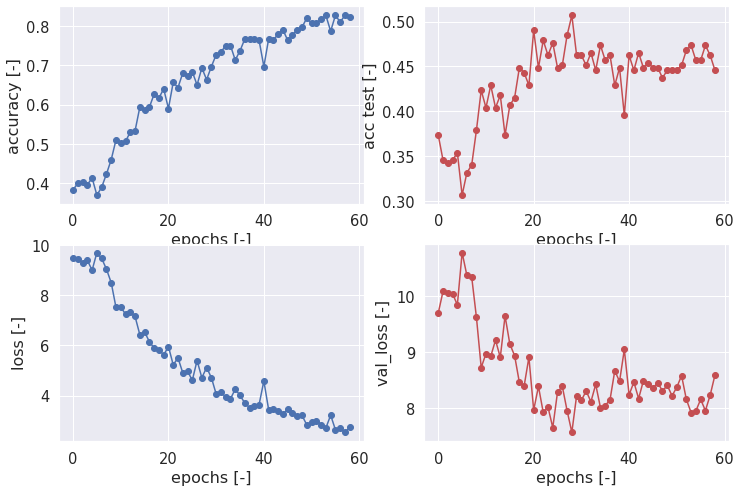

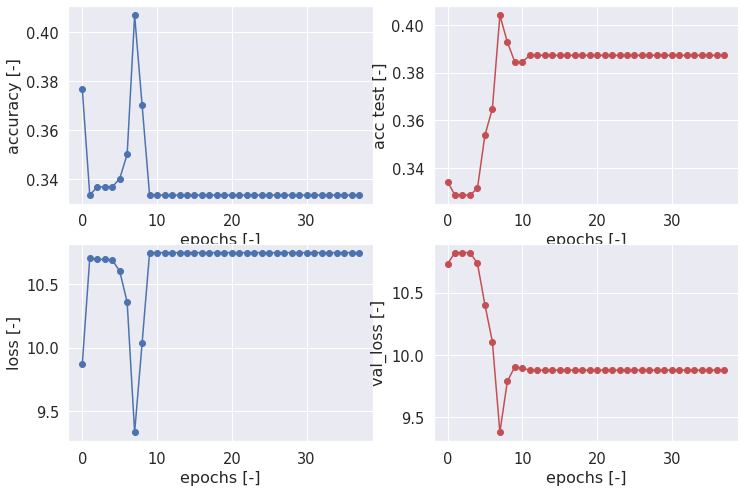

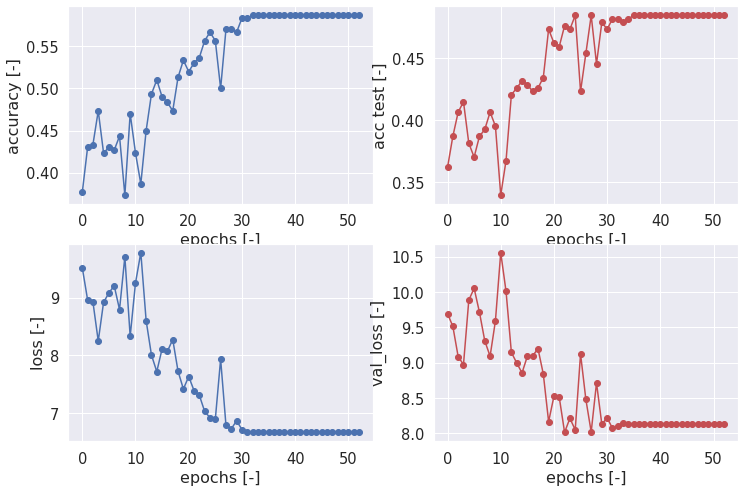

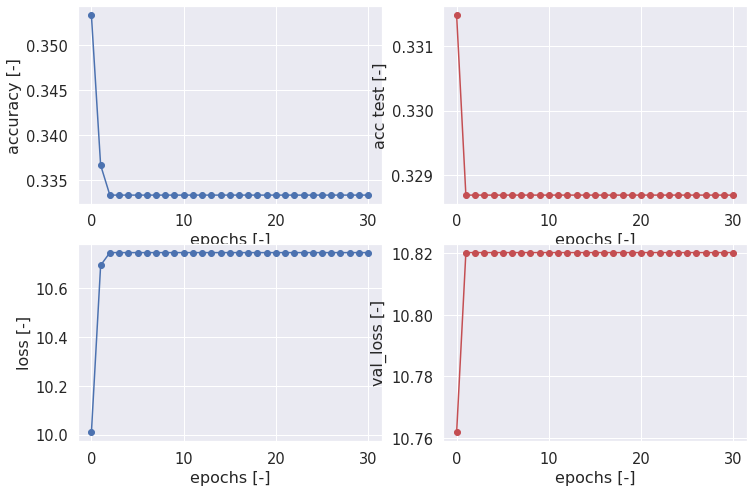

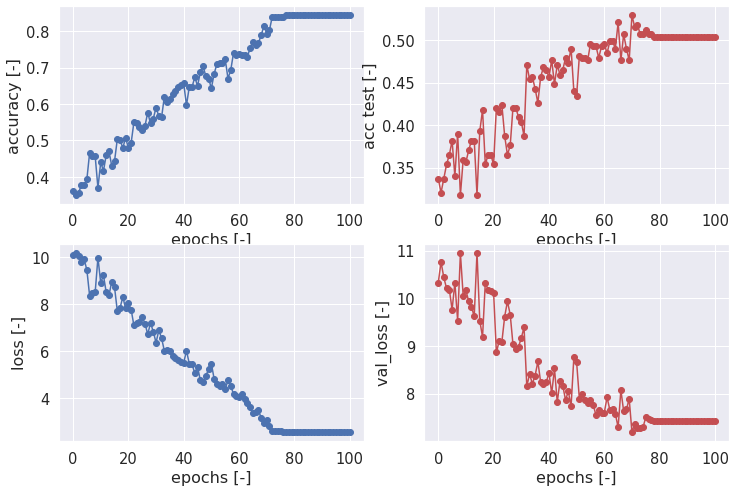

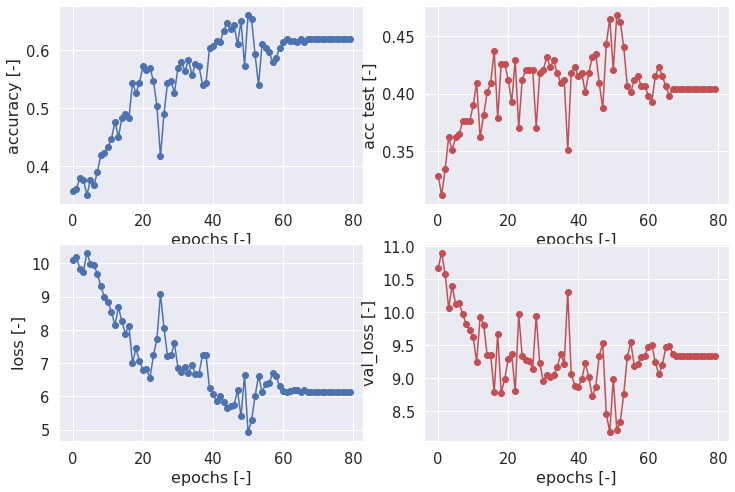

In [0]:
# loop on nb filter to check if accuracy 
# several tries
# 
for nb_filters in [256, 320]:
  print("nb_filters: ", nb_filters)
  for nb_try in range(0, 3):
    print("nb_try: ", nb_try)
    list_nb_filters.append(nb_filters)
    list_nb_try.append(nb_try)

    my_VGG16_03 = Sequential()  # Création d'un réseau de neurones vide 
    my_VGG16_03.name = 'my_VGG16_03_{}filt_he_50nod_{}'.format(nb_filters, 
                                                               nb_try)
    # Ajout de la première couche de convolution, suivie d'une couche ReLU
    my_VGG16_03.add(Conv2D(nb_filters, kernel_size=3, strides=1, 
                      input_shape=(224, 224, 3), padding='same', 
                      activation='relu',
                      kernel_initializer=keras.initializers.he_normal(seed=0)))
    # Maxpooling layer
    my_VGG16_03.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) 
    # Ajout de la deuxième couche de convolution, suivie  d'une couche ReLU
    my_VGG16_03.add(Conv2D(nb_filters, kernel_size=3, strides=1, padding='same', 
                      activation='relu',
                      kernel_initializer=keras.initializers.he_normal(seed=0)))

    # Ajout de la première couche de pooling
    my_VGG16_03.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    my_VGG16_03.add(Flatten())  # Conversion des matrices 3D en vecteur 1D

    # Ajout de la première couche fully-connected, suivie d'une couche ReLU
    my_VGG16_03.add(Dense(50, activation='relu',
                      kernel_initializer=keras.initializers.he_normal(seed=0)))

    # Ajout de la dernière couche fully-connected qui permet de classifier
    my_VGG16_03.add(Dense(nb_breeds, activation='softmax',
                kernel_initializer=keras.initializers.glorot_uniform(seed=0)))
    
    print(my_VGG16_03.summary())

    # optimizer
    sgd_2 = optimizers.SGD(lr=3e-8, decay=1e-6, momentum=0.9, nesterov=True) 
    # compile model
    my_VGG16_03.compile(loss="categorical_crossentropy", optimizer=sgd_2, 
                    metrics=["accuracy"])
    # prepare training
    epochs = 150
    batch_size = None
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                      verbose=1, patience=30,
                                      restore_best_weights=True)
    t_fit_0 = time.time()
    # fitting
    model_info_3 = my_VGG16_03.fit(X_train, Y_train, epochs=epochs, 
                                batch_size=batch_size, verbose=2,
                                validation_data=(X_test, Y_test),
                                callbacks=[es])
    t_fit_1 = time.time()
    print("Timing: ", t_fit_1 - t_fit_0)

    # save : model info
    joblib.dump(model_info_3.history, 
                path_data + 'hist_my_VGG16_03_{}filt_he_50nod_{}.pkl'.\
                format(nb_filters, nb_try), compress=True)
    print("model_info_3 history Saved here:\n{}".\
          format(path_data + 'hist_my_VGG16_03_{}filt_he_50nod_{}.pkl'.\
                format(nb_filters, nb_try)))

    # plot results at each iterations
    plot_history(model_info_3.history)

    #  save
    my_VGG16_03.save(path_data + my_VGG16_03.name + '.h5')

    # predict as binary labels
    t_pred_0 = time.time()
    Y_train_pred = my_VGG16_03.predict(X_train)
    t_pred_1 = time.time()
    # predict as binary labels
    t_pred_2 = time.time()
    Y_test_pred = my_VGG16_03.predict(X_test)
    t_pred_3 = time.time()

    series_scores = evaluate_mdl_scorings(Y_train, Y_train_pred, 
                                      Y_test, Y_test_pred, 
      timing_fit=t_fit_1 - t_fit_0, 
      timing_pred=t_pred_3-t_pred_2+t_pred_1-t_pred_0)

    df_res_filters_he_50nod = add_score(df_res_filters_he_50nod, series_scores, 
                                       my_VGG16_03.name)

    # save results
    joblib.dump(df_res_filters_he_50nod, 
                path_data + 'df_res_filters_he_50nod.pkl', compress=True)
    print("df_res_filters_he_50nod Saved here:\n{}".\
          format(path_data + 'df_res_filters_he_50nod.pkl'))
    
    df_res_filters_he_50nod["nb_filters"] = list_nb_filters
    df_res_filters_he_50nod["nb_try"] = list_nb_try

# save results
joblib.dump(df_res_filters_he_50nod, 
            path_data + 'df_res_filters_he_50nod.pkl', compress=True)
print("df_res_filters_he_50nod Saved here:\n{}".\
          format(path_data + 'df_res_filters_he_50nod.pkl'))
    
df_res_filters_he_50nod

#### Compare

In [0]:
df_res_filters_he_50nod

acc_test  acc_train  nb_filters  nb_try  \
my_VGG16_03_64filt_he_50nod_0   0.417827   0.430000        64.0     0.0   
my_VGG16_03_64filt_he_50nod_1   0.392758   0.376667        64.0     1.0   
my_VGG16_03_64filt_he_50nod_2   0.434540   0.450000        64.0     2.0   
my_VGG16_03_128filt_he_50nod_0  0.423398   0.353333       128.0     0.0   
my_VGG16_03_128filt_he_50nod_1  0.409471   0.396667       128.0     1.0   
my_VGG16_03_128filt_he_50nod_2  0.350975   0.290000       128.0     2.0   
my_VGG16_03_256filt_he_50nod_0  0.506964   0.680000       256.0     0.0   
my_VGG16_03_256filt_he_50nod_1  0.403900   0.426667       256.0     1.0   
my_VGG16_03_256filt_he_50nod_2  0.476323   0.550000       256.0     2.0   
my_VGG16_03_320filt_he_50nod_0  0.331476   0.333333       320.0     0.0   
my_VGG16_03_320filt_he_50nod_1  0.529248   0.786667       320.0     1.0   
my_VGG16_03_320filt_he_50nod_2  0.465181   0.650000       320.0     2.0   

                                      t_fit     t_pred  
my_VGG16_03_64filt_he_50nod_0    388.014725   4.111839  
my_VGG16_03_64filt_he_50nod_1    314.672082   4.001432  
my_VGG16_03_64filt_he_50nod_2    349.375930   5.031592  
my_VGG16_03_128filt_he_50nod_0   484.828323   5.954232  
my_VGG16_03_128filt_he_50nod_1   510.914365   5.861617  
my_VGG16_03_128filt_he_50nod_2   466.134335   5.928975  
my_VGG16_03_256filt_he_50nod_0  2049.469012  12.379860  
my_VGG16_03_256filt_he_50nod_1  1330.368229  12.761430  
my_VGG16_03_256filt_he_50nod_2  1864.763508  13.014680  
my_VGG16_03_320filt_he_50nod_0  1400.936832  19.038370  
my_VGG16_03_320filt_he_50nod_1  4450.586384  18.094490  
my_VGG16_03_320filt_he_50nod_2  3500.197580  18.017205

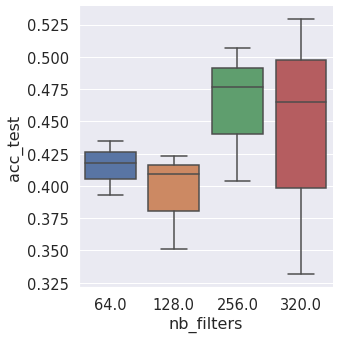

In [0]:
sns.catplot(x="nb_filters", y="acc_test", kind="box", 
            data=df_res_filters_he_50nod);

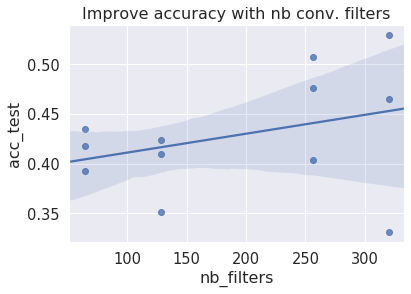

In [0]:
ax = sns.regplot(x="nb_filters", y="acc_test", data=df_res_filters_he_50nod);
ax.set_title("Improve accuracy with nb conv. filters");

Text(0.5, 1.0, 'Increase of time with number of conv. filters')

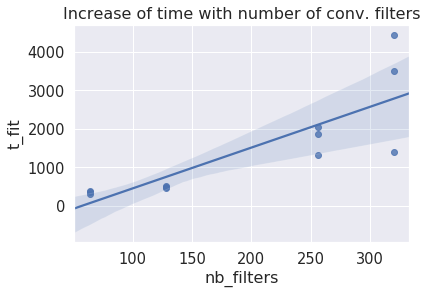

In [0]:
ax = sns.regplot(x="nb_filters", y="t_fit", data=df_res_filters_he_50nod);
ax.set_title("Increase of time with number of conv. filters")

In [0]:
nb_splits = df_res_filters_he_50nod["nb_try"].nunique()
def confid_interv(value):
  return 1.96*np.std(value)/np.sqrt(nb_splits)
df_filters = df_res_filters_he_50nod.pivot_table(values=["acc_test",	
                                                         "acc_train", 
                                                "t_fit",	"t_pred"],
                           index="nb_filters", aggfunc={np.mean, confid_interv})
df_filters

acc_test               acc_train                   t_fit  \
           confid_interv      mean confid_interv      mean confid_interv   
nb_filters                                                                 
64.0            0.019431  0.415042      0.035025  0.418889     33.898824   
128.0           0.035507  0.394615      0.049565  0.346667     20.781060   
256.0           0.048900  0.462396      0.117048  0.552222    345.052456   
320.0           0.093235  0.441968      0.214862  0.590000   1441.805518   

                               t_pred             
                   mean confid_interv       mean  
nb_filters                                        
64.0         350.687579      0.522580   4.381621  
128.0        487.292341      0.044235   5.914941  
256.0       1748.200250      0.295262  12.718657  
320.0       3117.240265      0.525336  18.383355

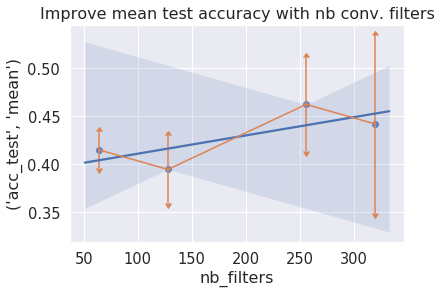

In [0]:
df_filters["nb_filters"] = df_filters.index
ax = sns.regplot(x=df_filters["nb_filters"] , y=df_filters[("acc_test","mean")]);
ax.set_title("Improve mean test accuracy with nb conv. filters");
plt.errorbar(df_filters["nb_filters"], df_filters[("acc_test","mean")], 
             yerr=df_filters[("acc_test","confid_interv")], uplims=True, 
             lolims=True);

#### Conclusion

Better results if number of conv filters increases.

But confident interval increase too.

Maybe 256 filters for Conv layers is good enough

HE normal initializers for ReLu layer is better to avoid overfitting.

But learning rate is very important for model convergence